In [31]:
import sys 
#print(sys.path) 
sys.path.insert(0, '/eos/user/j/jbabbar/.local/lib/python3.9/site-packages')

import sklearn 
print('The scikit-learn version is {}.'.format(sklearn.__version__))
#print('The scikit-learn version is {}.'.format(sklearn.version)) 
print("Python version")
print (sys.version) 
print("Version info.") 
print (sys.version_info)


The scikit-learn version is 1.2.2.
Python version
3.9.12 (main, Jul 11 2023, 14:37:47) 
[GCC 11.3.0]
Version info.
sys.version_info(major=3, minor=9, micro=12, releaselevel='final', serial=0)


In [32]:
from utils_onlyz import *

import awkward as ak
import glob
import numpy as np
import uproot as uproot
import matplotlib
import matplotlib.colors
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import torch_geometric as pyg
from sklearn.manifold import TSNE
from sklearn import metrics

import torch_geometric.transforms as T
from torch_geometric.data import Data
import torch_geometric.utils as Utils
from tqdm import tqdm

import mplhep as hep
import glob
import argparse
import importlib.util

from sklearn.metrics import DetCurveDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import class_likelihood_ratios, precision_recall_fscore_support


%matplotlib inline
from matplotlib import rc
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [33]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, balanced_accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import numpy as np
import pickle
import argparse
import mplhep as hep
import importlib.util

#plt.style.use(hep.style.CMS)
"""Testing of the trained models."""


def get_model_prediction(model, testLoader, prepare_network_input_data=None, 
                         device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    """
    Gets model predictions on test edges.
    model: the trained network.
    testLoader: DataLoader of already pre-processed data.
    """
    print('device', device)
    model.to(device)
    predictions, truth = [], []
    
    for sample in tqdm(testLoader, desc="Getting model predictions"):
        sample = sample.to(device)
        
        if prepare_network_input_data is not None:
            inputs = prepare_network_input_data(sample.x, sample.edge_index)
        else:
            inputs = (sample.x, sample.edge_index)
            
        link_pred, emb = model(*inputs)
        predictions.append(link_pred.cpu().detach().numpy())
        truth.append(sample.edge_label.cpu().detach().numpy())
    return truth, predictions

def evaluate_clusters(dataset, predictions=None, thr=None, geometric=False, numevents=1000, PU=False):
    """
    Calculates homogenity, completeness, v-measure, adjusted random index and mutual info of the clustering.
    Predictions are the list of lists containing network scores for edges.
    """
    hom, compl, vmeas, randind, mutinfo = [], [], [], [], []
    
    for i in tqdm(range(numevents)):
        event = dataset[i]
        if not geometric:
            components, predicted_cluster_ids = find_connected_components(event, predictions[i], edge_index=None, thr=thr, PU=PU)
        else:
            predicted_cluster_ids = event.candidate_match.cpu().detach().numpy()
            
        t_match = event.best_simTs_match.cpu().detach().numpy()
        
        hom.append(metrics.homogeneity_score(t_match, predicted_cluster_ids))
        compl.append(metrics.completeness_score(t_match, predicted_cluster_ids))
        vmeas.append(metrics.v_measure_score(t_match, predicted_cluster_ids))
        randind.append(metrics.adjusted_rand_score(t_match, predicted_cluster_ids))
        mutinfo.append(metrics.adjusted_mutual_info_score(t_match, predicted_cluster_ids))
    
    return hom, compl, vmeas, randind, mutinfo

def classification_thresholds_plot(scores, ground_truth, threshold_step=0.05, output_folder=None, epoch=None):
    """
    Plots and saves the figure of the dependancy of th eaccuracy, True Positive rate (TPR) and 
    True Negative rate (TNR) on the value of the classification threshold.
    """    
    thresholds = np.arange(0, 1 + threshold_step, threshold_step)
    ACC, TNR, TPR, F1 = [], [], [], []
    for threshold in thresholds:
        
        prediction = scores > threshold
        
        TN, FP, FN, TP = confusion_matrix(ground_truth, prediction).ravel()
        ACC.append((TP+TN)/(TN + FP + FN + TP))
        TNR.append(TN/(TN+FP))
        TPR.append(TP/(TP+FN))
        F1.append(f1_score(ground_truth, prediction))
    
    # Saving the figure of the classification threshold plot
    fig = plt.figure(figsize=(9,6))
    plt.plot(thresholds, ACC, 'go-', label='ACC', linewidth=2)
    plt.plot(thresholds, TNR, 'bo-', label='TNR', linewidth=2)
    plt.plot(thresholds, TPR, 'ro-', label='TPR', linewidth=2)
    plt.plot(thresholds, F1, 'mo-', label='F1', linewidth=2)
    plt.xlabel("Threshold", fontsize=15)
    plt.title("Accuracy / TPR / TNR / F1 based on the classification threshold value", fontsize=16)
    plt.legend()
    
    if output_folder is not None:
        f_name = f"classification_thresholds_epoch_{epoch}.png" if epoch is not None else "classification_thresholds.png"
        plt.savefig(f"{output_folder}/{f_name}", dpi=300, bbox_inches='tight', transparent=True)
        plt.show()
       
    return TNR, TPR, thresholds

def get_best_threshold(TNR, TPR, thresholds, epsilon = 0.02, default=0.65):
    # Find the threshold for which TNR and TPR intersect
    
    for i in range(len(thresholds)-1):
        if abs(TNR[i] - TPR[i]) < epsilon:
            return round(thresholds[i], 3)
    
        if TNR[i] - TPR[i] < 0 and TNR[i+1] - TPR[i+1] >= epsilon:
            return round(0.5*(thresholds[i] + thresholds[i+1]), 3)
    print("Chosen a default threshold...")
    return default

def test(truth, scores, classification_threshold = 0.7, output_folder=None, epoch=None):
    
    results = {}
    print('scores', scores)
    predictions = scores > classification_threshold    
    sample_weight = compute_sample_weight(class_weight='balanced', y=truth)
    
    cf_matrix = confusion_matrix(truth, predictions)
    print(f"Confusion matrix:\n{cf_matrix}\n")
    
    cf_matrix_w_norm = confusion_matrix(truth, predictions, sample_weight=sample_weight, normalize='all')
    print(f"Confusion matrix weighted:\n{cf_matrix_w_norm}\n")
    
    
    TN, FP, FN, TP = cf_matrix.ravel()
    
    print(f"TN: {TN} \t FN: {FN} \t TP: {TP} \t FP: {FP}")
    results["F1"] = f1_score(truth, predictions)
    results["BA"] = balanced_accuracy_score(truth, predictions)
    
    # Sensitivity, hit rate, recall, or true positive rate
    results["TPR"] = TP/(TP+FN)
    # Specificity or true negative rate
    results["TNR"] = TN/(TN+FP)
    results["PPV"] = TP/(TP+FP)
    results["NPV"] = TN/(TN+FN)    
    results["FPR"] = FP/(FP+TN)
    results["FNR"] = FN/(TP+FN)
    results["FDR"] = FP/(TP+FP)
    
    tot = TN + FP + FN + TP
    ACC = (TP+TN)/tot
    # normalized to total edges in test dataset
    print(f"Confusion matrix scaled:\n{cf_matrix/tot}\n")
    print(f"Accuracy: {ACC:.4f}")
    print(f"Precision: {results['PPV']:.4f}")
    print(f"Negative predictive value: {results['NPV']:.4f}")
    print(f"Recall: Correctly classifying {results['TPR']*100:.4f} % of positive edges")
    print(f"True negative rate: Correctly classifying {results['TNR']*100:.4f} % of all negative edges")
    print(f"F1 score: {results['F1']:.4f}")
    
    prec_w, rec_w, fscore_w, _ = precision_recall_fscore_support(truth, predictions, sample_weight=sample_weight)
    print(prec_w, rec_w, fscore_w)
    print(f"Balanced accuracy: {results['BA']:.4f}")
    print(f"Precision weighted: {prec_w}")
    print(f"Recall weighted: {rec_w}")
    print(f"F1 score weighted: {fscore_w}")
    
    # computes the positive and negative likelihood ratios (LR+, LR-) to assess the predictive 
    # power of a binary classifier. As we will see, these metrics are independent of the proportion between
    #classes in the test set, which makes
    #them very useful when the available data for a study has a different class proportion than the target application.
    pos_lr, neg_lr = class_likelihood_ratios(truth, predictions, raise_warning=False)
    print(f"positive_likelihood_ratio: {pos_lr}, negative_likelihood_ratio: {neg_lr}")

    max_el = max(np.amax(cf_matrix/tot), np.amax(cf_matrix_w_norm))
    
    # plot confusion matrix
    fig, px = plt.subplots(1, 2, figsize=(8, 4))
    plt.set_cmap("viridis")
    px[0].set_xlabel("Predicted")
    px[0].set_ylabel("True")
    cax = px[0].matshow(cf_matrix/tot)
    
    px[0].set_title(f"(ACC: {ACC:.4f}, TPR: {results['TPR']:.4f}, TNR: {results['TNR']:.4f})\nThreshold: {classification_threshold}",
              fontsize=14)

    px[1].set_xlabel("Predicted")
    px[1].set_ylabel("True")
    cax = px[1].matshow(cf_matrix_w_norm)
    px[1].set_title(f"(BA: {results['BA']:.4f}, TPR: {results['TPR']:.4f}, TNR: {results['TNR']:.4f})\n Threshold: {classification_threshold}",
              fontsize=14)
    #fig.colorbar(cax)
    
    results["TN"], results["FP"], results["FN"], results["TP"] = TN, FP, FN, TP
    results["ACC"] = ACC
    results["cf_matrix"] = cf_matrix
    # Scores output by the neural network without classification
    results["scores"] = scores
    results["prediction"] = predictions
    results["ground_truth"] = truth
    results["classification_threshold"] = classification_threshold
    
    if output_folder is not None:
        f_name = f"confusion_matrix_epoch_{epoch}.png" if epoch is not None else "confusion_matrix_epoch.png"
        plt.savefig(f"{output_folder}/{f_name}", dpi=300, bbox_inches='tight', transparent=True)
        
        pkl_name = f"test_results_{epoch}.pkl" if epoch is not None else "test_results.pkl"
        with open(f'{output_folder}/{pkl_name}','wb') as f:
            pickle.dump(results, f)
    plt.show()
    #----------------------------------
            
    fpr, tpr, _ = roc_curve(truth, scores)
    results["ROC_AUC"] = auc(fpr, tpr)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % results["ROC_AUC"])
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=18)
    plt.ylabel("True Positive Rate", fontsize=18)
    plt.title("Receiver operating characteristic", fontsize=24)
    plt.legend(loc="lower right")
    
    if output_folder is not None:
        roc_name = f"roc_{epoch}.png" if epoch is not None else "roc.png"
        plt.savefig(f"{output_folder}/{roc_name}", dpi=300, bbox_inches='tight', transparent=True)
    plt.show()
            
    return results   

def getAccuracy(y_true, y_prob, classification_threshold):
    # TODO: make this a vector function
    assert y_true.ndim == 1 and y_true.size() == y_prob.size()
    y_prob = y_prob > classification_threshold
    return (y_true == y_prob).sum().item() / y_true.size(0)

def load_model_for_testing(modelFolder):
    
    modelPath = f"{modelFolder}/model.pt"
    model_architecture_file = f"{modelFolder}/architecture.py"
    
    # Loading the model file
    print(">>> Loading model from the provided path...")
    spec = importlib.util.spec_from_file_location("model", model_architecture_file)
    model_lib = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(model_lib)
    model = model_lib.TracksterLinkingNet()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    checkpoint = torch.load(modelPath, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    print(f"Model epoch: {checkpoint['epoch']}")
    print(">>> Model Loaded.")
    prepare_network_input_data = None
    try:
        prepare_network_input_data = model_lib.prepare_network_input_data
    except Exception as ex:
        print(ex)
    return model, prepare_network_input_data

def plotLoss(model_base_folder):
    plt.style.use(hep.style.CMS)
    #plt.style.use('seaborn-whitegrid')
    train_loss_path = model_base_folder + "/loss/train_loss_history.pkl"
    val_loss_path = model_base_folder + "/loss/val_loss_history.pkl"
    
    with open(train_loss_path, 'rb') as f:
        train_loss = pickle.load(f)
    with open(val_loss_path, 'rb') as f:
        val_loss = pickle.load(f)
        
    fig = plt.figure(figsize=(10, 8))
    plt.style.use('seaborn-whitegrid')
    plt.plot(range(1, len(train_loss)+1), train_loss, label='train', linewidth=2)
    plt.plot(range(1, len(val_loss)+1), val_loss, label='val', linewidth=2)
    plt.ylabel("Loss", fontsize=22)
    plt.xlabel("Epochs", fontsize=22)
    plt.title("Training and Validation Loss", fontsize=24)
    plt.legend()
    plt.show()
    #plt.savefig(f"{model_base_folder}/loss/losses.png")
    
    
def truth_pairs(data_list, ev, thr):
    data_ev = prepare_test_data(data_list, ev)
    truth_edge_index = data_ev.edge_index
    truth_edge_label = data_ev.edge_label > thr
    truth_nodes_features = data_ev.x
    
    src_edge_index_true = truth_edge_index[0][truth_edge_label]
    dest_edge_index_true = truth_edge_index[1][truth_edge_label]
    edge_scores_Ereco = data_ev.edge_score_Ereco[truth_edge_label]

    index_tuple = []
    for i in range(len(src_edge_index_true)):
        index_tuple.append([src_edge_index_true[i].item(), dest_edge_index_true[i].item()])
    return truth_nodes_features, index_tuple, edge_scores_Ereco

def prediction_pairs(model, data_list, ev, thr, prepare_network_input_data=None, return_net_out=False, device=False, edge_features=False):
    data_ev = prepare_test_data(data_list, ev)
    if prepare_network_input_data is not None:
        if edge_features:
            if data_ev.edge_index.shape[1] != data_ev.edge_features.shape[0]:
                print("ERROR: edge index shape is different from edge features shape")
                return 0
            inputs = prepare_network_input_data(data_ev.x, data_ev.edge_index, data_ev.edge_features,
                                            device='cuda:0' if next(model.parameters()).is_cuda else 'cpu')
            
        else:
            inputs = prepare_network_input_data(data_ev.x, data_ev.edge_index, 
                                            device='cuda:0' if next(model.parameters()).is_cuda else 'cpu')
    else:
        inputs = (data_ev.x, data_ev.edge_index)
        
    if device:
        out, emb = model(*inputs, device='cuda:0' if next(model.parameters()).is_cuda else 'cpu')
    else: 
        out, emb = model(*inputs)
    edge_index = data_ev.edge_index
    truth_edge_label = out > thr
    node_features = data_ev.x
    
    src_edge_index_true = edge_index[0][truth_edge_label]
    dest_edge_index_true = edge_index[1][truth_edge_label]
    edge_scores_Ereco = data_ev.edge_score_Ereco[truth_edge_label]
    
    index_tuple = []
    for i in range(len(src_edge_index_true)):
        index_tuple.append([src_edge_index_true[i].item(), dest_edge_index_true[i].item()])

    if return_net_out:
        return node_features, index_tuple, edge_scores_Ereco, out
    
    return node_features, index_tuple, edge_scores_Ereco

def connectivity_matrix(model, data_list, ev, thr, similarity=True, prepare_network_input_data=None):
    data_ev = prepare_test_data(data_list, ev)
    
    if prepare_network_input_data is not None:
        inputs = prepare_network_input_data(data_ev.x, data_ev.edge_index, 
                                            device='cuda:0' if next(model.parameters()).is_cuda else 'cpu')
    else:
        inputs = data_ev.x, data_ev.edge_index
    out, emb = model(*inputs)
    N = data_ev.num_nodes
    mat = np.zeros([N, N])
    truth_mat = np.zeros([N, N])
    for indx, src in enumerate(data_ev.edge_index[0]):
        dest = data_ev.edge_index[1][indx]
        mat[src][dest] = out[indx]
        mat[dest][src] = out[indx]
        truth_mat[src][dest] = data_ev.edge_label[indx]
        truth_mat[dest][src] = data_ev.edge_label[indx]
        
    if similarity == False:
        mat = mat > thr
    return mat, truth_mat


def plot_prediction_distribution(model, test_dl, threshold=0.7):
    for sample in test_dl:
        sample = sample.to(device)
        pred, emb = model(sample.x, sample.edge_index)
        targets = sample.edge_label
        break
    
    pred = pred.cpu().detach().numpy()
    targets = targets.cpu().detach().numpy()
    fig, axs = plt.subplots(3, figsize=(5, 8))
    fig.suptitle('Distributions of the labels')
    axs[0].set_title('Prediction distribution')
    axs[0].hist(pred, bins=20)
    axs[1].hist(targets, bins=20)
    axs[1].set_title('True Edge Labels')
    thresholded = (np.array(pred) > thr).astype(int)

    axs[2].set_title(f'Predicted Edge Labels for thr: {thr}')
    axs[2].hist(thresholded, bins=20)

    print(f"Edge labels: number of positive: {targets.sum()}")
    print(f"Predictions: number of positive: {thresholded.sum()}")

    plt.tight_layout()
    # hep.cms.text('Preliminary')
    plt.show()

def get_truth_labels(data_list, ev):
    """list of indices of best matched simts to all ts in an event"""
    x_best_simts = data_list[ev][5]
    return x_best_simts
 
def get_cand_labels(data_list, ev):
    """candidates containing the trackster"""
    cand_match = data_list[ev][6]
    return cand_match

In [34]:
# Training

"""
Training of the networks for trackster linking.
"""


GPU_index = 0
print(f"Torch version: {torch.__version__}")
#print("Device {}".format(torch.cuda.get_device_name()))
use_cuda = torch.cuda.is_available()
device = torch.device(f'cuda:{GPU_index}' if use_cuda else 'cpu')
if use_cuda:
    print('>>> CUDNN VERSION:', torch.backends.cudnn.version())
    print('>>> Number CUDA Devices:', torch.cuda.device_count())
    print('>>> CUDA Device Name:', torch.cuda.get_device_name(GPU_index))
    print('>>> CUDA Device Total Memory [GB]:', torch.cuda.get_device_properties(GPU_index).total_memory/1e9)

  
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0,alpha = 0.4, pos_weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.pos_weight = pos_weight
        #self.alpha_pos = alpha_pos
        #self.alpha_neg = alpha_neg
        
    def forward(self, logits, targets):        
        """Binary focal loss, mean.

        Per https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/5 with
        improvements for alpha.
        :param bce_loss: Binary Cross Entropy loss, a torch tensor.
        :param targets: a torch tensor containing the ground truth, 0s and 1s.
        :param gamma: focal loss power parameter, a float scalar.
        :param alpha: weight of the class indicated by 1, a float scalar.
        """
        #pos_weight = torch.tensor([1.0, 5.0])  # Adjust the weight ratio
        #criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        if self.pos_weight is not None:
            self.pos_weight = self.pos_weight.to(logits.device)
            bce_loss = F.binary_cross_entropy_with_logits(logits, targets, pos_weight=self.pos_weight, reduction='none')
        else:
            bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
         
        #prob = torch.sigmoid(logits)
        
        # Separate alpha for positive and negative classes
        #alpha = torch.where(targets == 1, torch.tensor(self.alpha_pos, device=logits.device), torch.tensor(self.alpha_neg, device=logits.device))
        
        # Focal loss calculation
        #pt = torch.where(targets == 1, prob, 1 - prob)  # Probabilities for positive/negative samples
        #f_loss = alpha * (1 - pt) ** self.gamma * bce_loss
        
        #bce_loss = F.binary_cross_entropy(logits, targets)
        p_t = torch.exp(-bce_loss)
        alpha_tensor = (1 - self.alpha) + targets * (2 * self.alpha - 1)  
        # alpha if target = 1 and 1 - alpha if target = 0
        f_loss = alpha_tensor * (1 - p_t) ** self.gamma * bce_loss
        return f_loss.mean()
    
def get_unique_run(models_path):
    """
    Prepare the output folder run id.
    """
    previous_runs = os.listdir(models_path)
    if len(previous_runs) == 0:
        run_number = 1
    else:
        run_number = max([int(s.split('run_')[1]) for s in previous_runs]) + 1
    return run_number

def train_val(model, trainLoader, valLoader, optimizer, loss_function, epochs, outputModelPath,
              scheduler=None, with_scores=False, update_every=1, save_checkpoint_every=1):
    """
    Performs training and validation of the network for a required number of epochs.
    """    
    outputModelCheckpointPath = outputModelPath + "/checkpoints/"
    outputLossFunctionPath = outputModelPath + "/loss/"
    outputTrainingPlotsPath = outputModelPath + "/trainingPlots/"
    
    # Create directories for saving the models/checkpoints if not exist
    mkdir_p(outputModelPath)
    mkdir_p(outputModelCheckpointPath)
    mkdir_p(outputLossFunctionPath)
    mkdir_p(outputTrainingPlotsPath)
    
    train_loss_history = []
    val_loss_history = []

    print(f"Model output directory: {outputModelPath}")
    print(f"Saving checkpoints every {save_checkpoint_every} epochs.")
    
    print(">>> Model training started.")
    model.to(device)
    
    for epoch in range(epochs):
        batchloss = []
        train_true_seg, train_pred_seg, scores_seg = [], [], []
        b = 0
        num_samples = len(trainLoader)
        optimizer.zero_grad()
                
        # Training ----------------------------------------------------
        model.train()
        for sample in tqdm(trainLoader, desc=f'Training epoch {epoch+1}'):
            sample.to(device)
            
            num_tracksters, feat_dim = sample.x.shape
            if num_tracksters <= 1:
                continue
        
            inputs = prepare_network_input_data(sample.x, sample.edge_index)
            out, emb = model(*inputs)
            if not with_scores:
                loss = loss_function(out, sample.edge_label.to(torch.float32))
            else:
                loss = loss_function(out, sample.edge_score_Ereco)
            batchloss.append(loss.item())
            loss.backward()
            
            if (b+1) % update_every == 0 or (b+1) == num_samples:
                optimizer.step()
                optimizer.zero_grad()
            
            b += 1
            
            seg_np = sample.edge_label.cpu().numpy()
            scores = sample.edge_score_Ereco.cpu().numpy()
            pred_np = out.detach().cpu().numpy()

            train_true_seg.append(seg_np.reshape(-1))
            train_pred_seg.append(pred_np.reshape(-1))
            scores_seg.append(scores.reshape(-1))

        train_true_cls = np.concatenate(train_true_seg)
        train_pred_cls = np.concatenate(train_pred_seg)
        scores_cls = np.concatenate(scores_seg)
        
        plot_prediction_distribution_standard_and_log(train_pred_cls, train_true_cls,
                                                      epoch=epoch+1, thr = 0.65, scores=scores_cls,
                                                      folder=outputTrainingPlotsPath)

        train_loss = np.mean(batchloss)
        
        if hasattr(model, 'writer'):
            model.writer.add_scalar("Loss/train", train_loss, epoch)
            model.writer.flush()
            
        train_loss_history.append(train_loss)
        # End Training ----------------------------------------------------
            
        # Validation ------------------------------------------------------
        val_true_seg, val_pred_seg = [], []
        
        with torch.set_grad_enabled(False):
            batchloss = []
            model.eval()
            for sample in tqdm(valLoader, desc=f'Validation epoch {epoch+1}'):
                sample.to(device)
                
                num_tracksters, feat_dim = sample.x.shape
                if num_tracksters <= 1:
                    continue
                
                inputs = prepare_network_input_data(sample.x, sample.edge_index)
                out, emb = model(*inputs)
                if not with_scores:
                    val_loss = loss_function(out, sample.edge_label.to(torch.float32))
                else:
                    val_loss = loss_function(out, sample.edge_score_Ereco)
                
                batchloss.append(val_loss.item())
                
                seg_np = sample.edge_label.cpu().numpy()
                pred_np = out.detach().cpu().numpy()

                val_true_seg.append(seg_np.reshape(-1))
                val_pred_seg.append(pred_np.reshape(-1))

        val_true_cls = np.concatenate(val_true_seg)
        val_pred_cls = np.concatenate(val_pred_seg)        
                
        print("Testing model on validation data...")
        TNR, TPR, thresholds = classification_thresholds_plot(val_pred_cls, val_true_cls, threshold_step=0.05,
                                       output_folder=outputTrainingPlotsPath, epoch=epoch+1)
        classification_threshold = get_best_threshold(TNR, TPR, thresholds)
        print(f"Chosen classification threshold is: {classification_threshold}")
        
        plot_prediction_distribution_standard_and_log(val_pred_cls, val_true_cls,
                                                      epoch=epoch+1, thr = classification_threshold,
                                                     folder=outputTrainingPlotsPath, val=True)
        
        test_results = test(val_true_cls, val_pred_cls, classification_threshold=classification_threshold,
                            output_folder=outputTrainingPlotsPath, epoch=epoch+1)

        val_loss = np.mean(batchloss)
        
        if hasattr(model, 'writer'):
            model.writer.add_scalar("Loss/val", val_loss, epoch)
            model.writer.flush()
        val_loss_history.append(val_loss)
        # End Validation ----------------------------------------------------
        
        # Save checkpoint every 'save_checkpoint_every' epochs
        if(epoch != 0 and epoch != epochs-1 and (epoch+1) % save_checkpoint_every == 0):
            print("Saving a model checkpoint.")
            torch.save({
                        'epoch': epoch+1,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': train_loss_history,
                        }, outputModelCheckpointPath + f"/epoch_{epoch+1}_val_loss{val_loss:.6f}.pt")
        
        if scheduler is not None:
            scheduler.step(val_loss_history[-1])
            for param_group in optimizer.param_groups:
                print(f"lr: {param_group['lr']}")
            
        print(f"epoch {epoch+1}: Train loss: {train_loss_history[-1]} \t Val loss: {val_loss_history[-1]}")
        
        # Save the updated picture and pkl files of the losses 
        save_loss(train_loss_history, val_loss_history, outputLossFunctionPath)

    # Save the final model
    print(f">>> Training finished. Saving model to {outputModelPath + '/model.pt'}")
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss_history,
                }, outputModelPath + "/model.pt")
    
    if hasattr(model, 'writer'):
        model.writer.close()
        
    return train_loss_history, val_loss_history

def save_loss(train_loss_history, val_loss_history, outputLossFunctionPath):
    # Saving the figure of the training and validation loss
    fig = plt.figure(figsize=(9, 5))
    #plt.style.use('seaborn-whitegrid')
    epochs = len(train_loss_history)
    plt.plot(range(1, epochs+1), train_loss_history, label='train', linewidth=2)
    plt.plot(range(1, epochs+1), val_loss_history, label='val', linewidth=2)
    plt.ylabel("Loss", fontsize=16)
    plt.xlabel("Epochs", fontsize=16)
    plt.title("Training and Validation Loss", fontsize=18)
    plt.legend()
    plt.savefig(f"{outputLossFunctionPath}/losses.png")
    plt.show()
    
    # Save the train and validation loss histories to pkl files
    with open(outputLossFunctionPath + 'train_loss_history.pkl','wb') as f:
        pickle.dump(train_loss_history, f)

    with open(outputLossFunctionPath + 'val_loss_history.pkl','wb') as f:
        pickle.dump(val_loss_history, f)

def print_training_dataset_statistics(trainDataset):
    print(f"Number of events in training dataset: {len(trainDataset)}")
    num_nodes, num_edges, num_neg, num_pos = 0, 0, 0, 0
    for ev in trainDataset:
        num_nodes += ev.num_nodes
        num_edges += len(ev.edge_label)
        num_pos += (ev.edge_label == 1).sum()
        num_neg += (ev.edge_label == 0).sum()
    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}")
    print(f"Number of positive edges: {num_pos}")
    print(f"Number of negative edges: {num_neg}")


def plot_prediction_distribution_standard_and_log(pred, targets, epoch=None, thr = 0.65, scores=None, folder=None, val=False):
    
    fig = plt.figure(figsize=(10,9))
    #plt.style.use('seaborn-whitegrid')

    fig.suptitle(f'Distributions of the labels (Epoch: {epoch})')
    
    num_plots = 4 if scores is not None else 3
    
    # Predictions in linear and log scales
    ax1 = fig.add_subplot(num_plots,2,1)
    ax1.set_title('Prediction distribution')
    ax1.hist(pred, bins=30)
    
    ax2 = fig.add_subplot(num_plots,2,2)
    ax2.set_title('Prediction distribution Log')
    ax2.hist(pred, bins=30)
    ax2.set_yscale('log')
    #------------------------
    
    # Truth labels in linear and log scales
    ax3 = fig.add_subplot(num_plots,2,3)
    ax3.hist(targets, bins=30)
    ax3.set_title('True Edge Labels')
    thresholded = (np.array(pred) > thr).astype(int)
    
    ax4 = fig.add_subplot(num_plots,2,4)
    ax4.hist(targets, bins=30)
    ax4.set_title('True Edge Labels Log')
    ax4.set_yscale('log')
    #------------------------

    # Thresholded labels in linear and log scales
    ax5 = fig.add_subplot(num_plots,2,5)
    ax5.set_title(f'Predicted Edge Labels for thr: {thr}')
    ax5.hist(thresholded, bins=30)
    
    ax6 = fig.add_subplot(num_plots,2,6)
    ax6.set_title(f'Predicted Edge Labels Log for thr: {thr}')
    ax6.hist(thresholded, bins=30)
    ax6.set_yscale('log')
    #------------------------
    
    if scores is not None:
        ax7 = fig.add_subplot(num_plots,2,7)
        ax7.set_title('Edge Scores')
        ax7.hist(scores, bins=30)
        
        ax8 = fig.add_subplot(num_plots,2,8)
        ax8.set_title('Edge Scores Log')
        ax8.hist(scores, bins=30)
        ax8.set_yscale('log')

    print(f"Edge labels: number of positive: {targets.sum()}")
    print(f"Predictions: number of positive: {thresholded.sum()}")

    plt.xlim([0, 1])
    plt.tight_layout()
    if folder is not None:
        name = f"plot_train_prediction_distribution_epoch_{epoch}.png" if val else f"plot_val_prediction_distribution_epoch_{epoch}.png"
        plt.savefig(f'{folder}/{name}', bbox_inches='tight')
    plt.show()

Torch version: 2.1.0a0
>>> CUDNN VERSION: 8600
>>> Number CUDA Devices: 1
>>> CUDA Device Name: Tesla T4
>>> CUDA Device Total Memory [GB]: 15.828320256


In [35]:
# Load the dataset
dataset_location = "./vertexing_dataset_PU_index_onlyZ_LV_TTbarPU_4Oct_Bidirection_th0p3/"

print(">>> Loading datasets...")
trainDataset = torch.load(f"{dataset_location}/dataTraining.pt")
valDataset = torch.load(f"{dataset_location}/dataVal.pt")
testList = torch.load(f"{dataset_location}/dataTest.pt")

testDataset = []

#for ev in tqdm(range(len(testList))):
#    data = prepare_test_data(testList, ev)
#    testDataset.append(data)
print(">>> Loaded.")

>>> Loading datasets...
>>> Loaded.


In [36]:
trainDataset[0]
#valDataset[0]
#testDataset[0]

Data(x=[3389, 2], edge_index=[2, 586892], num_nodes=3389, edge_label=[586892], edge_features=[586892, 2])

# GNN Model & Tuning

In [37]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [38]:
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.utils import scatter

def batch_sum(x, batch):
    size = int(batch.max().item() + 1)
    return scatter(x, batch, dim=0, dim_size=size, reduce='sum')

class QualityFocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(QualityFocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, predictions, targets):
        bce_loss = F.binary_cross_entropy_with_logits(predictions, targets, reduction='none')
        modulator = (targets - predictions) ** self.gamma
        return (modulator * bce_loss).sum()



In [39]:
def train(model, opt, loader, epoch, device="cuda", edge_features=True, emb_out=False):
    epoch_loss = 0
    model.train()
    j = 0
    for batch in tqdm(loader, desc=f"Training epoch {epoch}"):
        # reset optimizer and enable training mode
        opt.zero_grad()

        # move data to the device
        sample = batch[0].to(device)
        print('sample.edge_index', sample.edge_index) 
        # get the prediction tensor
        if edge_features:
            if sample.edge_index.shape[1] != sample.edge_features.shape[0]:
                continue
            data = prepare_network_input_data(sample.x, sample.edge_index, sample.edge_features, device=device)
        else:
            data = prepare_network_input_data(sample.x, sample.edge_index, device=device)
            
        data = tuple(tensor.float() for tensor in data)
        
        # Ensure model is in float32 format
        model = model.float()
        
        if emb_out:
            z, emb = model(*data, device)   
        else:
            z = model(*data, device)

        # compute the loss
        loss = loss_obj(z, sample.edge_label.float())
        #print('loss', loss)  
        # back-propagate and update the weight
        loss.backward()
        opt.step()
        epoch_loss += loss
        j+=1

    return float(epoch_loss)/j

@torch.no_grad()
def test_simple(model, data, device="cuda", edge_features=False):
    total = 0
    correct = 0
    model.eval()
    for sample in tqdm(data, desc="Testing"):
        sample = sample.to(device)
        if edge_features:
            if sample.edge_index.shape[1] != sample.edge_features.shape[0]:
                continue
            data = prepare_network_input_data(sample.x, sample.edge_index, sample.edge_features, device=device)
        else:
            data = prepare_network_input_data(sample.x, sample.edge_index, device=device)
        z, emb = model(*data, device) 
        prediction = (z > 0.5).type(torch.int)
        total += len(prediction) 
        correct += sum(prediction == sample.edge_label.type(torch.int))
    return (correct / total)

In [40]:
train_dl = DataLoader(trainDataset[:20], batch_size=1, shuffle=True)
#train_dl = DataLoader(trainDataset[:20], batch_size=32, sampler=sampler)
#train_dl = DataLoader(trainDataset, batch_size=1, sampler=sampler)
val_dl = DataLoader(valDataset[:5], batch_size=1, shuffle=True)
print(f"DataLoader length: {len(train_dl)}")

DataLoader length: 20


In [41]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

def prepare_network_input_data(X, edge_index, edge_features, device=None):
    X = torch.nan_to_num(X, nan=0.0)    
    edge_features = torch.nan_to_num(edge_features, nan=0.0)
    return torch.unsqueeze(X, dim=0), torch.unsqueeze(edge_index, dim=0).float(), torch.unsqueeze(edge_features, dim=0).float()


class EdgeConvBlock(nn.Module):
    """EdgeConv layer.
    .. math::
       x_i^{(l+1)} = \max_{j \in \mathcal{N}(i)} \mathrm{ReLU}(
       \Theta \cdot (x_j^{(l)} - x_i^{(l)}) + \Phi \cdot x_i^{(l)})
    where :math:`\mathcal{N}(i)` is the neighbor of :math:`i`.
    Parameters
    ----------
    in_feat : int
        Input feature size.
    out_feat : int
        Output feature size.
    """

    def __init__(self, in_feat, out_feats, activation=True, dropout=0.2, weighted_aggr=False):
        super(EdgeConvBlock, self).__init__()
        self.activation = activation
        self.num_layers = len(out_feats)
        self.weighted_aggr = weighted_aggr
        
        self.drop = nn.Dropout(dropout)

        self.convs = nn.ModuleList()
        for i in range(self.num_layers):
            self.convs.append(nn.Linear(2 * in_feat if i == 0 else out_feats[i - 1], out_feats[i]))

        self.acts = nn.ModuleList()
        for i in range(self.num_layers):
            self.acts.append(nn.ReLU())

        if in_feat == out_feats[-1]:
            self.sc = None
        else:
            self.sc = nn.Linear(in_feat, out_feats[-1])

        if activation:
            self.sc_act = nn.ReLU()

    def forward(self, features, ind_p1, ind_p2, alpha=None, device='cpu'):
        
        EDGE_EMB_p1 = features[ind_p1, :]
        EDGE_EMB_p2 = features[ind_p2, :] - EDGE_EMB_p1
        x = torch.cat((EDGE_EMB_p1, EDGE_EMB_p2), dim=1)
        N = features.shape[0]
        i = 0
        for conv, act in zip(self.convs, self.acts):
            
            x = conv(x) 
            if self.activation:
                x = act(x)
            if i == 0:
                x = self.drop(x)
            i += 1

        # Do aggregation
        if self.weighted_aggr and alpha is not None:
            
            alpha_vec = torch.cat((torch.ones(N, device=device, dtype=float).float(), torch.squeeze(alpha)), dim=0)
            
            x = torch.mul(alpha_vec, x.transpose(0, 1)).transpose(0, 1)
            
        # Create a destination tensor to store the summed rows
        summed_matrix = torch.zeros(N, x.size(1), device=device).float()
        # Sum the rows based on the index using torch.scatter_add
        x = torch.scatter_add(summed_matrix, 0, ind_p1.unsqueeze(1).repeat(1, x.size(1)), x)
        
        # Skip connection:
        if self.sc:
            sc = self.sc(features)
        else:
            sc = features
        out = self.sc_act(sc + x)

        return out
    
    
class GNN_TrackLinkingNet(nn.Module):
    
    def __init__(self, input_dim=2, hidden_dim=16, output_dim=1, niters=2, dropout=0.2,
                 edge_feature_dim=2, edge_hidden_dim=16, weighted_aggr=True):
        super(GNN_TrackLinkingNet, self).__init__()
     
        self.writer = SummaryWriter(f"tensorboard_runs/gnn_model_no_geometric")
        
        self.niters = niters
        self.input_dim = input_dim
        self.edge_feature_dim = edge_feature_dim
        self.weighted_aggr = weighted_aggr
        
        # Feature transformation to latent space
        self.inputnetwork = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU()
        )
        
        # Edge Feature transformation to latent space
        self.edge_inputnetwork = nn.Sequential(
            nn.Linear(edge_feature_dim, edge_hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(edge_hidden_dim, edge_hidden_dim),
            nn.LeakyReLU()
        )
        
        self.attention_direct = nn.Sequential(
            nn.Linear(edge_hidden_dim, edge_hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(edge_hidden_dim, 1),
            nn.Sigmoid()
        )
        
        self.attention_reverse = nn.Sequential(
            nn.Linear(edge_hidden_dim, edge_hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(edge_hidden_dim, 1),
            nn.Sigmoid()
        )
        
        # EdgeConv
        self.graphconvs = nn.ModuleList()
        for i in range(niters):
            self.graphconvs.append(EdgeConvBlock(in_feat=hidden_dim, 
                                                 out_feats=[2*hidden_dim, hidden_dim], dropout=dropout,
                                                 weighted_aggr=weighted_aggr))
        
        # Edge features from node embeddings for classification
        self.edgenetwork = nn.Sequential(
            nn.Linear(2 * hidden_dim + edge_feature_dim + edge_hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
        
    
    def forward(self, X, edge_index, edge_features, device="cpu", return_emb=False):
        
        X = torch.squeeze(X, dim=0)
        N = X.shape[0]
        #print('N', N)
        X_norm = torch.zeros_like(X)
        
        epsilon = 10e-5 * torch.ones(X.shape, device=device)
        std = X.std(dim=0, unbiased=False) + epsilon
        X_norm = (X - X.mean(dim=0)) / std           
        
        edge_features = torch.squeeze(edge_features, dim=0)
        edge_features_norm = torch.zeros_like(edge_features)
        epsilon = 10e-5 * torch.ones(edge_features.shape, device=device)
        std = edge_features.std(dim=0, unbiased=False) + epsilon
        edge_features_norm = (edge_features - edge_features.mean(dim=0)) / std
        edge_features_NN = self.edge_inputnetwork(edge_features_norm)
        edge_features_NN = edge_features_NN.float()
        alpha_dir = self.attention_direct(edge_features_NN)
        alpha_rev = self.attention_reverse(edge_features_NN)
        alpha = torch.cat([alpha_dir, alpha_rev], dim=0).float()
        
        edge_index = torch.squeeze(edge_index, dim=0).long()
        E = edge_index.shape[1]
        src, dst = edge_index
        #print('edge_features', edge_features.shape[1])
        
        # Feature transformation to latent space
        node_emb = self.inputnetwork(X_norm)
        
        ind_p1 = torch.cat((torch.arange(0, N, dtype=int, device=device), src, dst))
        ind_p2 = torch.cat((torch.arange(0, N, dtype=int, device=device), dst, src))
        # Niters x EdgeConv block
        for graphconv in self.graphconvs:
            node_emb = graphconv(node_emb, ind_p1, ind_p2, alpha=alpha, device=device)
            
        edge_emb = torch.cat([node_emb[src], node_emb[dst], edge_features_NN, edge_features_norm], dim=-1)    
        pred = self.edgenetwork(edge_emb).squeeze(-1) 
        if not return_emb:
            return pred
        return pred, node_emb


In [42]:
def list_flatten(my_list):
    return [item for sublist in my_list for item in sublist]

def weight_init(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None: 
            m.bias.data.fill_(0.)

def save_pred(pred_flat, lab_flat, epoch=0, out_folder=None):
    
    true_pred = pred_flat[lab_flat==1] 
    false_pred = pred_flat[lab_flat!=1]

    bins = 100
    fig = plt.figure(figsize=(18, 9))
    ax1 = fig.add_subplot(231)
    ax1.hist(false_pred, bins=bins, density=1, label="False predictions", histtype='step')
    ax1.hist(true_pred, bins=bins, density=1, label="True predictions", histtype='step')
    ax1.legend(loc="upper center") #loc="upper left")
    #ax1.set_yscale('log')

    ax2 = fig.add_subplot(232)
    ax2.hist(pred_flat, bins=bins, label="All predictions")
    ax2.legend()

    ax1.set_title("True and False edge prediction distribtion", fontsize=15)
    ax1.set_xlabel("Predicted score", fontsize=14)
    ax1.set_ylabel('Probability [%]', fontsize=14)
    ax2.set_title("Edge prediction distribtion", fontsize=15)
    ax2.set_xlabel("Predicted score", fontsize=14)
    ax2.set_ylabel('Counts', fontsize=14)
    
    
    ax3 = fig.add_subplot(233)  # 3rd plot
    ax3.hist(false_pred, bins=bins, density=1, label="False predictions", histtype='step')
    ax3.hist(true_pred, bins=bins, density=1, label="True predictions", histtype='step')
    ax3.set_yscale('log')  # Set y-axis to logarithmic scale
    ax3.legend(loc="upper center")
    ax3.set_title("Log-scaled True and False edge prediction", fontsize=15)
    ax3.set_xlabel("Predicted score", fontsize=14)
    ax3.set_ylabel('Probability (log scale)', fontsize=14)
    plt.show()

    if out_folder is not None:
        fig.savefig(f'{out_folder}/edge-pred-distributions-epoch-{epoch+1}.pdf', dpi=300, bbox_inches='tight', transparent=True)
        fig.savefig(f'{out_folder}/edge-pred-distributions-eppoch-{epoch+1}.png', dpi=300, bbox_inches='tight', transparent=True)

In [43]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import StepLR

In [44]:
model = GNN_TrackLinkingNet(input_dim = trainDataset[0].x.shape[1], 
                                edge_feature_dim=trainDataset[0].edge_features.shape[1],
                                edge_hidden_dim=16, hidden_dim=16, weighted_aggr=True, dropout=0.2)
                               #dropout=0)
model = model.to(device)
## used for PU
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
#scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
epochs = 50
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-3)
#scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
pos_weight = torch.tensor([4.0])  
loss_obj = FocalLoss(alpha =0.55, gamma=1.5, pos_weight=pos_weight) # alpha was 0.45
model.apply(weight_init)

GNN_TrackLinkingNet(
  (inputnetwork): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (edge_inputnetwork): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (attention_direct): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=1, bias=True)
    (4): Sigmoid()
  )
  (attention_reverse): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
 

Training epoch 1:  10%|█         | 2/20 [00:00<00:01, 11.46it/s]

sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')
sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')


Training epoch 1:  20%|██        | 4/20 [00:00<00:02,  7.72it/s]

sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Training epoch 1:  30%|███       | 6/20 [00:00<00:01,  8.22it/s]

sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')


Training epoch 1:  45%|████▌     | 9/20 [00:01<00:01,  8.31it/s]

sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')


Training epoch 1:  50%|█████     | 10/20 [00:01<00:01,  8.26it/s]

sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')


Training epoch 1:  70%|███████   | 14/20 [00:01<00:00,  8.80it/s]

sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')
sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index 

Training epoch 1:  80%|████████  | 16/20 [00:01<00:00,  9.76it/s]

tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')


Training epoch 1: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]

sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')


Epoch: 1, train loss: 0.3555
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_1_loss_0.3555.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]


pred [0. 0. 0. ... 0. 0. 0.]
Epoch: 1, val loss: 0.3548


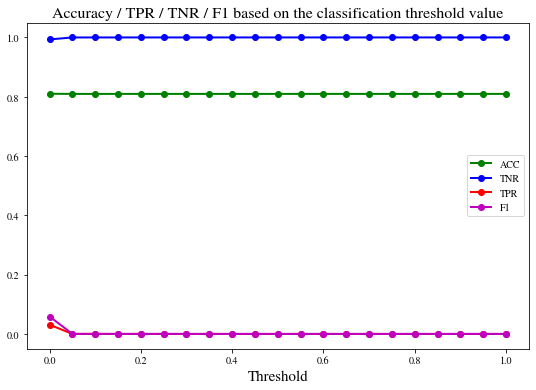

Chosen a default threshold...
Chosen classification threshold is: 0.65
Edge labels: number of positive: 525768
Predictions: number of positive: 4


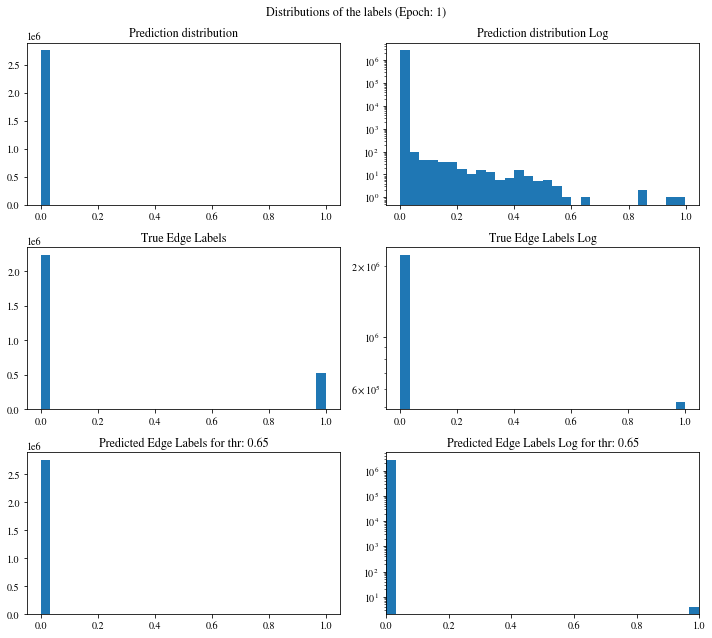

scores [0. 0. 0. ... 0. 0. 0.]
Confusion matrix:
[[2234927       3]
 [ 525767       1]]

Confusion matrix weighted:
[[4.99999329e-01 6.71161960e-07]
 [4.99999049e-01 9.50989790e-07]]

TN: 2234927 	 FN: 525767 	 TP: 1 	 FP: 3
Confusion matrix scaled:
[[8.09551425e-01 1.08668170e-06]
 [1.90447126e-01 3.62227234e-07]]

Accuracy: 0.8096
Precision: 0.2500
Negative predictive value: 0.8096
Recall: Correctly classifying 0.0002 % of positive edges
True negative rate: Correctly classifying 99.9999 % of all negative edges
F1 score: 0.0000
[0.50000014 0.58625205] [9.99998658e-01 1.90197958e-06] [6.66666493e-01 3.80394682e-06]
Balanced accuracy: 0.5000
Precision weighted: [0.50000014 0.58625205]
Recall weighted: [9.99998658e-01 1.90197958e-06]
F1 score weighted: [6.66666493e-01 3.80394682e-06]
positive_likelihood_ratio: 1.4169304078351415, negative_likelihood_ratio: 0.9999994403435891


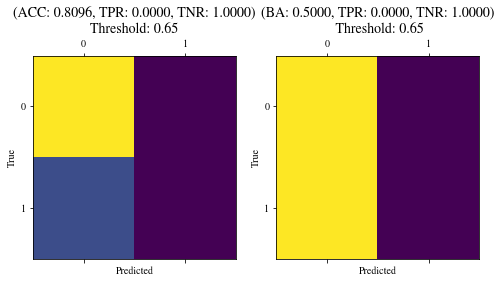

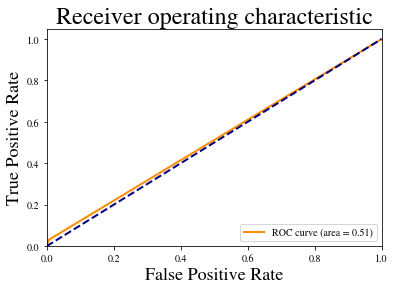

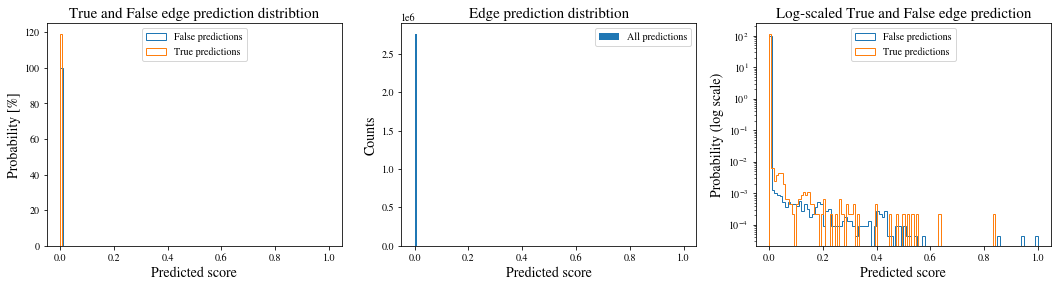

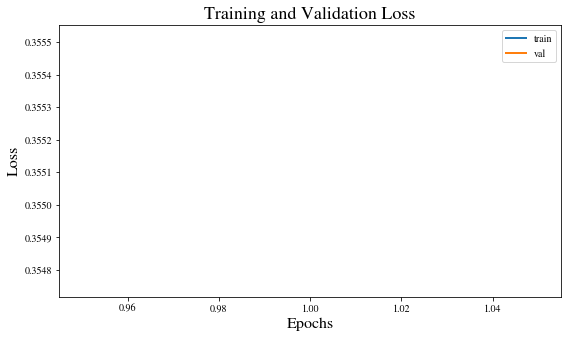

Training epoch 2:  10%|█         | 2/20 [00:00<00:01, 10.73it/s]

sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')


Training epoch 2:  20%|██        | 4/20 [00:00<00:01,  8.76it/s]

sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')


Training epoch 2:  30%|███       | 6/20 [00:00<00:01,  9.93it/s]

sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Training epoch 2:  40%|████      | 8/20 [00:00<00:01,  9.48it/s]

sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')


Training epoch 2:  50%|█████     | 10/20 [00:01<00:01,  8.82it/s]

sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')


Training epoch 2:  55%|█████▌    | 11/20 [00:01<00:01,  8.56it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 2:  65%|██████▌   | 13/20 [00:01<00:00,  8.99it/s]

sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')


Training epoch 2:  80%|████████  | 16/20 [00:01<00:00,  9.14it/s]

sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')


Training epoch 2:  90%|█████████ | 18/20 [00:01<00:00, 10.35it/s]

sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')
sample.edge_index 

Training epoch 2: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')
Epoch: 2, train loss: 0.3520
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_2_loss_0.3520.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]


pred [0. 0. 0. ... 0. 0. 0.]
Epoch: 2, val loss: 0.3420


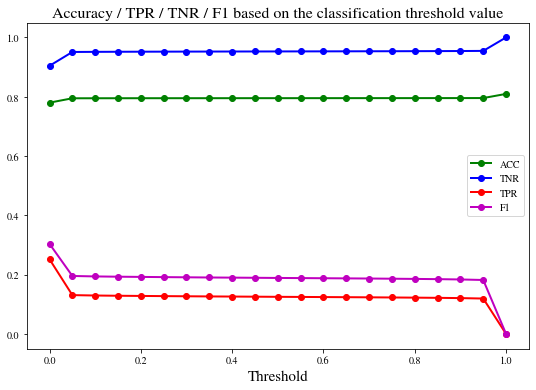

Chosen a default threshold...
Chosen classification threshold is: 0.65
Edge labels: number of positive: 525768
Predictions: number of positive: 169812


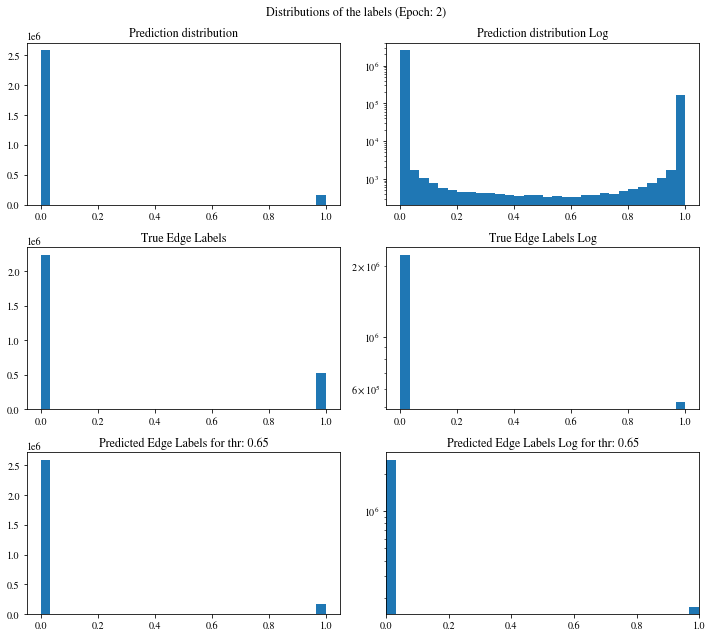

scores [0. 0. 0. ... 0. 0. 0.]
Confusion matrix:
[[2130292  104638]
 [ 460594   65174]]

Confusion matrix weighted:
[[0.47659032 0.02340968]
 [0.43802019 0.06197981]]

TN: 2130292 	 FN: 460594 	 TP: 65174 	 FP: 104638
Confusion matrix scaled:
[[0.77164978 0.03790273]
 [0.16683969 0.0236078 ]]

Accuracy: 0.7953
Precision: 0.3838
Negative predictive value: 0.8222
Recall: Correctly classifying 12.3960 % of positive edges
True negative rate: Correctly classifying 95.3181 % of all negative edges
F1 score: 0.1874
[0.52108555 0.72584821] [0.95318064 0.12395962] [0.67381136 0.2117558 ]
Balanced accuracy: 0.5386
Precision weighted: [0.52108555 0.72584821]
Recall weighted: [0.95318064 0.12395962]
F1 score weighted: [0.67381136 0.2117558 ]
positive_likelihood_ratio: 2.647614319852659, negative_likelihood_ratio: 0.9190706873983743


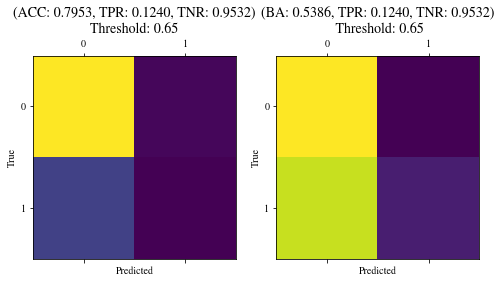

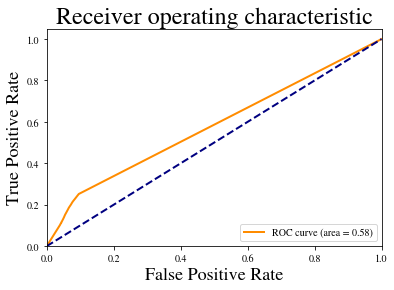

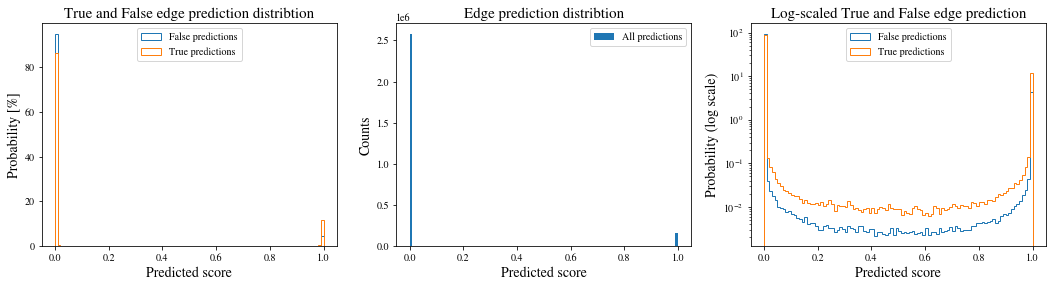

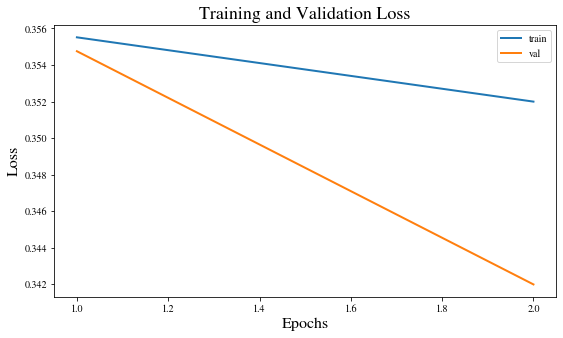

Training epoch 3:  10%|█         | 2/20 [00:00<00:01, 15.39it/s]

sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')


Training epoch 3:  20%|██        | 4/20 [00:00<00:01, 10.17it/s]

sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Training epoch 3:  30%|███       | 6/20 [00:00<00:01, 10.28it/s]

sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Training epoch 3:  40%|████      | 8/20 [00:00<00:01,  9.85it/s]

sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')


Training epoch 3:  50%|█████     | 10/20 [00:01<00:01,  9.14it/s]

sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')


Training epoch 3:  75%|███████▌  | 15/20 [00:01<00:00, 10.00it/s]

sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')


Training epoch 3:  85%|████████▌ | 17/20 [00:01<00:00,  9.60it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 3:  95%|█████████▌| 19/20 [00:01<00:00,  9.08it/s]

sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')


Training epoch 3: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')
Epoch: 3, train loss: 0.3415
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_3_loss_0.3415.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]


pred [0. 0. 0. ... 0. 1. 1.]
Epoch: 3, val loss: 0.3292


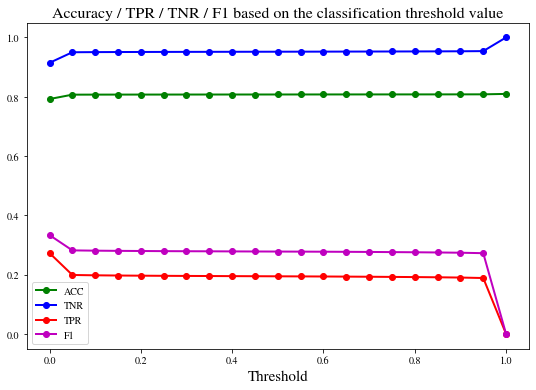

Chosen a default threshold...
Chosen classification threshold is: 0.65
Edge labels: number of positive: 525768
Predictions: number of positive: 208279


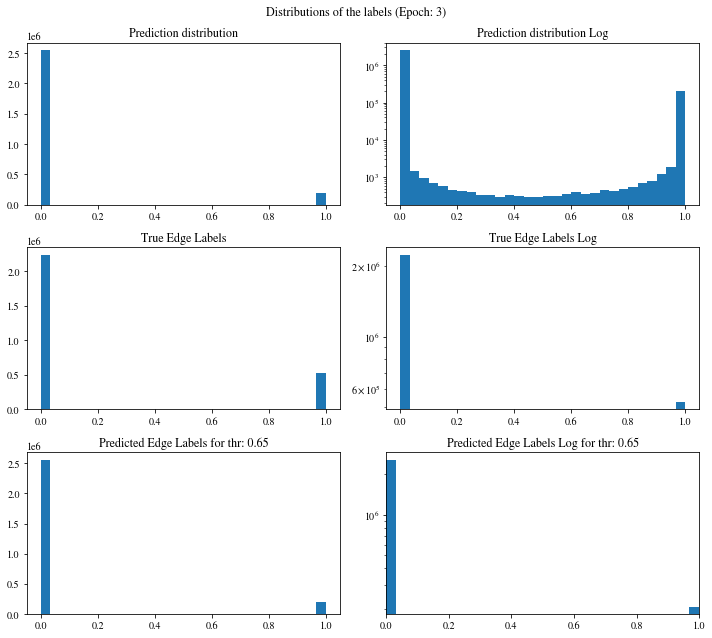

scores [0. 0. 0. ... 0. 1. 1.]
Confusion matrix:
[[2128305  106625]
 [ 424114  101654]]

Confusion matrix weighted:
[[0.47614579 0.02385421]
 [0.40332808 0.09667192]]

TN: 2128305 	 FN: 424114 	 TP: 101654 	 FP: 106625
Confusion matrix scaled:
[[0.77093003 0.03862248]
 [0.15362564 0.03682185]]

Accuracy: 0.8078
Precision: 0.4881
Negative predictive value: 0.8338
Recall: Correctly classifying 19.3344 % of positive edges
True negative rate: Correctly classifying 95.2292 % of all negative edges
F1 score: 0.2770
[0.54139845 0.80208263] [0.95229157 0.19334383] [0.69032955 0.31158048]
Balanced accuracy: 0.5728
Precision weighted: [0.54139845 0.80208263]
Recall weighted: [0.95229157 0.19334383]
F1 score weighted: [0.69032955 0.31158048]
positive_likelihood_ratio: 4.0526136556550565, negative_likelihood_ratio: 0.8470684741922702


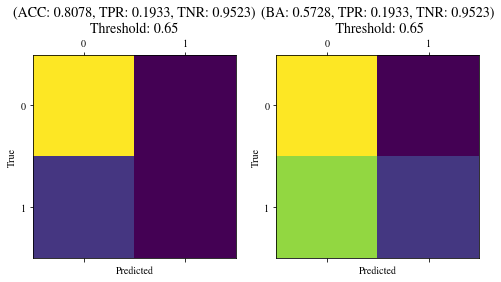

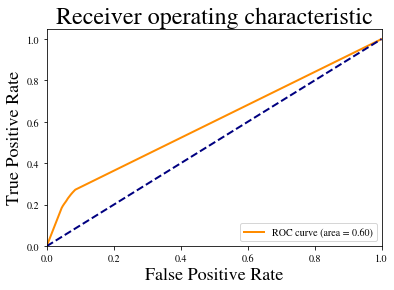

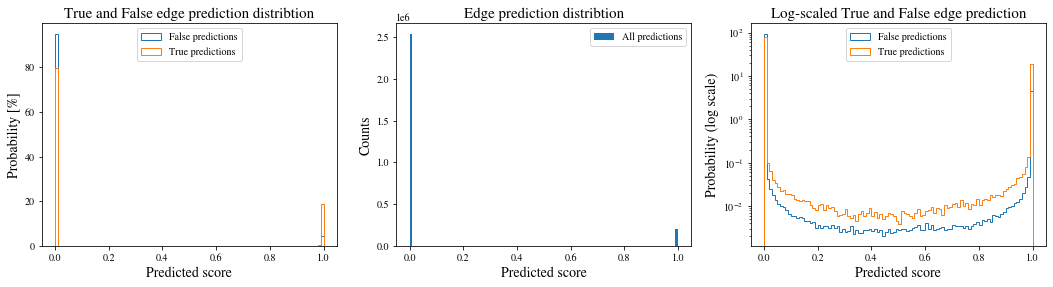

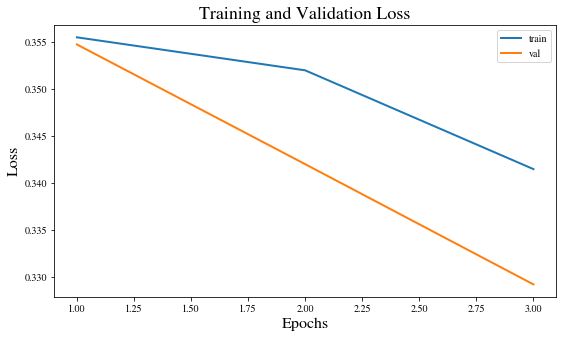

Training epoch 4:  10%|█         | 2/20 [00:00<00:01, 14.95it/s]

sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')


Training epoch 4:  20%|██        | 4/20 [00:00<00:01, 13.08it/s]

sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')


Training epoch 4:  30%|███       | 6/20 [00:00<00:01, 12.16it/s]

sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')
sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')


Training epoch 4:  40%|████      | 8/20 [00:00<00:01, 11.14it/s]

sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')


Training epoch 4:  50%|█████     | 10/20 [00:00<00:00, 10.65it/s]

sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Training epoch 4:  65%|██████▌   | 13/20 [00:01<00:00,  9.48it/s]

sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 4:  75%|███████▌  | 15/20 [00:01<00:00,  8.34it/s]

sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')
sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')


Training epoch 4:  85%|████████▌ | 17/20 [00:01<00:00,  8.48it/s]

sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')


Training epoch 4:  95%|█████████▌| 19/20 [00:01<00:00,  8.39it/s]

sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')


Training epoch 4: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')
Epoch: 4, train loss: 0.3364
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_4_loss_0.3364.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


pred [0. 0. 0. ... 0. 0. 0.]
Epoch: 4, val loss: 0.3356


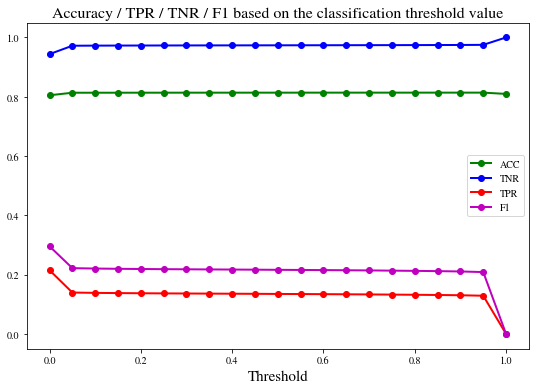

Chosen a default threshold...
Chosen classification threshold is: 0.65
Edge labels: number of positive: 525768
Predictions: number of positive: 128892


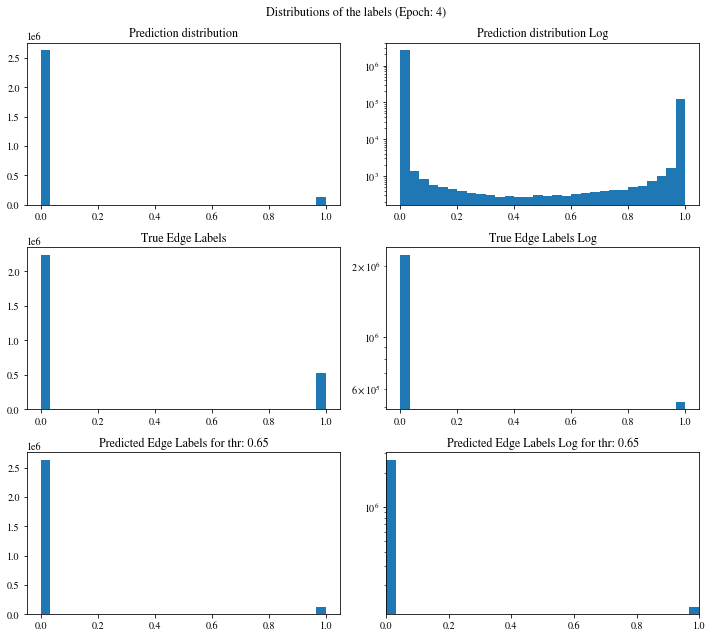

scores [0. 0. 0. ... 0. 0. 0.]
Confusion matrix:
[[2176360   58570]
 [ 455446   70322]]

Confusion matrix weighted:
[[0.48689668 0.01310332]
 [0.4331245  0.0668755 ]]

TN: 2176360 	 FN: 455446 	 TP: 70322 	 FP: 58570
Confusion matrix scaled:
[[0.78833686 0.02121565]
 [0.16497494 0.02547254]]

Accuracy: 0.8138
Precision: 0.5456
Negative predictive value: 0.8269
Recall: Correctly classifying 13.3751 % of positive edges
True negative rate: Correctly classifying 97.3793 % of all negative edges
F1 score: 0.2148
[0.52922334 0.83616515] [0.97379336 0.13375101] [0.68575975 0.23061361]
Balanced accuracy: 0.5538
Precision weighted: [0.52922334 0.83616515]
Recall weighted: [0.97379336 0.13375101]
F1 score weighted: [0.68575975 0.23061361]
positive_likelihood_ratio: 5.103707365875849, negative_likelihood_ratio: 0.889561405089531


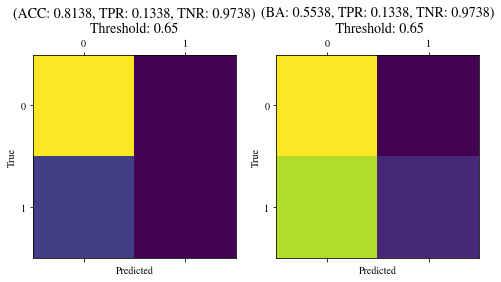

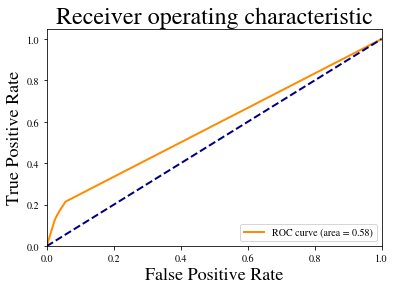

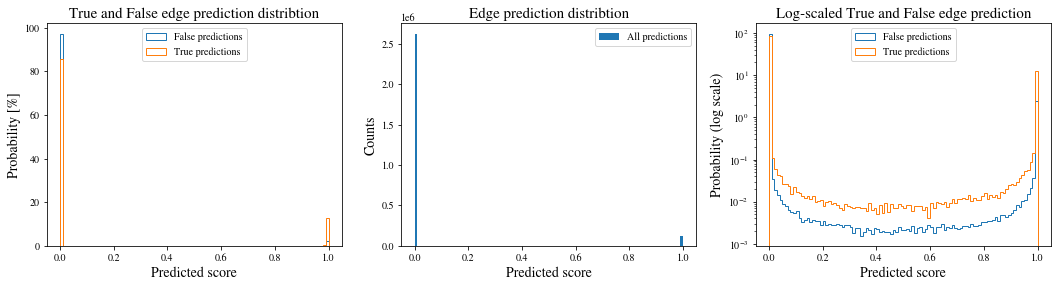

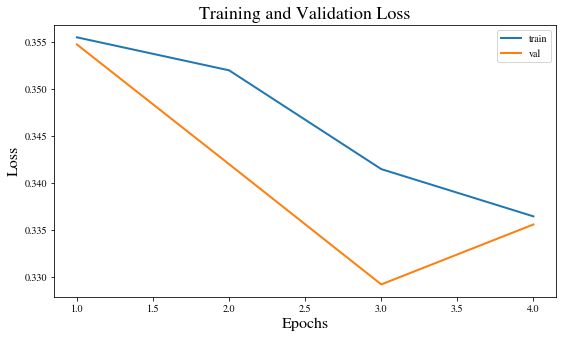

Training epoch 5:  10%|█         | 2/20 [00:00<00:01, 16.46it/s]

sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')


Training epoch 5:  20%|██        | 4/20 [00:00<00:01, 10.48it/s]

sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')


Training epoch 5:  30%|███       | 6/20 [00:00<00:01,  9.49it/s]

sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Training epoch 5:  40%|████      | 8/20 [00:00<00:01,  9.33it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')


Training epoch 5:  50%|█████     | 10/20 [00:00<00:00, 10.46it/s]

sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 5:  60%|██████    | 12/20 [00:01<00:00,  9.63it/s]

sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')


Training epoch 5:  80%|████████  | 16/20 [00:01<00:00,  9.93it/s]

sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Training epoch 5:  90%|█████████ | 18/20 [00:01<00:00,  9.58it/s]

sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')


Training epoch 5: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]

sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Epoch: 5, train loss: 0.3338
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_5_loss_0.3338.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]


pred [0. 0. 0. ... 0. 1. 1.]
Epoch: 5, val loss: 0.3226


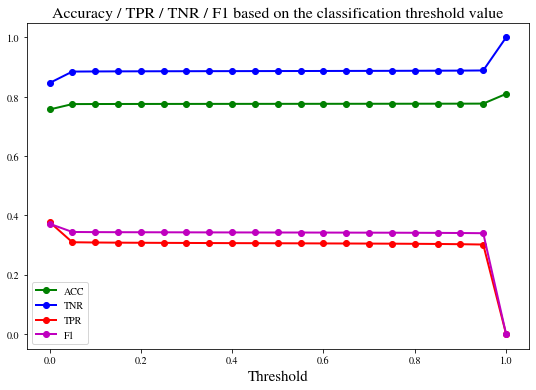

Chosen a default threshold...
Chosen classification threshold is: 0.65
Edge labels: number of positive: 525768
Predictions: number of positive: 412883


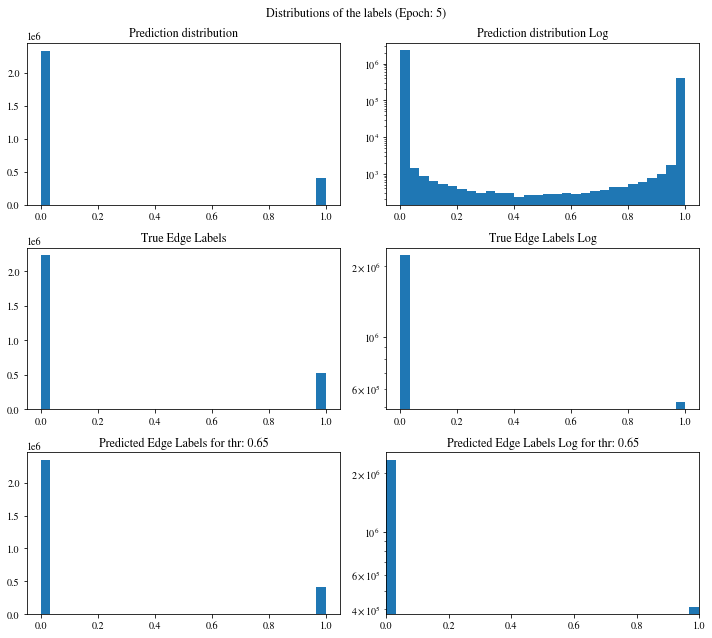

scores [0. 0. 0. ... 0. 1. 1.]
Confusion matrix:
[[1982427  252503]
 [ 365388  160380]]

Confusion matrix weighted:
[[0.44350986 0.05649014]
 [0.34748026 0.15251974]]

TN: 1982427 	 FN: 365388 	 TP: 160380 	 FP: 252503
Confusion matrix scaled:
[[0.71808905 0.09146346]
 [0.13235348 0.058094  ]]

Accuracy: 0.7762
Precision: 0.3884
Negative predictive value: 0.8444
Recall: Correctly classifying 30.5039 % of positive edges
True negative rate: Correctly classifying 88.7020 % of all negative edges
F1 score: 0.3417
[0.56070215 0.72972504] [0.88701973 0.30503949] [0.68708483 0.43023305]
Balanced accuracy: 0.5960
Precision weighted: [0.56070215 0.72972504]
Recall weighted: [0.88701973 0.30503949]
F1 score weighted: [0.68708483 0.43023305]
positive_likelihood_ratio: 2.699935828191348, negative_likelihood_ratio: 0.7834780819541906


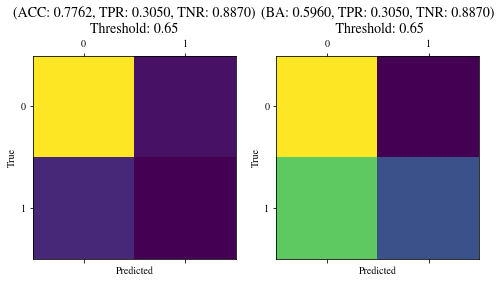

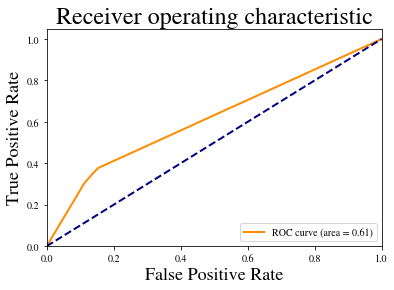

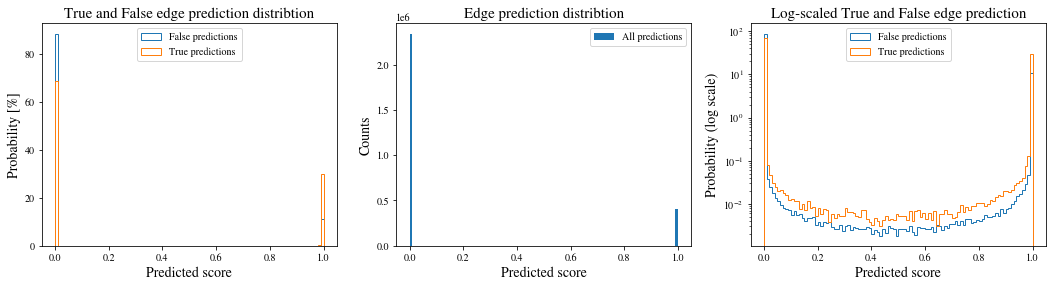

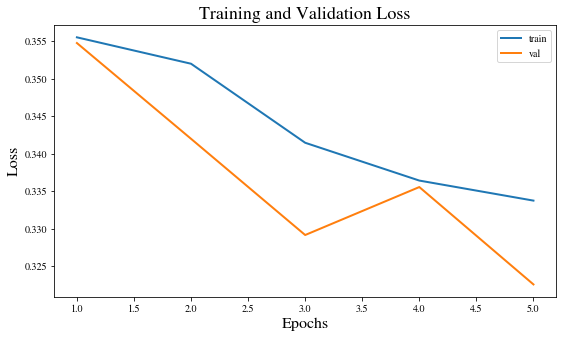

Training epoch 6:  10%|█         | 2/20 [00:00<00:01, 13.01it/s]

sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')


Training epoch 6:  20%|██        | 4/20 [00:00<00:01,  8.66it/s]

sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')


Training epoch 6:  30%|███       | 6/20 [00:00<00:01, 10.39it/s]

sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')


Training epoch 6:  40%|████      | 8/20 [00:00<00:01, 10.09it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Training epoch 6:  50%|█████     | 10/20 [00:01<00:01,  9.78it/s]

sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 6:  60%|██████    | 12/20 [00:01<00:00,  9.79it/s]

sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')


Training epoch 6:  75%|███████▌  | 15/20 [00:01<00:00,  9.03it/s]

sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Training epoch 6:  85%|████████▌ | 17/20 [00:01<00:00,  8.84it/s]

sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')


Training epoch 6:  90%|█████████ | 18/20 [00:01<00:00,  8.83it/s]

sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')
sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')


Training epoch 6: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


Epoch: 6, train loss: 0.3263
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_6_loss_0.3263.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.11it/s]


pred [0. 0. 0. ... 0. 0. 0.]
Epoch: 6, val loss: 0.3188


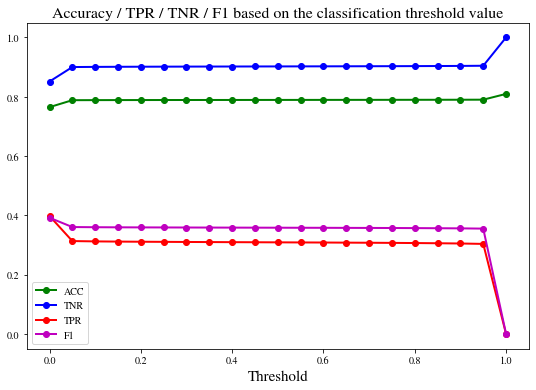

Chosen a default threshold...
Chosen classification threshold is: 0.65
Edge labels: number of positive: 525768
Predictions: number of positive: 379384


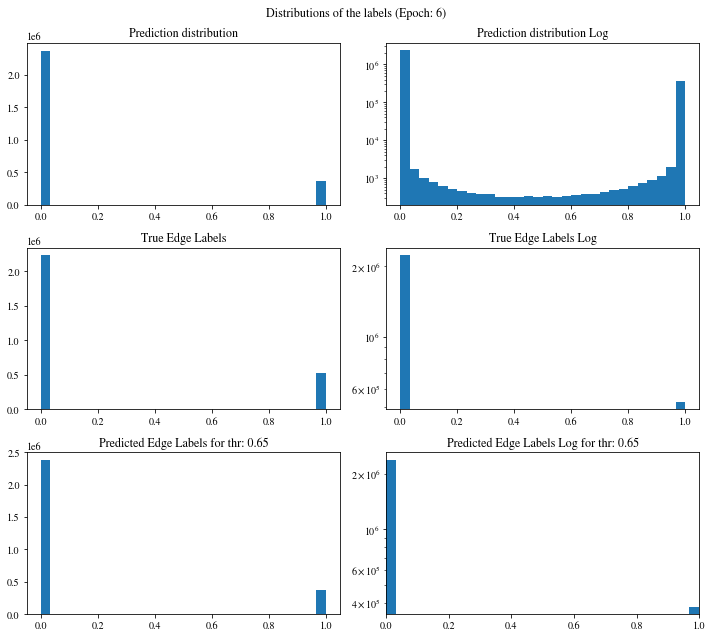

scores [0. 0. 0. ... 0. 0. 0.]
Confusion matrix:
[[2017444  217486]
 [ 363870  161898]]

Confusion matrix weighted:
[[0.45134389 0.04865611]
 [0.34603665 0.15396335]]

TN: 2017444 	 FN: 363870 	 TP: 161898 	 FP: 217486
Confusion matrix scaled:
[[0.73077316 0.07877935]
 [0.13180362 0.05864386]]

Accuracy: 0.7894
Precision: 0.4267
Negative predictive value: 0.8472
Recall: Correctly classifying 30.7927 % of positive edges
True negative rate: Correctly classifying 90.2688 % of all negative edges
F1 score: 0.3577
[0.56603324 0.75986457] [0.90268778 0.30792669] [0.69577718 0.43825529]
Balanced accuracy: 0.6053
Precision weighted: [0.56603324 0.75986457]
Recall weighted: [0.90268778 0.30792669]
F1 score weighted: [0.69577718 0.43825529]
positive_likelihood_ratio: 3.1643167721282346, negative_likelihood_ratio: 0.7666807120777176


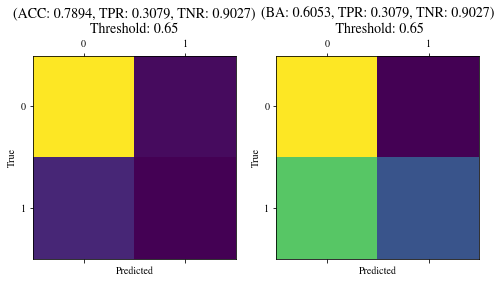

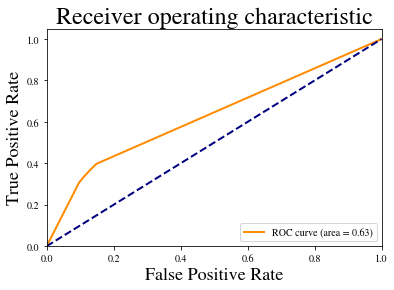

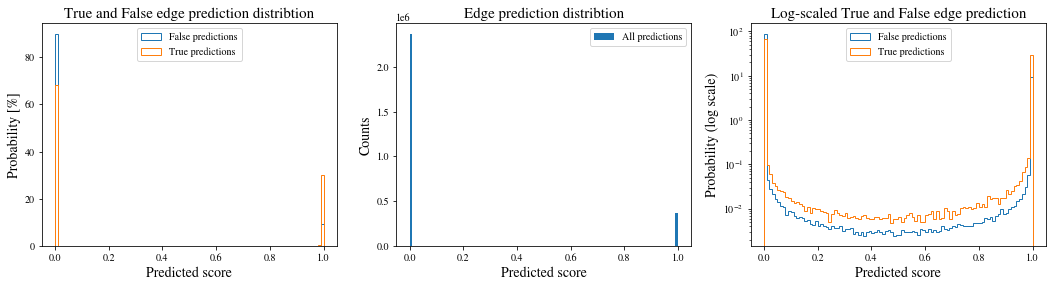

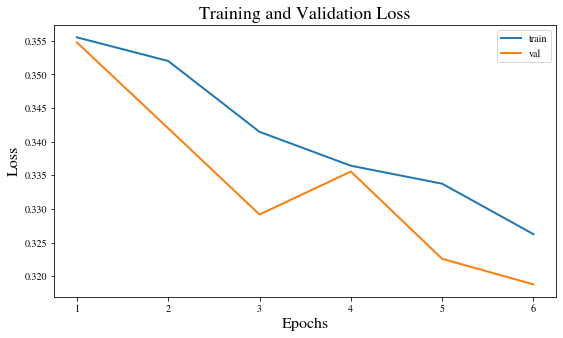

Training epoch 7:  10%|█         | 2/20 [00:00<00:01, 15.92it/s]

sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')


Training epoch 7:  20%|██        | 4/20 [00:00<00:01, 12.47it/s]

sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')


Training epoch 7:  30%|███       | 6/20 [00:00<00:01, 10.21it/s]

sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')


Training epoch 7:  40%|████      | 8/20 [00:00<00:01,  9.72it/s]

sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Training epoch 7:  60%|██████    | 12/20 [00:01<00:00,  9.76it/s]

sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')


Training epoch 7:  70%|███████   | 14/20 [00:01<00:00, 10.31it/s]

sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')
sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')


Training epoch 7:  85%|████████▌ | 17/20 [00:01<00:00,  8.95it/s]

sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')
sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')


Training epoch 7:  95%|█████████▌| 19/20 [00:01<00:00,  8.95it/s]

sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')


Training epoch 7: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')
Epoch: 7, train loss: 0.3225
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_7_loss_0.3225.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.15it/s]


pred [0. 0. 0. ... 0. 0. 0.]
Epoch: 7, val loss: 0.3177


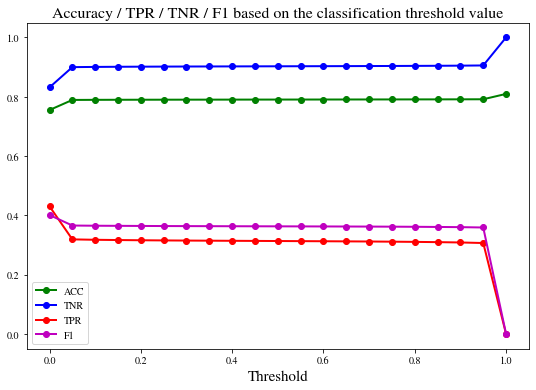

Chosen a default threshold...
Chosen classification threshold is: 0.65
Edge labels: number of positive: 525768
Predictions: number of positive: 380340


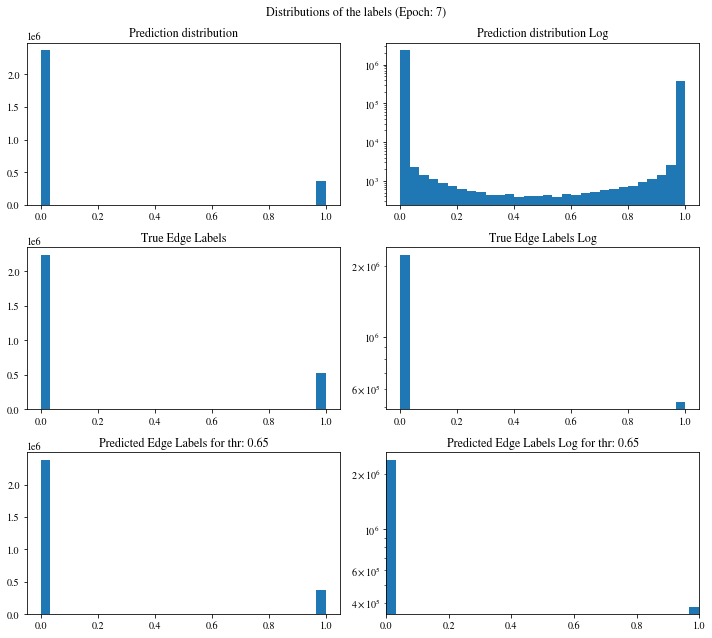

scores [0. 0. 0. ... 0. 0. 0.]
Confusion matrix:
[[2018741  216189]
 [ 361617  164151]]

Confusion matrix weighted:
[[0.45163406 0.04836594]
 [0.34389407 0.15610593]]

TN: 2018741 	 FN: 361617 	 TP: 164151 	 FP: 216189
Confusion matrix scaled:
[[0.73124297 0.07830954]
 [0.13098753 0.05945996]]

Accuracy: 0.7907
Precision: 0.4316
Negative predictive value: 0.8481
Recall: Correctly classifying 31.2212 % of positive edges
True negative rate: Correctly classifying 90.3268 % of all negative edges
F1 score: 0.3623
[0.56771601 0.76345918] [0.90326811 0.31221185] [0.69721999 0.44318569]
Balanced accuracy: 0.6077
Precision weighted: [0.56771601 0.76345918]
Recall weighted: [0.90326811 0.31221185]
F1 score weighted: [0.69721999 0.44318569]
positive_likelihood_ratio: 3.227600063507574, negative_likelihood_ratio: 0.7614440732468212


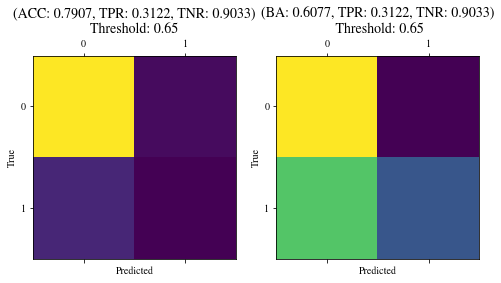

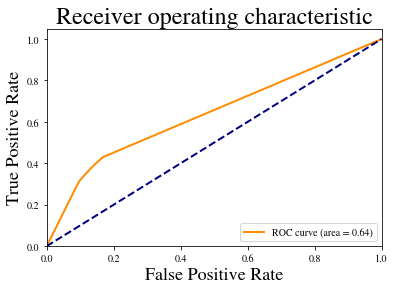

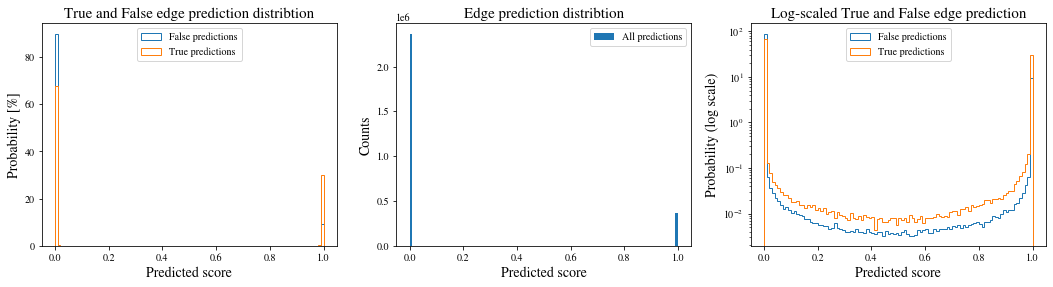

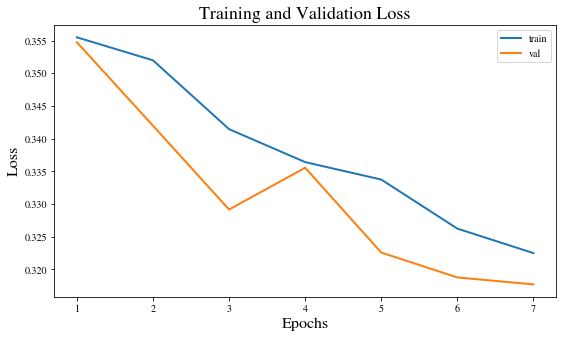

Training epoch 8:  10%|█         | 2/20 [00:00<00:01, 13.02it/s]

sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Training epoch 8:  20%|██        | 4/20 [00:00<00:01,  9.74it/s]

sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 8:  30%|███       | 6/20 [00:00<00:01, 10.00it/s]

sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 8:  40%|████      | 8/20 [00:00<00:01, 10.34it/s]

sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')


Training epoch 8:  50%|█████     | 10/20 [00:01<00:01,  9.27it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')
sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')


Training epoch 8:  70%|███████   | 14/20 [00:01<00:00,  9.44it/s]

sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')
sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')


Training epoch 8:  80%|████████  | 16/20 [00:01<00:00,  9.90it/s]

sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')


Training epoch 8:  90%|█████████ | 18/20 [00:01<00:00,  8.71it/s]

sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')


Training epoch 8: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
Epoch: 8, train loss: 0.3174
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_8_loss_0.3174.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.29it/s]


pred [0.00000000e+00 1.00000000e+00 1.00000000e+00 ... 9.04602408e-01
 3.34370387e-04 7.84252346e-01]
Epoch: 8, val loss: 0.3200


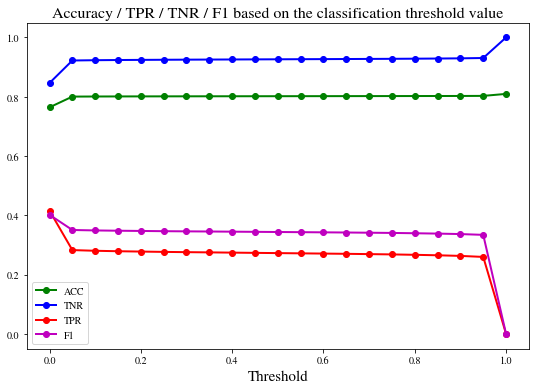

Chosen a default threshold...
Chosen classification threshold is: 0.65
Edge labels: number of positive: 525768
Predictions: number of positive: 304791


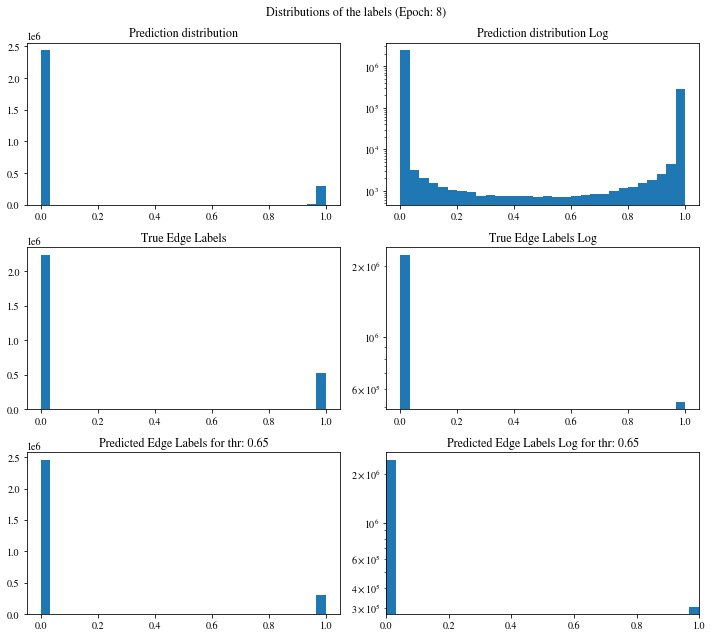

scores [0.00000000e+00 1.00000000e+00 1.00000000e+00 ... 9.04602408e-01
 3.34370387e-04 7.84252346e-01]
Confusion matrix:
[[2072209  162721]
 [ 383698  142070]]

Confusion matrix weighted:
[[0.46359595 0.03640405]
 [0.36489288 0.13510712]]

TN: 2072209 	 FN: 383698 	 TP: 142070 	 FP: 162721
Confusion matrix scaled:
[[0.75061053 0.05894198]
 [0.13898587 0.05146162]]

Accuracy: 0.8021
Precision: 0.4661
Negative predictive value: 0.8438
Recall: Correctly classifying 27.0214 % of positive edges
True negative rate: Correctly classifying 92.7192 % of all negative edges
F1 score: 0.3421
[0.55956814 0.78774532] [0.9271919  0.27021424] [0.69792977 0.40239724]
Balanced accuracy: 0.5987
Precision weighted: [0.55956814 0.78774532]
Recall weighted: [0.9271919  0.27021424]
F1 score weighted: [0.69792977 0.40239724]
positive_likelihood_ratio: 3.711321274595262, negative_likelihood_ratio: 0.7870924655170325


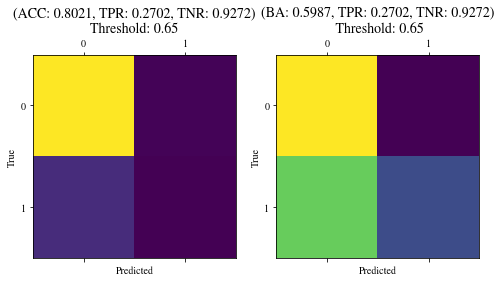

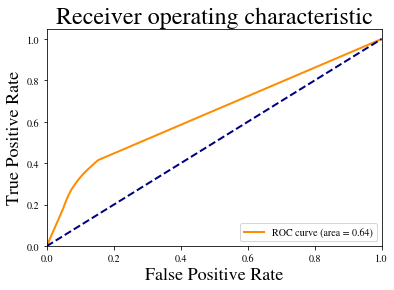

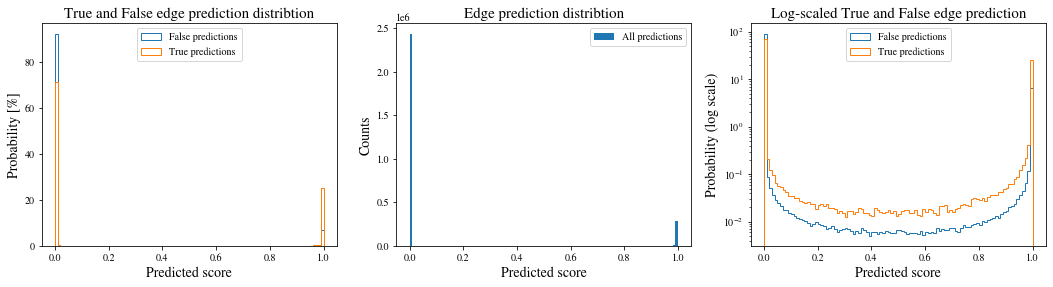

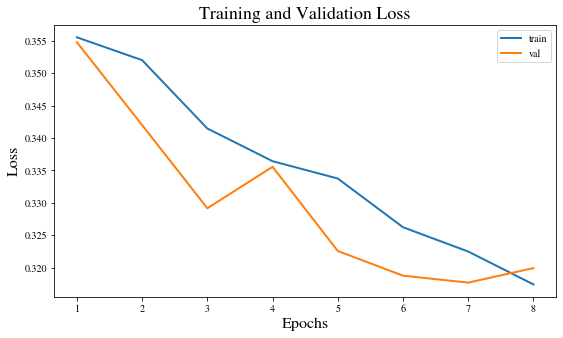

Training epoch 9:  10%|█         | 2/20 [00:00<00:01, 11.94it/s]

sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')
sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')


Training epoch 9:  20%|██        | 4/20 [00:00<00:01,  8.80it/s]

sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')


Training epoch 9:  30%|███       | 6/20 [00:00<00:01,  8.96it/s]

sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')


Training epoch 9:  50%|█████     | 10/20 [00:01<00:00, 10.37it/s]

sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')


Training epoch 9:  60%|██████    | 12/20 [00:01<00:00, 10.52it/s]

sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Training epoch 9:  70%|███████   | 14/20 [00:01<00:00,  9.86it/s]

sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Training epoch 9:  80%|████████  | 16/20 [00:01<00:00,  9.02it/s]

sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')


Training epoch 9:  85%|████████▌ | 17/20 [00:01<00:00,  9.17it/s]

sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')


Training epoch 9: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]

sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')
sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')


Epoch: 9, train loss: 0.3110
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_9_loss_0.3110.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.25it/s]


pred [0. 1. 1. ... 0. 0. 0.]
Epoch: 9, val loss: 0.3161


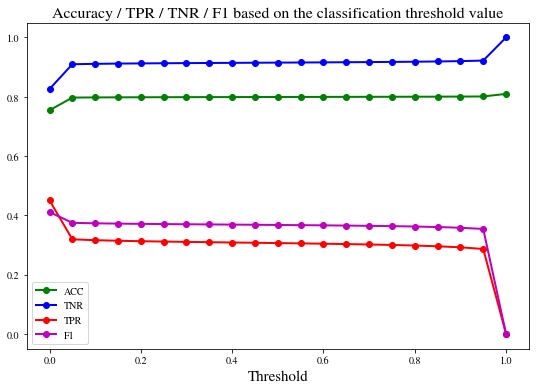

Chosen a default threshold...
Chosen classification threshold is: 0.65
Edge labels: number of positive: 525768
Predictions: number of positive: 346331


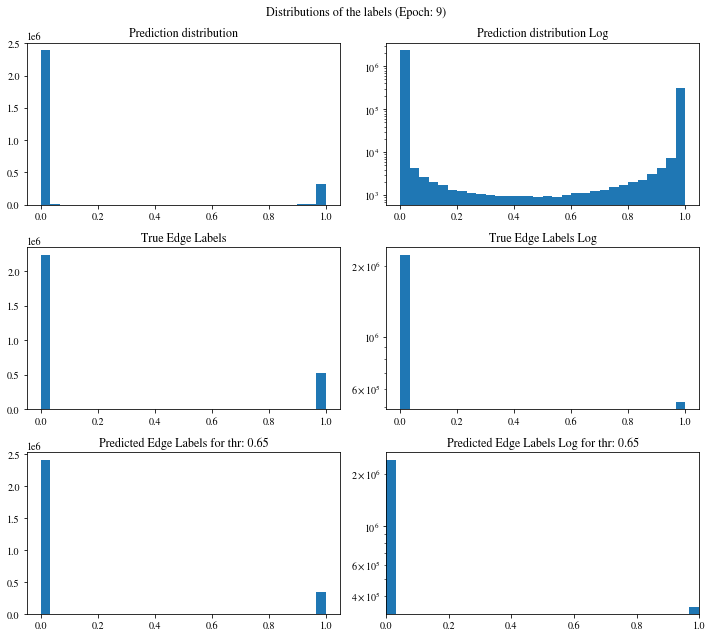

scores [0. 1. 1. ... 0. 0. 0.]
Confusion matrix:
[[2047963  186967]
 [ 366404  159364]]

Confusion matrix weighted:
[[0.45817162 0.04182838]
 [0.34844646 0.15155354]]

TN: 2047963 	 FN: 366404 	 TP: 159364 	 FP: 186967
Confusion matrix scaled:
[[0.74182797 0.06772454]
 [0.13272151 0.05772598]]

Accuracy: 0.7996
Precision: 0.4601
Negative predictive value: 0.8482
Recall: Correctly classifying 30.3107 % of positive edges
True negative rate: Correctly classifying 91.6343 % of all negative edges
F1 score: 0.3655
[0.56801556 0.78370067] [0.91634324 0.30310707] [0.70130917 0.43714303]
Balanced accuracy: 0.6097
Precision weighted: [0.56801556 0.78370067]
Recall weighted: [0.91634324 0.30310707]
F1 score weighted: [0.70130917 0.43714303]
positive_likelihood_ratio: 3.623222774835765, negative_likelihood_ratio: 0.7605151594327053


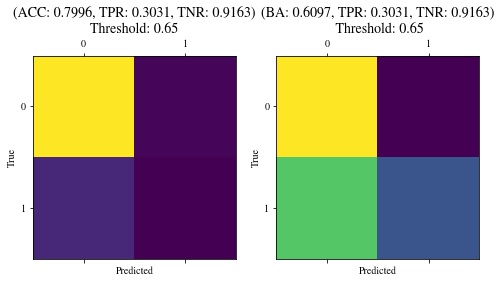

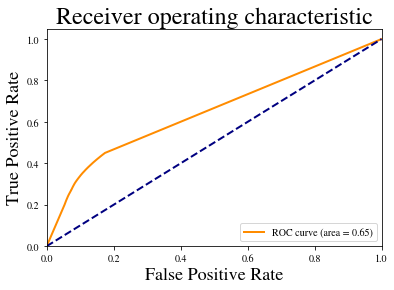

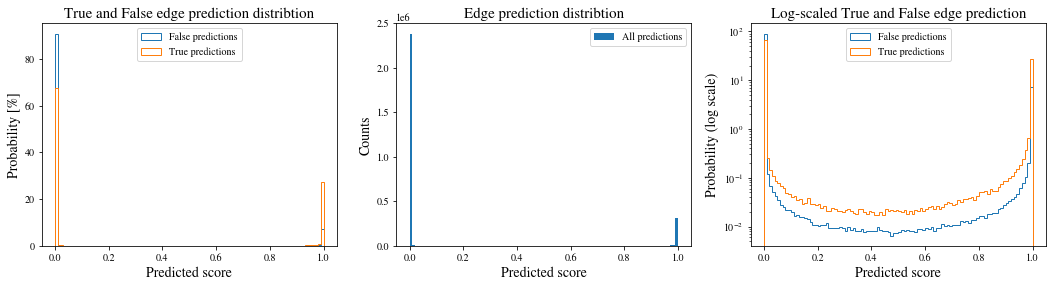

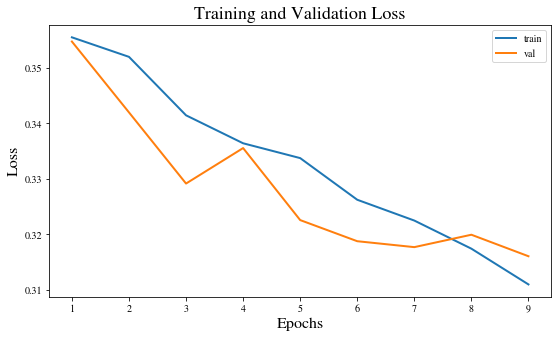

Training epoch 10:  10%|█         | 2/20 [00:00<00:01, 12.12it/s]

sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')
sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')


Training epoch 10:  20%|██        | 4/20 [00:00<00:01,  9.27it/s]

sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')


Training epoch 10:  40%|████      | 8/20 [00:00<00:01, 10.07it/s]

sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Training epoch 10:  50%|█████     | 10/20 [00:01<00:01,  9.75it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Training epoch 10:  60%|██████    | 12/20 [00:01<00:00,  9.25it/s]

sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 10:  70%|███████   | 14/20 [00:01<00:00,  9.93it/s]

sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')


Training epoch 10:  85%|████████▌ | 17/20 [00:01<00:00,  9.10it/s]

sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')
sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')


Training epoch 10:  95%|█████████▌| 19/20 [00:01<00:00,  9.56it/s]

sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 10: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
Epoch: 10, train loss: 0.3090
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_10_loss_0.3090.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.50it/s]


pred [0.99565071 0.99631631 0.9975642  ... 0.         0.         0.        ]
Epoch: 10, val loss: 0.3174


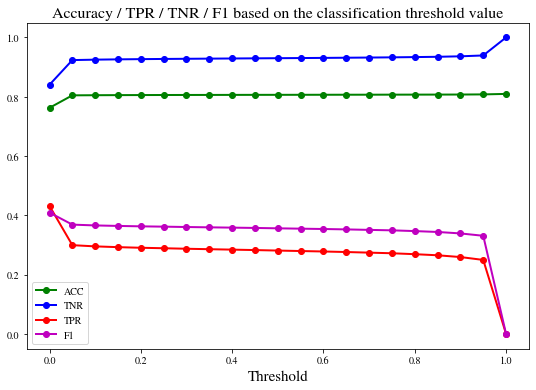

Chosen a default threshold...
Chosen classification threshold is: 0.65
Edge labels: number of positive: 525768
Predictions: number of positive: 298205


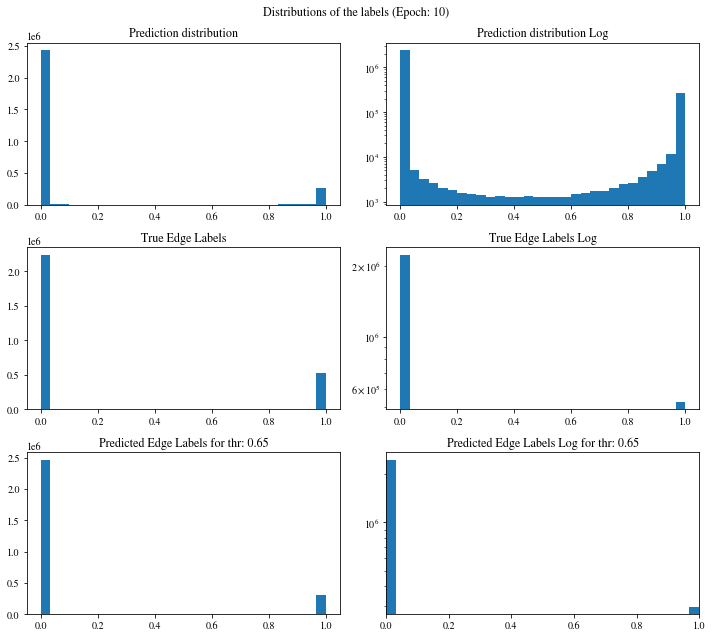

scores [0.99565071 0.99631631 0.9975642  ... 0.         0.         0.        ]
Confusion matrix:
[[2081983  152947]
 [ 380510  145258]]

Confusion matrix weighted:
[[0.4657826  0.0342174 ]
 [0.36186113 0.13813887]]

TN: 2081983 	 FN: 380510 	 TP: 145258 	 FP: 152947
Confusion matrix scaled:
[[0.75415094 0.05540157]
 [0.13783108 0.0526164 ]]

Accuracy: 0.8068
Precision: 0.4871
Negative predictive value: 0.8455
Recall: Correctly classifying 27.6278 % of positive edges
True negative rate: Correctly classifying 93.1565 % of all negative edges
F1 score: 0.3526
[0.56278153 0.80147284] [0.93156519 0.27627775] [0.70166806 0.41090975]
Balanced accuracy: 0.6039
Precision weighted: [0.56278153 0.80147284]
Recall weighted: [0.93156519 0.27627775]
F1 score weighted: [0.70166806 0.41090975]
positive_likelihood_ratio: 4.0370941015119675, negative_likelihood_ratio: 0.7768884608837099


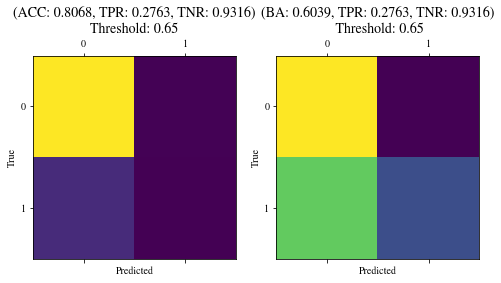

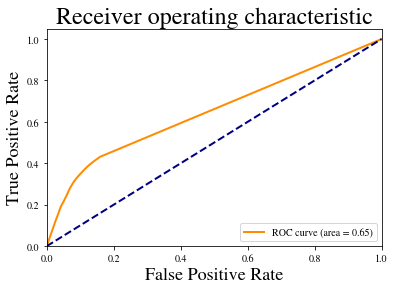

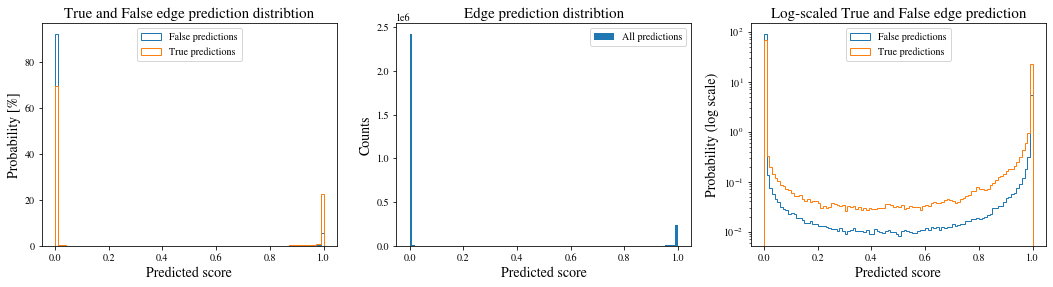

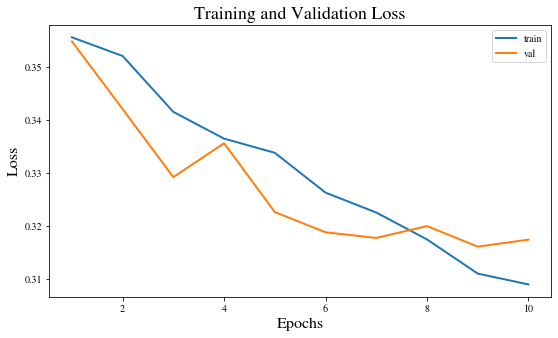

Training epoch 11:  10%|█         | 2/20 [00:00<00:01, 16.36it/s]

sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Training epoch 11:  20%|██        | 4/20 [00:00<00:01, 10.10it/s]

sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')


Training epoch 11:  30%|███       | 6/20 [00:00<00:01,  9.34it/s]

sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 11:  40%|████      | 8/20 [00:00<00:01,  8.35it/s]

sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')


Training epoch 11:  55%|█████▌    | 11/20 [00:01<00:00,  9.49it/s]

sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')


Training epoch 11:  60%|██████    | 12/20 [00:01<00:00,  9.12it/s]

sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')


Training epoch 11:  70%|███████   | 14/20 [00:01<00:00,  8.94it/s]

sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Training epoch 11:  80%|████████  | 16/20 [00:01<00:00,  8.89it/s]

sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 11: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]

sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')


Epoch: 11, train loss: 0.3078
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_11_loss_0.3078.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.61it/s]


pred [0. 0. 0. ... 0. 0. 0.]
Epoch: 11, val loss: 0.3102


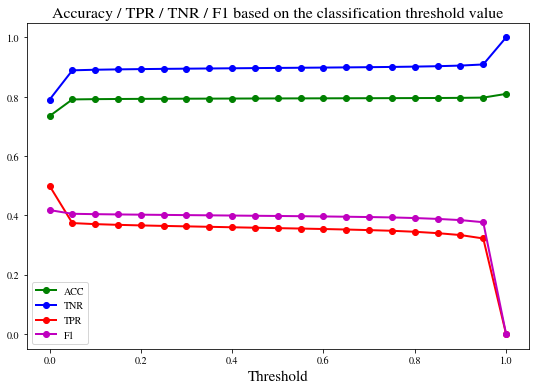

Chosen a default threshold...
Chosen classification threshold is: 0.65
Edge labels: number of positive: 525768
Predictions: number of positive: 410926


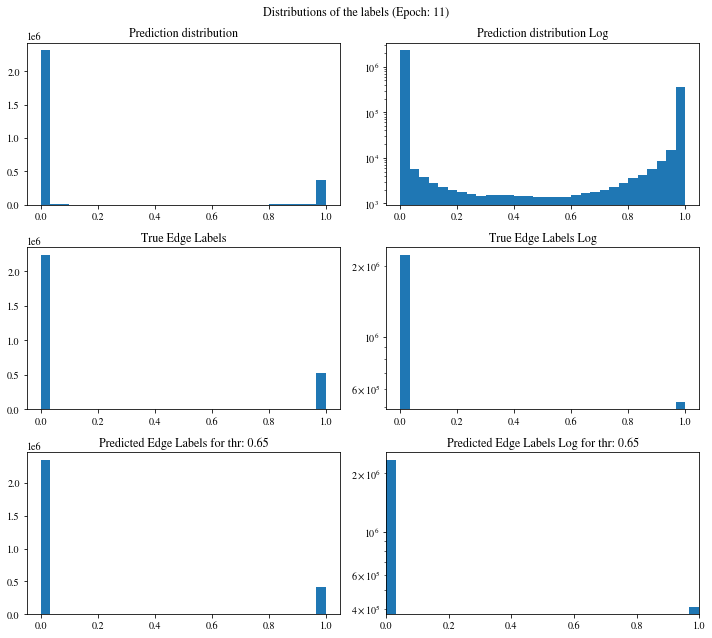

scores [0. 0. 0. ... 0. 0. 0.]
Confusion matrix:
[[2009159  225771]
 [ 340613  185155]]

Confusion matrix weighted:
[[0.44949036 0.05050964]
 [0.32391949 0.17608051]]

TN: 2009159 	 FN: 340613 	 TP: 185155 	 FP: 225771
Confusion matrix scaled:
[[0.72777211 0.0817804 ]
 [0.1233793  0.06706818]]

Accuracy: 0.7948
Precision: 0.4506
Negative predictive value: 0.8550
Recall: Correctly classifying 35.2161 % of positive edges
True negative rate: Correctly classifying 89.8981 % of all negative edges
F1 score: 0.3953
[0.58118004 0.77708812] [0.89898073 0.35216103] [0.70596339 0.4846763 ]
Balanced accuracy: 0.6256
Precision weighted: [0.58118004 0.77708812]
Recall weighted: [0.89898073 0.35216103]
F1 score weighted: [0.70596339 0.4846763 ]
positive_likelihood_ratio: 3.4860777025753835, negative_likelihood_ratio: 0.7206372173689853


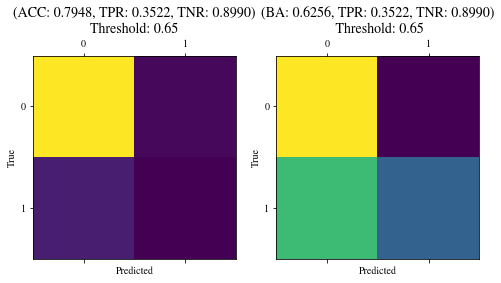

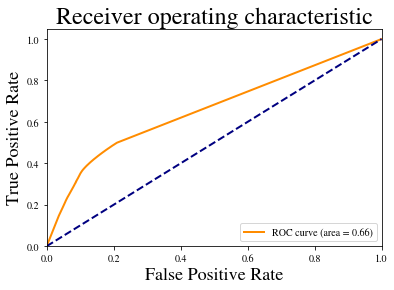

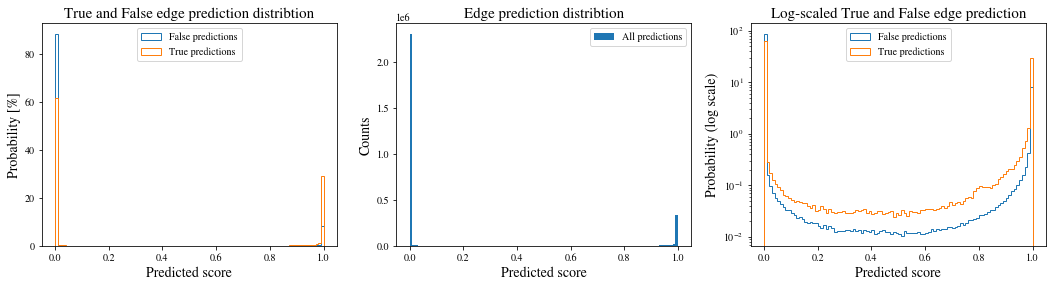

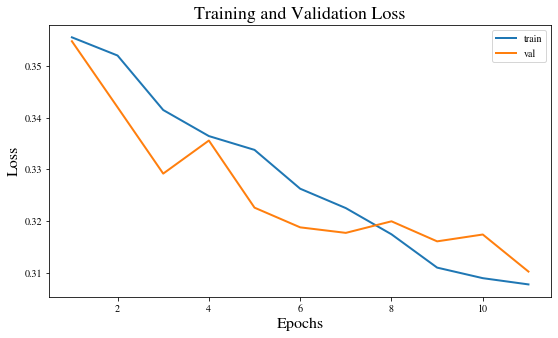

Training epoch 12:  10%|█         | 2/20 [00:00<00:01, 13.22it/s]

sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')


Training epoch 12:  20%|██        | 4/20 [00:00<00:01, 10.43it/s]

sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Training epoch 12:  30%|███       | 6/20 [00:00<00:01,  9.86it/s]

sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')


Training epoch 12:  40%|████      | 8/20 [00:00<00:01, 10.10it/s]

sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')


Training epoch 12:  60%|██████    | 12/20 [00:01<00:00, 10.56it/s]

sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 12:  70%|███████   | 14/20 [00:01<00:00,  9.44it/s]

sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')


Training epoch 12:  85%|████████▌ | 17/20 [00:01<00:00,  9.63it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')


Training epoch 12:  90%|█████████ | 18/20 [00:01<00:00,  9.06it/s]

sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')


Training epoch 12: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]

sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')
Epoch: 12, train loss: 0.3057
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_12_loss_0.3057.pt


Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.51it/s]


pred [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 4.92517832e-11 7.17322428e-06]
Epoch: 12, val loss: 0.3123


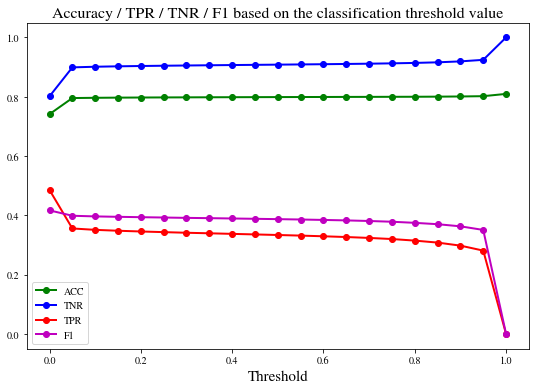

Chosen a default threshold...
Chosen classification threshold is: 0.65
Edge labels: number of positive: 525768
Predictions: number of positive: 371754


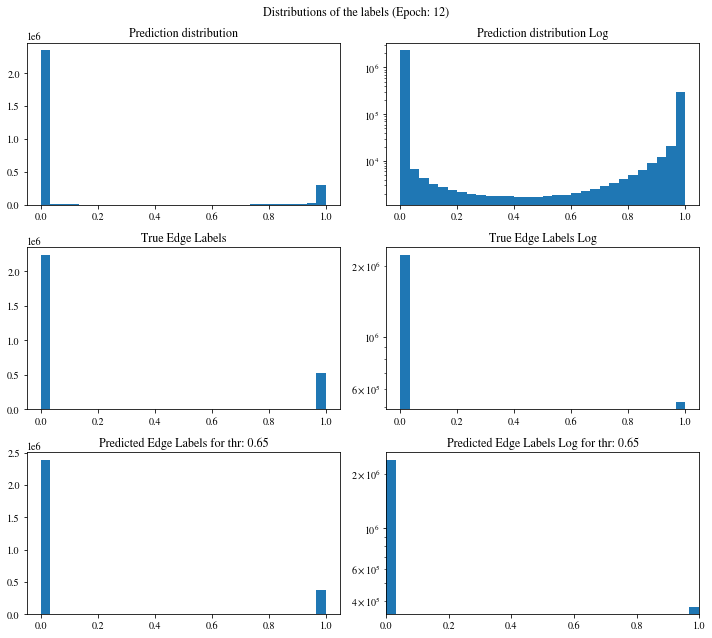

scores [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 4.92517832e-11 7.17322428e-06]
Confusion matrix:
[[2035016  199914]
 [ 353928  171840]]

Confusion matrix weighted:
[[0.45527511 0.04472489]
 [0.33658191 0.16341809]]

TN: 2035016 	 FN: 353928 	 TP: 171840 	 FP: 199914
Confusion matrix scaled:
[[0.73713822 0.0724143 ]
 [0.12820236 0.06224513]]

Accuracy: 0.7994
Precision: 0.4622
Negative predictive value: 0.8518
Recall: Correctly classifying 32.6836 % of positive edges
True negative rate: Correctly classifying 91.0550 % of all negative edges
F1 score: 0.3829
[0.5749461  0.78512419] [0.91055022 0.32683617] [0.70483823 0.4615398 ]
Balanced accuracy: 0.6187
Precision weighted: [0.5749461  0.78512419]
Recall weighted: [0.91055022 0.32683617]
F1 score weighted: [0.70483823 0.4615398 ]
positive_likelihood_ratio: 3.6538509751551773, negative_likelihood_ratio: 0.7392934680380046


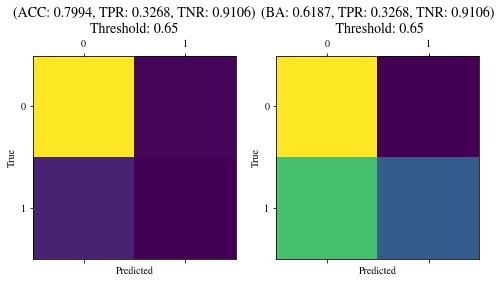

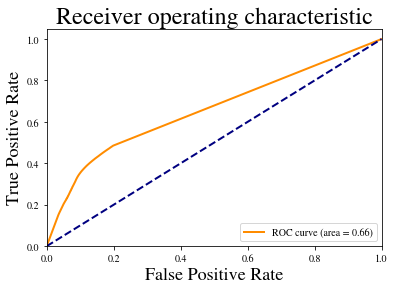

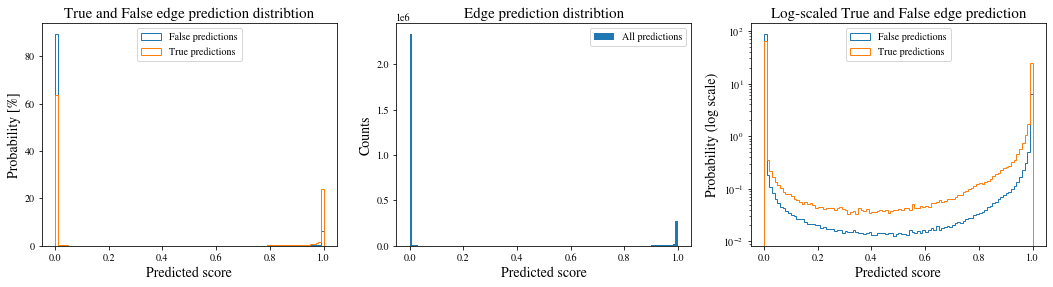

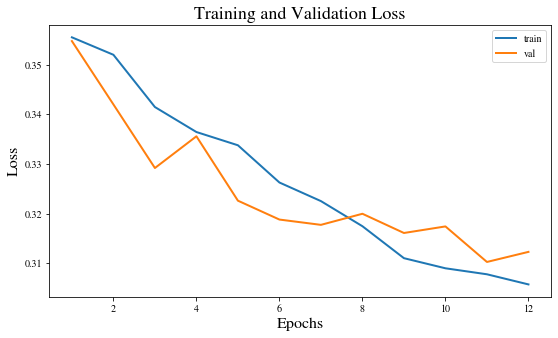

Training epoch 13:  10%|█         | 2/20 [00:00<00:01, 16.05it/s]

sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')


Training epoch 13:  20%|██        | 4/20 [00:00<00:01,  8.80it/s]

sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')


Training epoch 13:  30%|███       | 6/20 [00:00<00:01,  9.46it/s]

sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 13:  40%|████      | 8/20 [00:00<00:01,  9.55it/s]

sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')


Training epoch 13:  50%|█████     | 10/20 [00:01<00:01,  9.22it/s]

sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 13:  55%|█████▌    | 11/20 [00:01<00:00,  9.09it/s]

sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')


Training epoch 13:  75%|███████▌  | 15/20 [00:01<00:00, 10.47it/s]

sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Training epoch 13:  85%|████████▌ | 17/20 [00:01<00:00,  9.60it/s]

sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')


Training epoch 13: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Epoch: 13, train loss: 0.3054
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_13_loss_0.3054.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.08it/s]


pred [0. 0. 0. ... 0. 0. 0.]
Epoch: 13, val loss: 0.3100


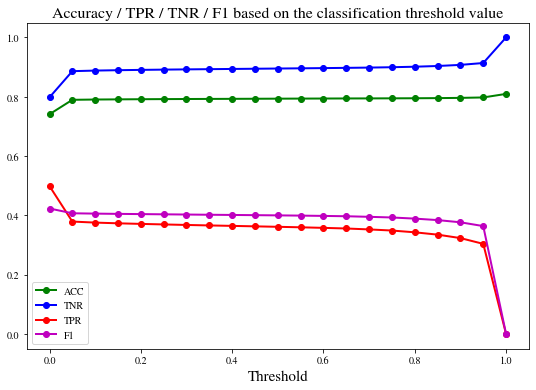

Chosen a default threshold...
Chosen classification threshold is: 0.65
Edge labels: number of positive: 525768
Predictions: number of positive: 416355


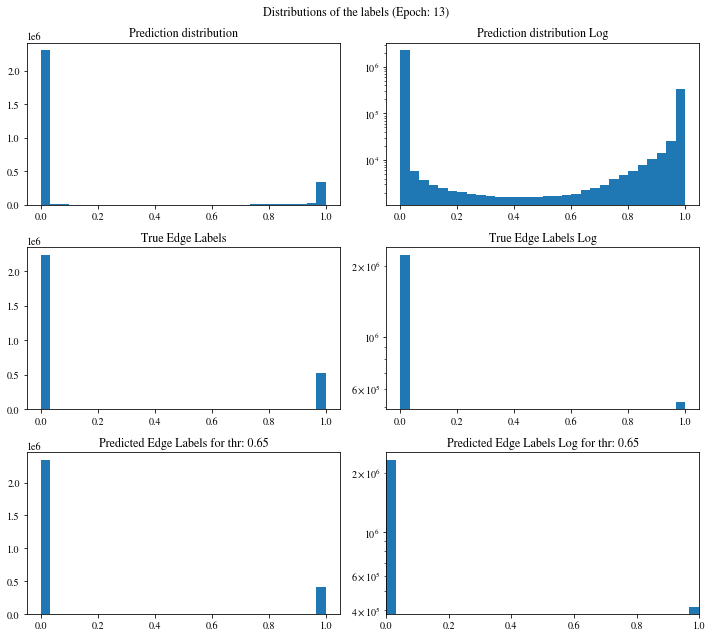

scores [0. 0. 0. ... 0. 0. 0.]
Confusion matrix:
[[2005560  229370]
 [ 338783  186985]]

Confusion matrix weighted:
[[0.44868519 0.05131481]
 [0.32217917 0.17782083]]

TN: 2005560 	 FN: 338783 	 TP: 186985 	 FP: 229370
Confusion matrix scaled:
[[0.72646845 0.08308406]
 [0.12271643 0.06773106]]

Accuracy: 0.7942
Precision: 0.4491
Negative predictive value: 0.8555
Recall: Correctly classifying 35.5642 % of positive edges
True negative rate: Correctly classifying 89.7370 % of all negative edges
F1 score: 0.3969
[0.58205466 0.77605052] [0.89737039 0.35564165] [0.70611027 0.48775788]
Balanced accuracy: 0.6265
Precision weighted: [0.58205466 0.77605052]
Recall weighted: [0.89737039 0.35564165]
F1 score weighted: [0.70611027 0.48775788]
positive_likelihood_ratio: 3.46529274502839, negative_likelihood_ratio: 0.7180517177610434


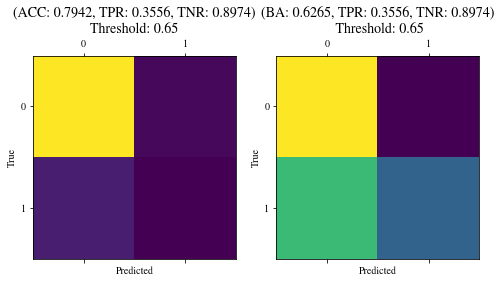

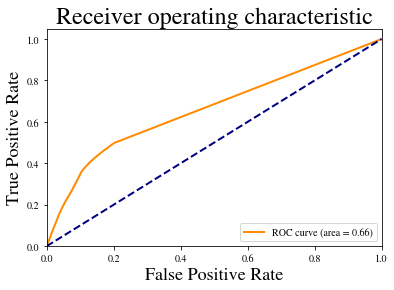

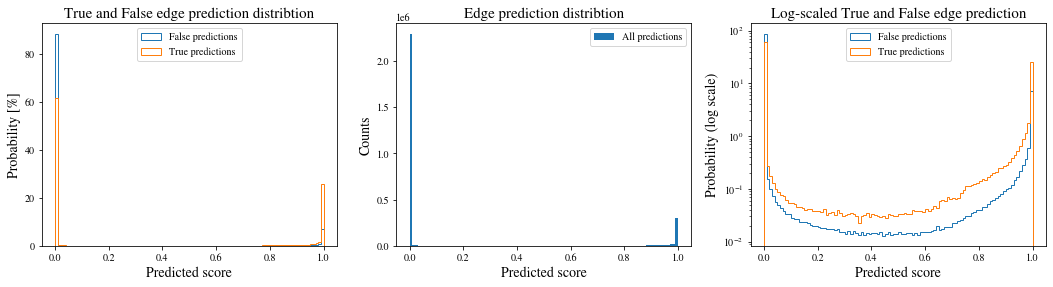

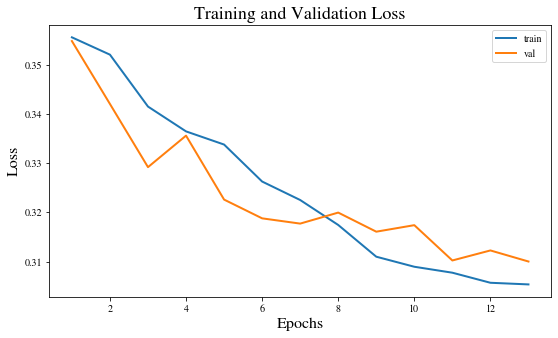

Training epoch 14:  10%|█         | 2/20 [00:00<00:01, 10.05it/s]

sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')


Training epoch 14:  20%|██        | 4/20 [00:00<00:01,  8.46it/s]

sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')


Training epoch 14:  30%|███       | 6/20 [00:00<00:01,  9.73it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')


Training epoch 14:  40%|████      | 8/20 [00:00<00:01, 10.79it/s]

sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 14:  50%|█████     | 10/20 [00:01<00:00, 10.08it/s]

sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')


Training epoch 14:  70%|███████   | 14/20 [00:01<00:00, 10.02it/s]

sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')


Training epoch 14:  80%|████████  | 16/20 [00:01<00:00, 10.04it/s]

sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 14:  90%|█████████ | 18/20 [00:01<00:00,  9.40it/s]

sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')


Training epoch 14: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]

sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')
Epoch: 14, train loss: 0.3046
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_14_loss_0.3046.pt


Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.13it/s]


pred [0. 0. 0. ... 0. 0. 0.]
Epoch: 14, val loss: 0.3142


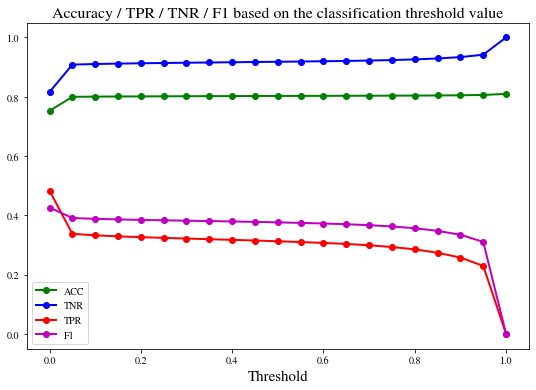

Chosen a default threshold...
Chosen classification threshold is: 0.65
Edge labels: number of positive: 525768
Predictions: number of positive: 336719


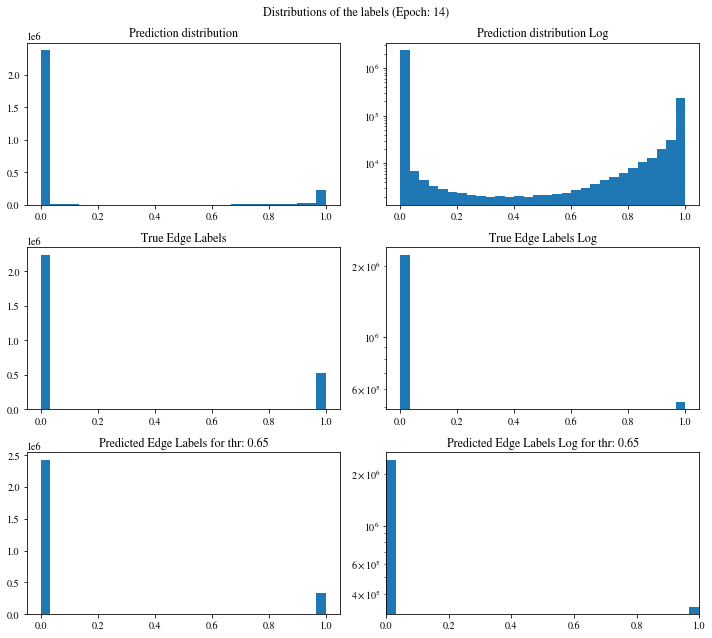

scores [0. 0. 0. ... 0. 0. 0.]
Confusion matrix:
[[2057785  177145]
 [ 366194  159574]]

Confusion matrix weighted:
[[0.460369   0.039631  ]
 [0.34824676 0.15175324]]

TN: 2057785 	 FN: 366194 	 TP: 159574 	 FP: 177145
Confusion matrix scaled:
[[0.74538577 0.06416674]
 [0.13264544 0.05780205]]

Accuracy: 0.8032
Precision: 0.4739
Negative predictive value: 0.8489
Recall: Correctly classifying 30.3506 % of positive edges
True negative rate: Correctly classifying 92.0738 % of all negative edges
F1 score: 0.3700
[0.56932975 0.79292446] [0.92073801 0.30350649] [0.70359691 0.43898381]
Balanced accuracy: 0.6121
Precision weighted: [0.56932975 0.79292446]
Recall weighted: [0.92073801 0.30350649]
F1 score weighted: [0.70359691 0.43898381]
positive_likelihood_ratio: 3.8291555431971243, negative_likelihood_ratio: 0.7564513500197277


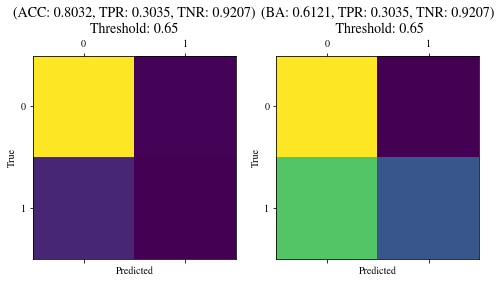

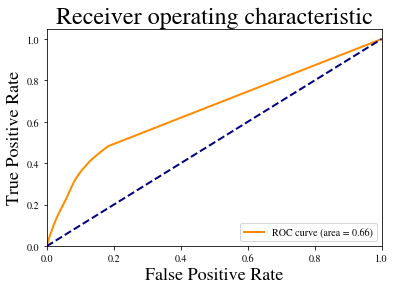

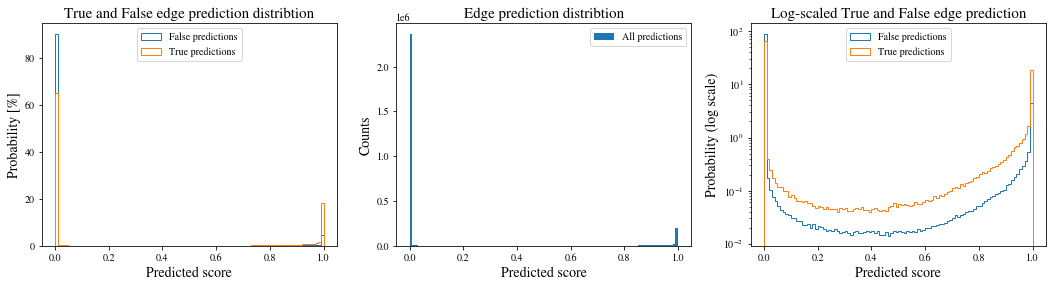

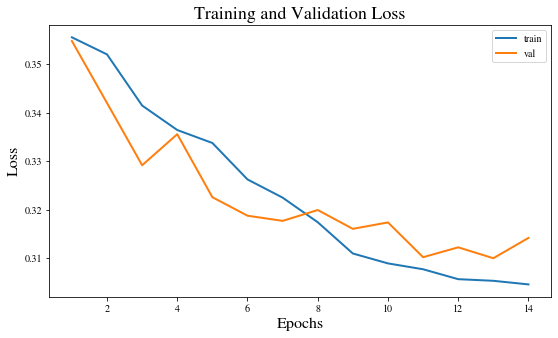

Training epoch 15:  10%|█         | 2/20 [00:00<00:01, 11.15it/s]

sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 15:  20%|██        | 4/20 [00:00<00:01,  9.98it/s]

sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')


Training epoch 15:  30%|███       | 6/20 [00:00<00:01, 10.75it/s]

sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')


Training epoch 15:  40%|████      | 8/20 [00:00<00:01, 10.14it/s]

sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')


Training epoch 15:  55%|█████▌    | 11/20 [00:01<00:00,  9.50it/s]

sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Training epoch 15:  60%|██████    | 12/20 [00:01<00:00,  9.01it/s]

sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')


Training epoch 15:  75%|███████▌  | 15/20 [00:01<00:00,  8.25it/s]

sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')
sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')


Training epoch 15:  85%|████████▌ | 17/20 [00:01<00:00,  9.18it/s]

sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')


Training epoch 15: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]

sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')


Epoch: 15, train loss: 0.3065
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_15_loss_0.3065.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]


pred [0.         0.         0.         ... 0.         0.22118604 0.99665797]
Epoch: 15, val loss: 0.3064


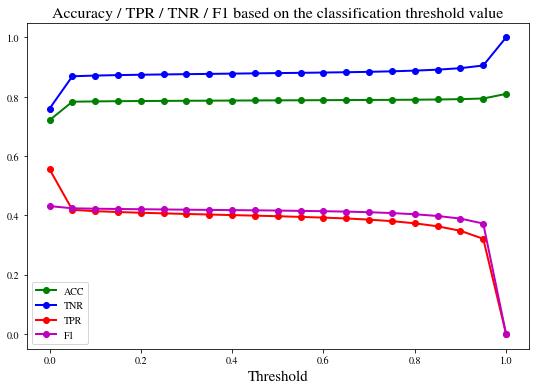

Chosen a default threshold...
Chosen classification threshold is: 0.65
Edge labels: number of positive: 525768
Predictions: number of positive: 466955


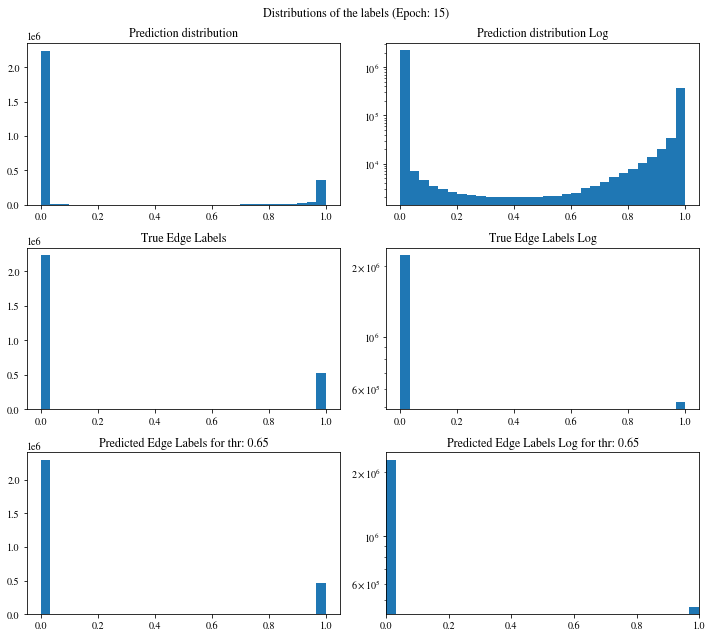

scores [0.         0.         0.         ... 0.         0.22118604 0.99665797]
Confusion matrix:
[[1972756  262174]
 [ 320987  204781]]

Confusion matrix weighted:
[[0.44134626 0.05865374]
 [0.30525536 0.19474464]]

TN: 1972756 	 FN: 320987 	 TP: 204781 	 FP: 262174
Confusion matrix scaled:
[[0.71458595 0.09496656]
 [0.11627023 0.07417726]]

Accuracy: 0.7888
Precision: 0.4385
Negative predictive value: 0.8601
Recall: Correctly classifying 38.9489 % of positive edges
True negative rate: Correctly classifying 88.2693 % of all negative edges
F1 score: 0.4126
[0.59114024 0.76853152] [0.88269252 0.38948928] [0.70807907 0.51697653]
Balanced accuracy: 0.6361
Precision weighted: [0.59114024 0.76853152]
Recall weighted: [0.88269252 0.38948928]
F1 score weighted: [0.70807907 0.51697653]
positive_likelihood_ratio: 3.320242577603669, negative_likelihood_ratio: 0.6916459625312688


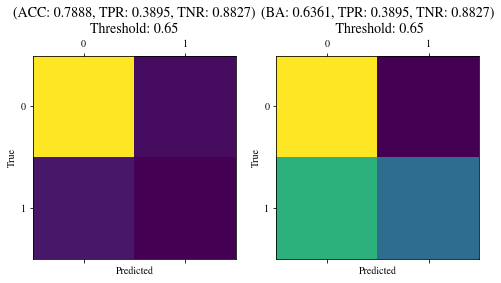

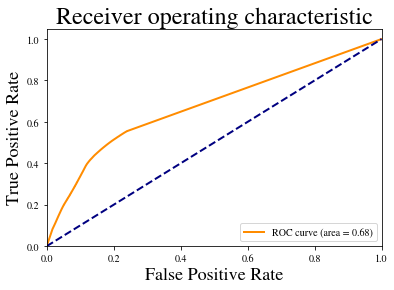

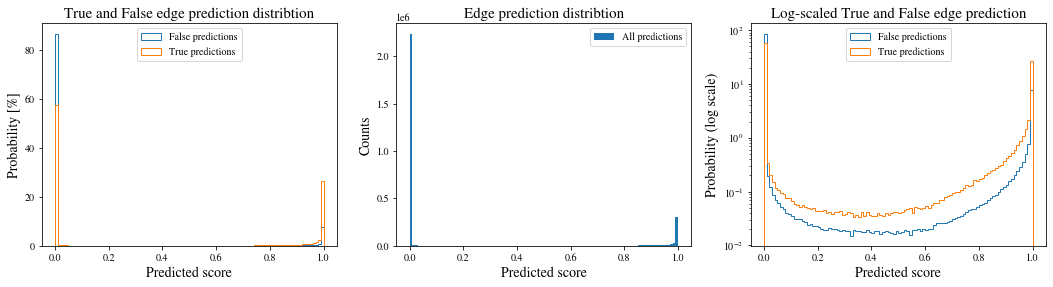

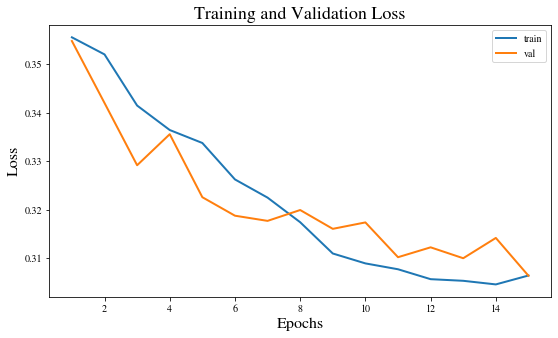

Training epoch 16:  10%|█         | 2/20 [00:00<00:01, 11.61it/s]

sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Training epoch 16:  20%|██        | 4/20 [00:00<00:01,  8.50it/s]

sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Training epoch 16:  35%|███▌      | 7/20 [00:00<00:01,  9.30it/s]

sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 16:  45%|████▌     | 9/20 [00:00<00:01,  9.11it/s]

sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')


Training epoch 16:  50%|█████     | 10/20 [00:01<00:01,  8.19it/s]

sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')


Training epoch 16:  70%|███████   | 14/20 [00:01<00:00,  9.50it/s]

sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')


Training epoch 16:  85%|████████▌ | 17/20 [00:01<00:00,  9.67it/s]

sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')


Training epoch 16: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')


Epoch: 16, train loss: 0.3036
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_16_loss_0.3036.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.03it/s]


pred [0. 0. 0. ... 0. 0. 0.]
Epoch: 16, val loss: 0.3037


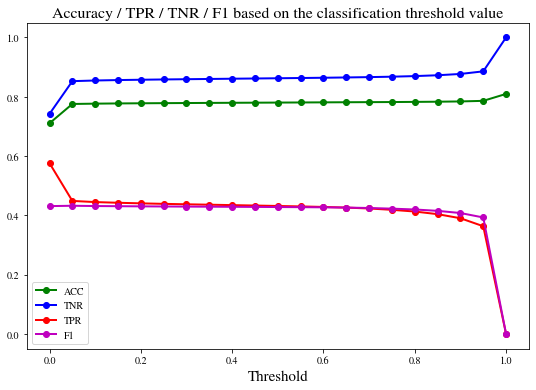

Chosen a default threshold...
Chosen classification threshold is: 0.65
Edge labels: number of positive: 525768
Predictions: number of positive: 525660


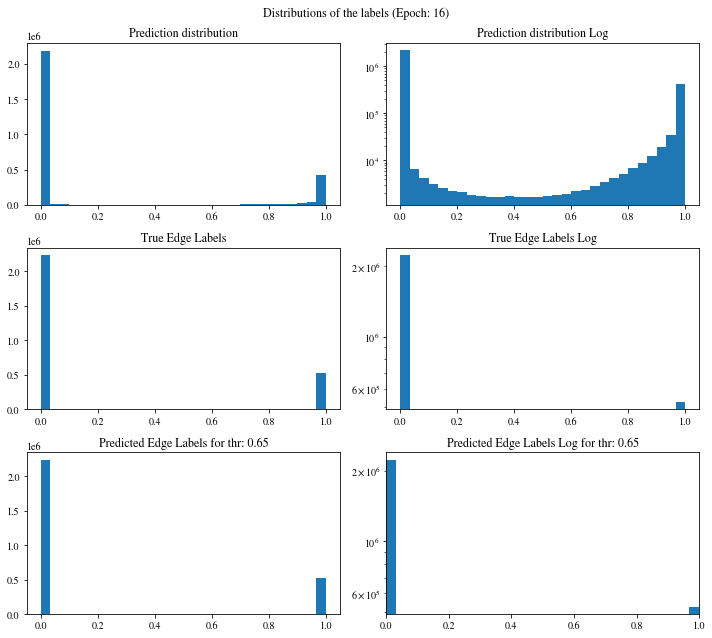

scores [0. 0. 0. ... 0. 0. 0.]
Confusion matrix:
[[1933301  301629]
 [ 301737  224031]]

Confusion matrix weighted:
[[0.43251936 0.06748064]
 [0.28694881 0.21305119]]

TN: 1933301 	 FN: 301737 	 TP: 224031 	 FP: 301629
Confusion matrix scaled:
[[0.70029427 0.10925824]
 [0.10929736 0.08115013]]

Accuracy: 0.7814
Precision: 0.4262
Negative predictive value: 0.8650
Recall: Correctly classifying 42.6102 % of positive edges
True negative rate: Correctly classifying 86.5039 % of all negative edges
F1 score: 0.4261
[0.60116539 0.75945462] [0.86503873 0.42610239] [0.70935736 0.54591289]
Balanced accuracy: 0.6456
Precision weighted: [0.60116539 0.75945462]
Recall weighted: [0.86503873 0.42610239]
F1 score weighted: [0.70935736 0.54591289]
positive_likelihood_ratio: 3.15721965922754, negative_likelihood_ratio: 0.6634357461186108


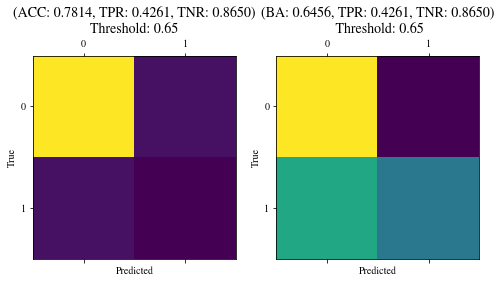

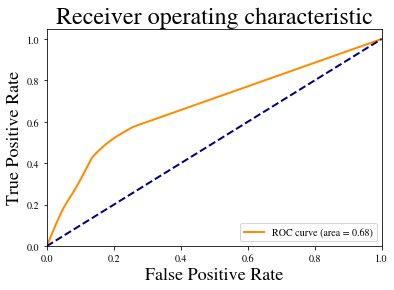

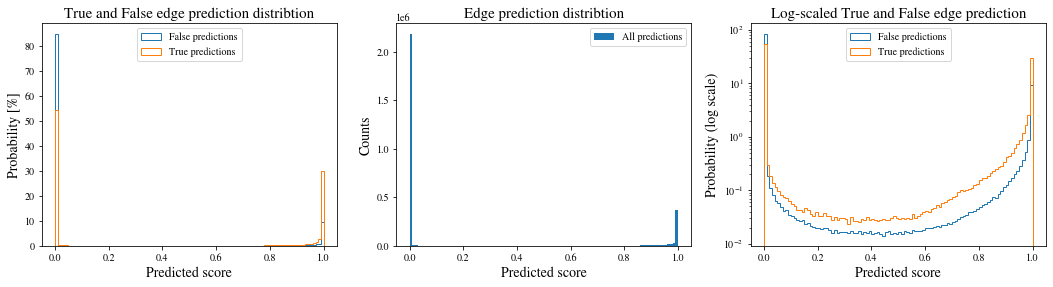

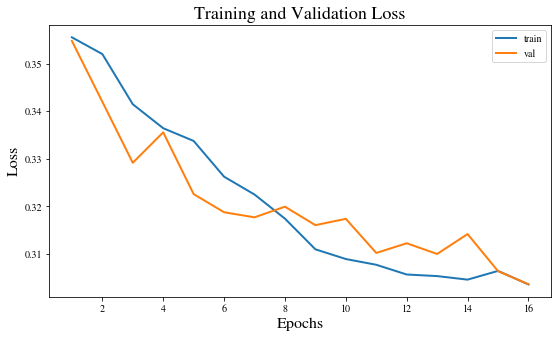

Training epoch 17:  10%|█         | 2/20 [00:00<00:01, 13.19it/s]

sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')


Training epoch 17:  20%|██        | 4/20 [00:00<00:01,  9.22it/s]

sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')


Training epoch 17:  30%|███       | 6/20 [00:00<00:01,  8.65it/s]

sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Training epoch 17:  40%|████      | 8/20 [00:00<00:01,  7.57it/s]

sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Training epoch 17:  50%|█████     | 10/20 [00:01<00:01,  7.84it/s]

sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')
sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')


Training epoch 17:  60%|██████    | 12/20 [00:01<00:00,  9.14it/s]

sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')


Training epoch 17:  80%|████████  | 16/20 [00:01<00:00, 10.12it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')


Training epoch 17:  90%|█████████ | 18/20 [00:01<00:00, 10.08it/s]

sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')


Training epoch 17: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
Epoch: 17, train loss: 0.3015
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_17_loss_0.3015.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.20it/s]


pred [1.02602669e-34 1.00000000e+00 1.00000000e+00 ... 6.75410769e-33
 0.00000000e+00 0.00000000e+00]
Epoch: 17, val loss: 0.2992


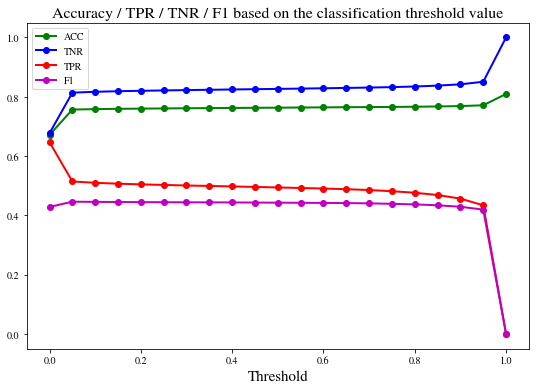

Chosen a default threshold...
Chosen classification threshold is: 0.65
Edge labels: number of positive: 525768
Predictions: number of positive: 637364


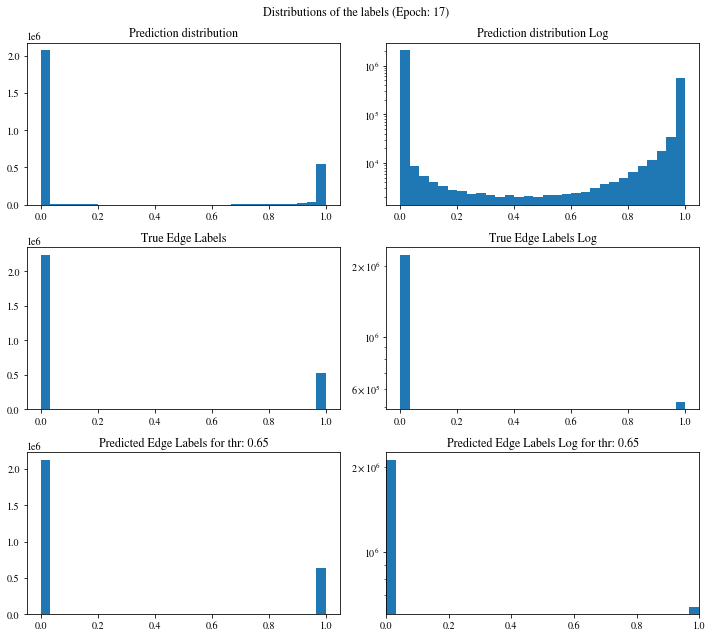

scores [1.02602669e-34 1.00000000e+00 1.00000000e+00 ... 6.75410769e-33
 0.00000000e+00 0.00000000e+00]
Confusion matrix:
[[1854240  380690]
 [ 269094  256674]]

Confusion matrix weighted:
[[0.41483178 0.08516822]
 [0.25590565 0.24409435]]

TN: 1854240 	 FN: 269094 	 TP: 256674 	 FP: 380690
Confusion matrix scaled:
[[0.67165623 0.13789629]
 [0.09747318 0.09297431]]

Accuracy: 0.7646
Precision: 0.4027
Negative predictive value: 0.8733
Recall: Correctly classifying 48.8189 % of positive edges
True negative rate: Correctly classifying 82.9664 % of all negative edges
F1 score: 0.4413
[0.6184712  0.74133648] [0.82966357 0.48818871] [0.7086675  0.58870221]
Balanced accuracy: 0.6589
Precision weighted: [0.6184712  0.74133648]
Recall weighted: [0.82966357 0.48818871]
F1 score weighted: [0.7086675  0.58870221]
positive_likelihood_ratio: 2.8660263902441128, negative_likelihood_ratio: 0.6168901617363279


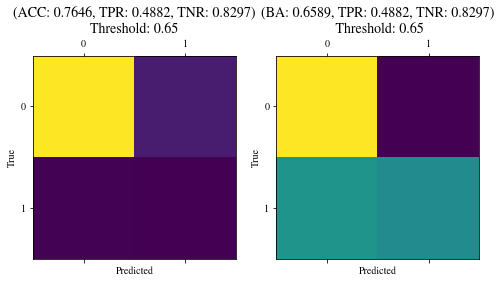

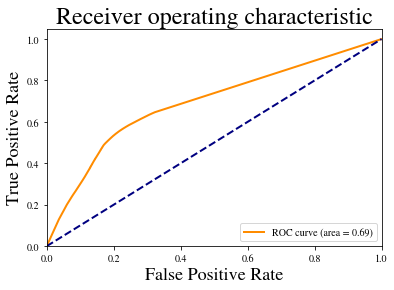

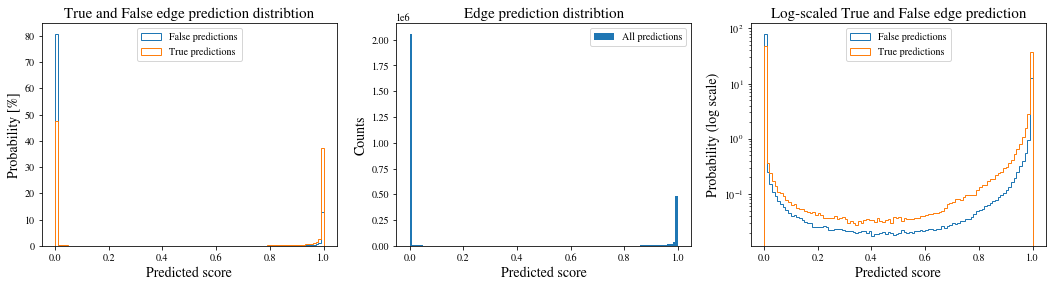

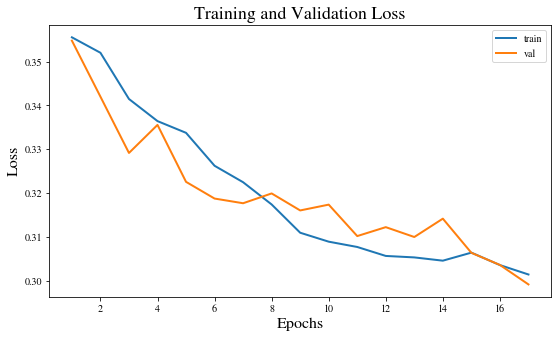

Training epoch 18:  10%|█         | 2/20 [00:00<00:01, 15.96it/s]

sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')


Training epoch 18:  20%|██        | 4/20 [00:00<00:01,  9.05it/s]

sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')
sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')


Training epoch 18:  30%|███       | 6/20 [00:00<00:01, 10.03it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')


Training epoch 18:  40%|████      | 8/20 [00:00<00:01,  9.73it/s]

sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')


Training epoch 18:  60%|██████    | 12/20 [00:01<00:00,  9.91it/s]

sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Training epoch 18:  70%|███████   | 14/20 [00:01<00:00,  9.00it/s]

sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')


Training epoch 18:  80%|████████  | 16/20 [00:01<00:00,  8.94it/s]

sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')
sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')


Training epoch 18:  90%|█████████ | 18/20 [00:01<00:00,  8.35it/s]

sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')
sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')


Training epoch 18: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
Epoch: 18, train loss: 0.3011
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_18_loss_0.3011.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.35it/s]


pred [0.000000e+00 0.000000e+00 0.000000e+00 ... 1.571135e-05 0.000000e+00
 0.000000e+00]
Epoch: 18, val loss: 0.2982


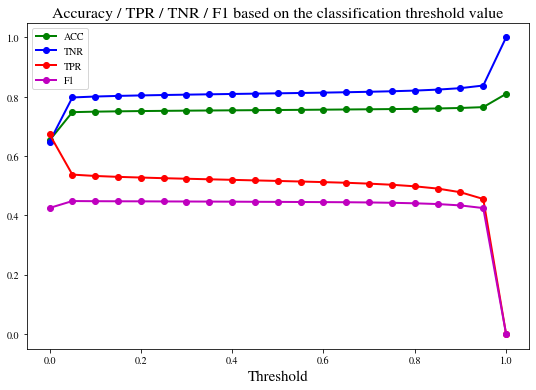

Chosen classification threshold is: 0.025
Edge labels: number of positive: 525768
Predictions: number of positive: 743665


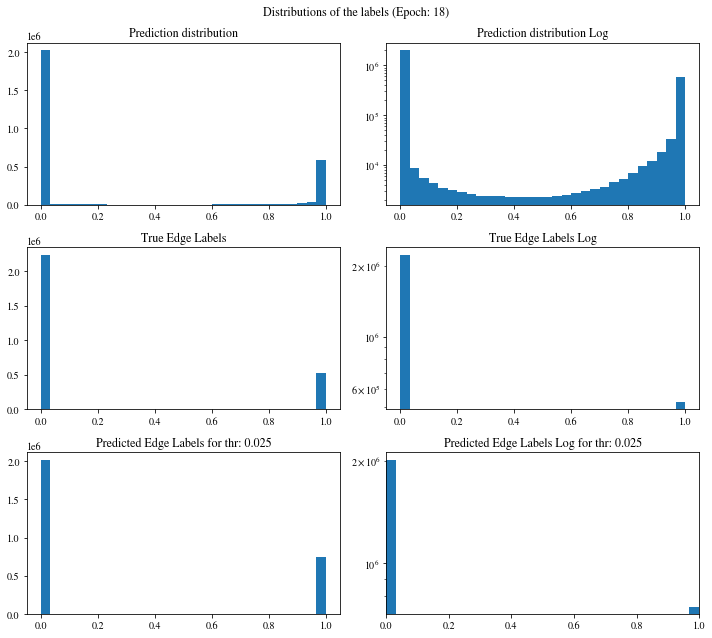

scores [0.000000e+00 0.000000e+00 0.000000e+00 ... 1.571135e-05 0.000000e+00
 0.000000e+00]
Confusion matrix:
[[1775892  459038]
 [ 241141  284627]]

Confusion matrix weighted:
[[0.39730372 0.10269628]
 [0.22932263 0.27067737]]

TN: 1775892 	 FN: 241141 	 TP: 284627 	 FP: 459038
Confusion matrix scaled:
[[0.64327645 0.16627606]
 [0.08734784 0.10309965]]

Accuracy: 0.7464
Precision: 0.3827
Negative predictive value: 0.8804
Recall: Correctly classifying 54.1355 % of positive edges
True negative rate: Correctly classifying 79.4607 % of all negative edges
F1 score: 0.4484
[0.63403609 0.72495038] [0.79460744 0.54135474] [0.70529811 0.61984323]
Balanced accuracy: 0.6680
Precision weighted: [0.63403609 0.72495038]
Recall weighted: [0.79460744 0.54135474]
F1 score weighted: [0.70529811 0.61984323]
positive_likelihood_ratio: 2.6357076180461716, negative_likelihood_ratio: 0.5771972881387616


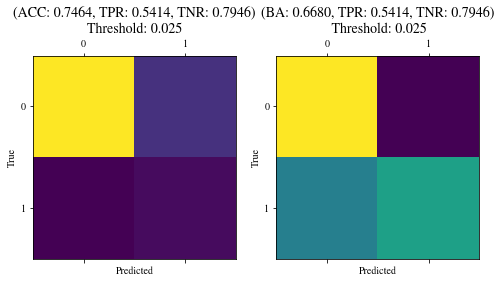

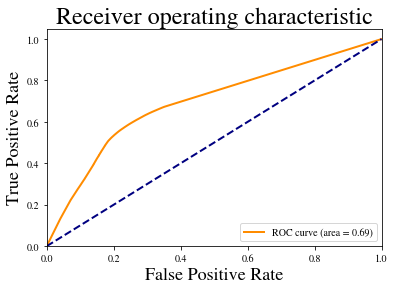

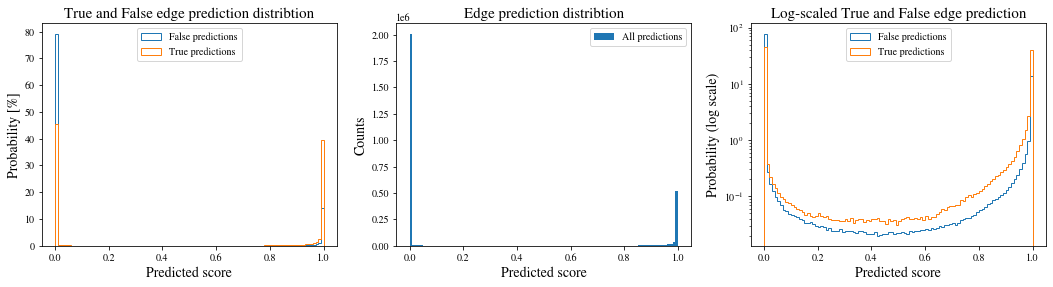

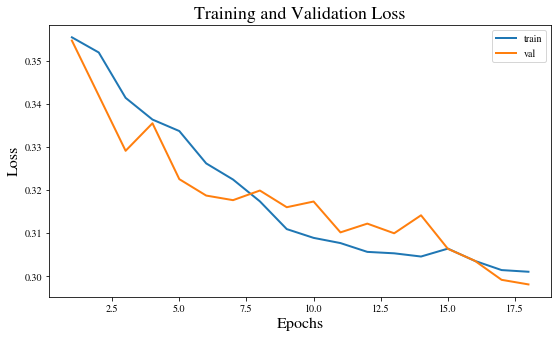

Training epoch 19:  10%|█         | 2/20 [00:00<00:00, 19.69it/s]

sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Training epoch 19:  20%|██        | 4/20 [00:00<00:01, 10.71it/s]

sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')


Training epoch 19:  40%|████      | 8/20 [00:00<00:01, 11.07it/s]

sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 19:  50%|█████     | 10/20 [00:00<00:01,  9.98it/s]

sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')


Training epoch 19:  60%|██████    | 12/20 [00:01<00:00, 10.11it/s]

sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Training epoch 19:  75%|███████▌  | 15/20 [00:01<00:00,  9.38it/s]

sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')
sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')


Training epoch 19:  85%|████████▌ | 17/20 [00:01<00:00,  8.98it/s]

sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')


Training epoch 19:  95%|█████████▌| 19/20 [00:01<00:00,  8.84it/s]

sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')
sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')


Training epoch 19: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')
Epoch: 19, train loss: 0.3003
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_19_loss_0.3003.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.04it/s]


pred [0.91027683 0.92213684 0.94128144 ... 0.         0.02747794 0.9926663 ]
Epoch: 19, val loss: 0.3041


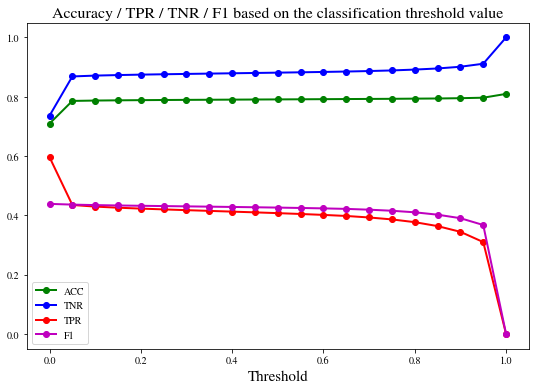

Chosen a default threshold...
Chosen classification threshold is: 0.65
Edge labels: number of positive: 525768
Predictions: number of positive: 466250


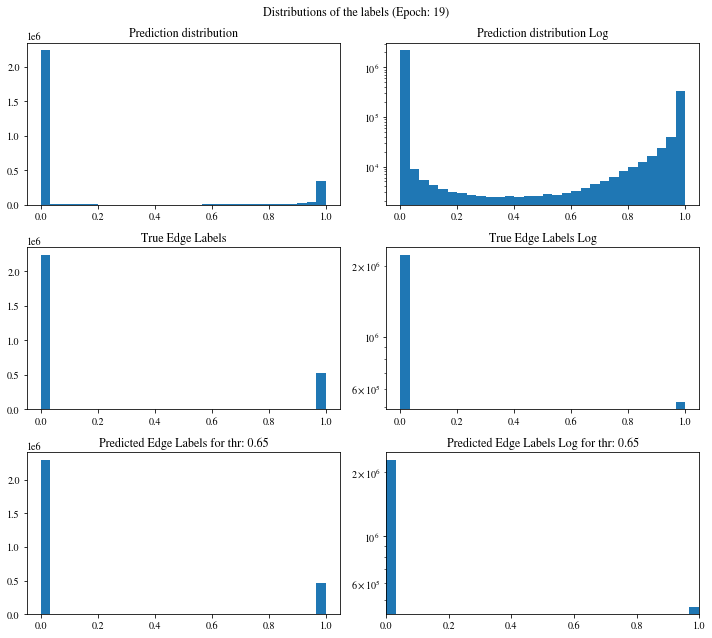

scores [0.91027683 0.92213684 0.94128144 ... 0.         0.02747794 0.9926663 ]
Confusion matrix:
[[1977869  257061]
 [ 316579  209189]]

Confusion matrix weighted:
[[0.44249015 0.05750985]
 [0.3010634  0.1989366 ]]

TN: 1977869 	 FN: 316579 	 TP: 209189 	 FP: 257061
Confusion matrix scaled:
[[0.71643802 0.09311449]
 [0.11467354 0.07577395]]

Accuracy: 0.7922
Precision: 0.4487
Negative predictive value: 0.8620
Recall: Correctly classifying 39.7873 % of positive edges
True negative rate: Correctly classifying 88.4980 % of all negative edges
F1 score: 0.4217
[0.59510193 0.77574323] [0.88498029 0.39787321] [0.71165435 0.52597669]
Balanced accuracy: 0.6414
Precision weighted: [0.59510193 0.77574323]
Recall weighted: [0.88498029 0.39787321]
F1 score weighted: [0.71165435 0.52597669]
positive_likelihood_ratio: 3.459174146423908, negative_likelihood_ratio: 0.680384411073799


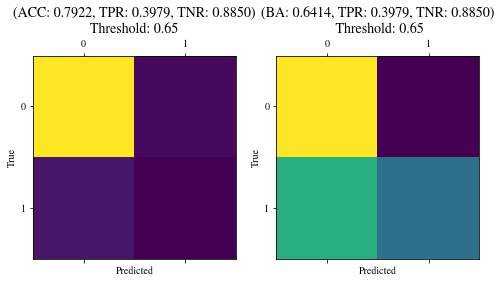

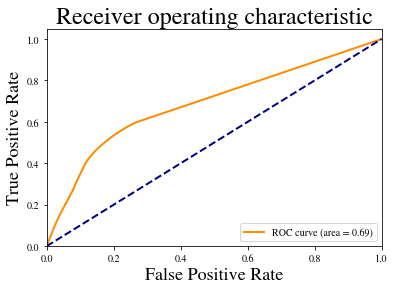

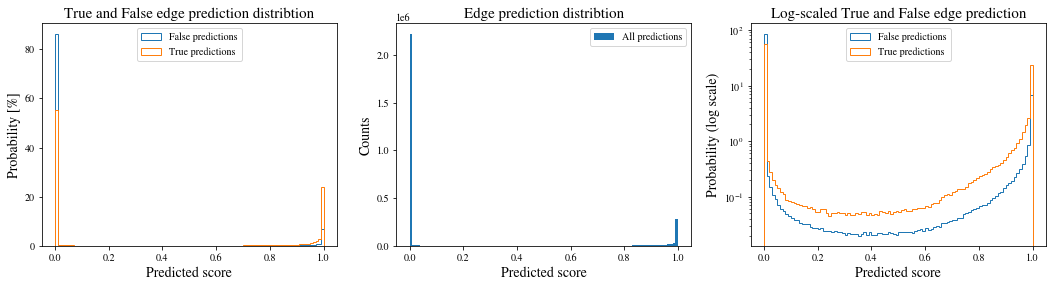

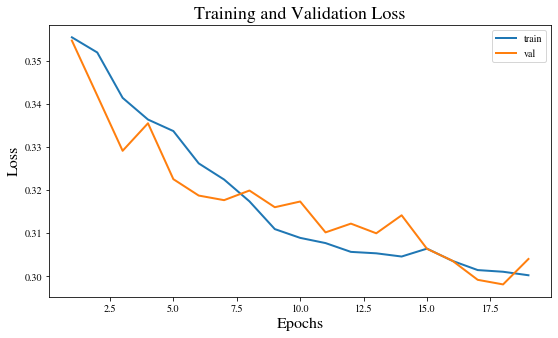

Training epoch 20:  10%|█         | 2/20 [00:00<00:01, 16.79it/s]

sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')


Training epoch 20:  20%|██        | 4/20 [00:00<00:01, 11.97it/s]

sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 20:  30%|███       | 6/20 [00:00<00:01,  9.20it/s]

sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 20:  40%|████      | 8/20 [00:00<00:01,  9.36it/s]

sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')


Training epoch 20:  60%|██████    | 12/20 [00:01<00:00,  9.76it/s]

sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')


Training epoch 20:  70%|███████   | 14/20 [00:01<00:00,  9.43it/s]

sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Training epoch 20:  80%|████████  | 16/20 [00:01<00:00,  9.07it/s]

sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')


Training epoch 20:  85%|████████▌ | 17/20 [00:01<00:00,  8.78it/s]

sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')


Training epoch 20: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')
Epoch: 20, train loss: 0.3006
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_20_loss_0.3006.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.24it/s]


pred [0.00000000e+00 9.99974132e-01 9.99992728e-01 ... 0.00000000e+00
 1.06322252e-33 0.00000000e+00]
Epoch: 20, val loss: 0.3044


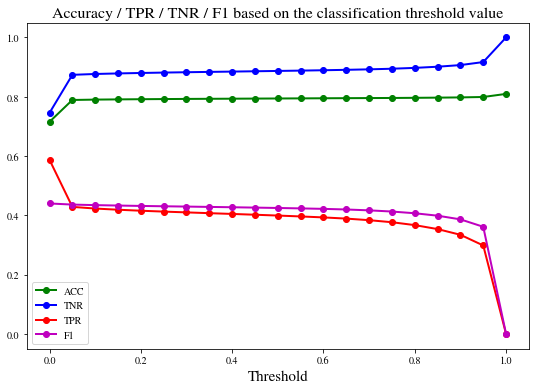

Chosen a default threshold...
Chosen classification threshold is: 0.65
Edge labels: number of positive: 525768
Predictions: number of positive: 448677


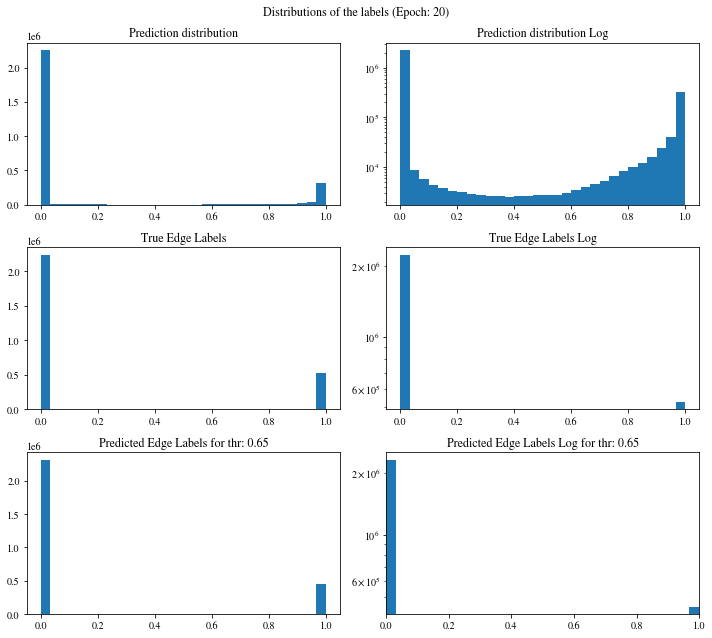

scores [0.00000000e+00 9.99974132e-01 9.99992728e-01 ... 0.00000000e+00
 1.06322252e-33 0.00000000e+00]
Confusion matrix:
[[1990766  244164]
 [ 321255  204513]]

Confusion matrix weighted:
[[0.44537547 0.05462453]
 [0.30551023 0.19448977]]

TN: 1990766 	 FN: 321255 	 TP: 204513 	 FP: 244164
Confusion matrix scaled:
[[0.72110966 0.08844285]
 [0.11636731 0.07408018]]

Accuracy: 0.7952
Precision: 0.4558
Negative predictive value: 0.8611
Recall: Correctly classifying 38.8980 % of positive edges
True negative rate: Correctly classifying 89.0751 % of all negative edges
F1 score: 0.4198
[0.59313351 0.78072504] [0.89075094 0.38897955] [0.71209619 0.5192526 ]
Balanced accuracy: 0.6399
Precision weighted: [0.59313351 0.78072504]
Recall weighted: [0.89075094 0.38897955]
F1 score weighted: [0.71209619 0.5192526 ]
positive_likelihood_ratio: 3.5604842052586165, negative_likelihood_ratio: 0.6859610494187841


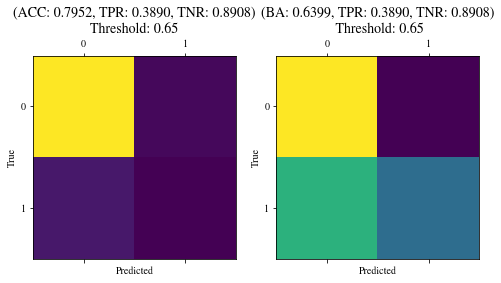

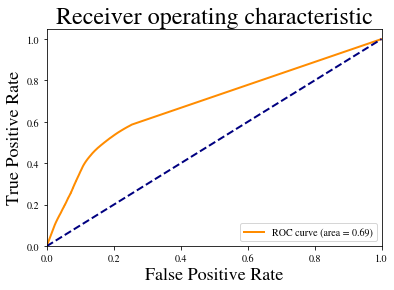

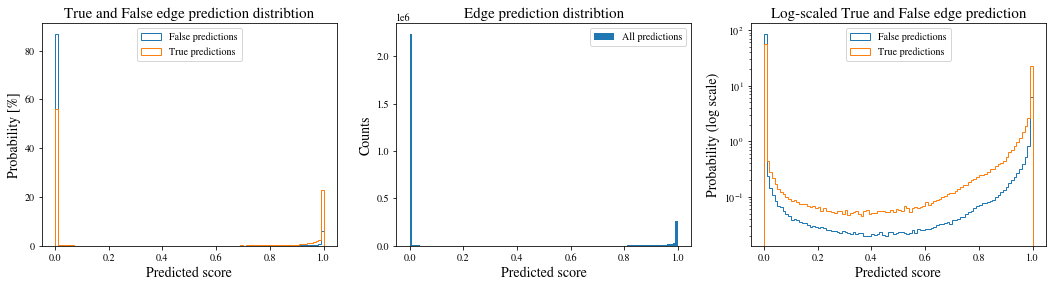

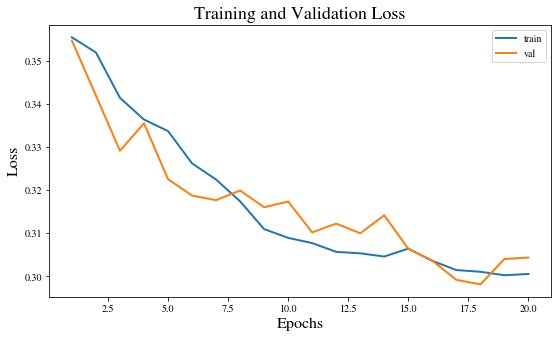

Training epoch 21:  10%|█         | 2/20 [00:00<00:01, 12.87it/s]

sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')


Training epoch 21:  20%|██        | 4/20 [00:00<00:01,  8.96it/s]

sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')
sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')


Training epoch 21:  30%|███       | 6/20 [00:00<00:01,  9.77it/s]

sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Training epoch 21:  40%|████      | 8/20 [00:00<00:01,  9.01it/s]

sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Training epoch 21:  50%|█████     | 10/20 [00:01<00:01,  7.95it/s]

sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')


Training epoch 21:  60%|██████    | 12/20 [00:01<00:00,  9.19it/s]

sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')


Training epoch 21:  75%|███████▌  | 15/20 [00:01<00:00,  9.50it/s]

sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')


Training epoch 21:  90%|█████████ | 18/20 [00:01<00:00,  9.23it/s]

sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')


Training epoch 21: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
Epoch: 21, train loss: 0.2994
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_21_loss_0.2994.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.30it/s]


pred [0. 0. 0. ... 0. 0. 0.]
Epoch: 21, val loss: 0.3000


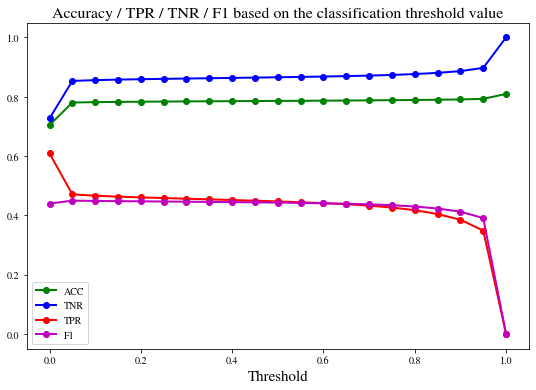

Chosen a default threshold...
Chosen classification threshold is: 0.65
Edge labels: number of positive: 525768
Predictions: number of positive: 521626


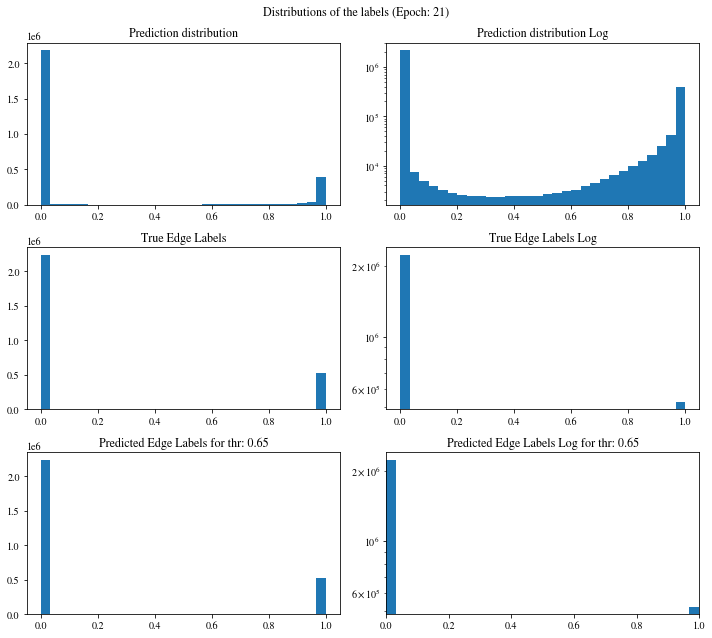

scores [0. 0. 0. ... 0. 0. 0.]
Confusion matrix:
[[1943305  291625]
 [ 295767  230001]]

Confusion matrix weighted:
[[0.43475746 0.06524254]
 [0.2812714  0.2187286 ]]

TN: 1943305 	 FN: 295767 	 TP: 230001 	 FP: 291625
Confusion matrix scaled:
[[0.70391799 0.10563452]
 [0.10713486 0.08331263]]

Accuracy: 0.7872
Precision: 0.4409
Negative predictive value: 0.8679
Recall: Correctly classifying 43.7457 % of positive edges
True negative rate: Correctly classifying 86.9515 % of all negative edges
F1 score: 0.4392
[0.60717869 0.77024941] [0.86951493 0.43745721] [0.71504465 0.55800167]
Balanced accuracy: 0.6535
Precision weighted: [0.60717869 0.77024941]
Recall weighted: [0.86951493 0.43745721]
F1 score weighted: [0.71504465 0.55800167]
positive_likelihood_ratio: 3.352546016965182, negative_likelihood_ratio: 0.6469616286699869


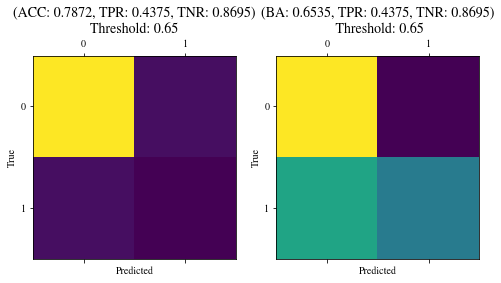

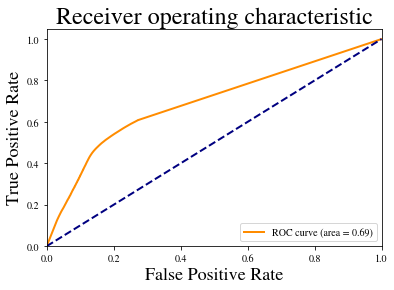

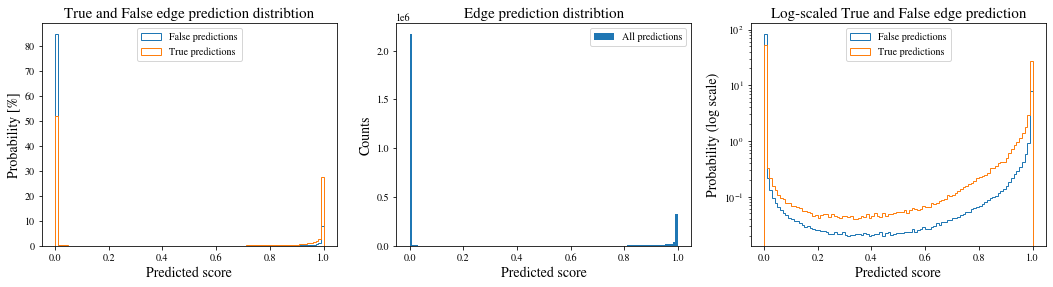

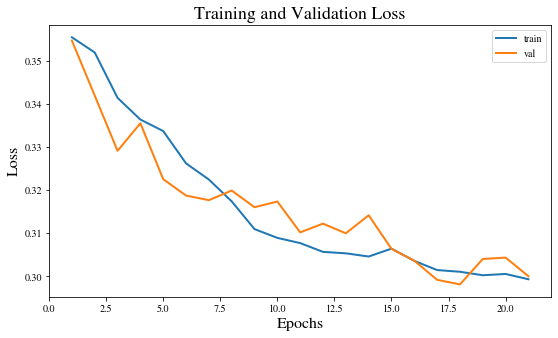

Training epoch 22:  10%|█         | 2/20 [00:00<00:01, 10.23it/s]

sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Training epoch 22:  20%|██        | 4/20 [00:00<00:02,  7.59it/s]

sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')


Training epoch 22:  35%|███▌      | 7/20 [00:00<00:01,  9.70it/s]

sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')


Training epoch 22:  45%|████▌     | 9/20 [00:00<00:01, 10.00it/s]

sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')


Training epoch 22:  55%|█████▌    | 11/20 [00:01<00:00, 10.42it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')


Training epoch 22:  75%|███████▌  | 15/20 [00:01<00:00, 10.88it/s]

sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')


Training epoch 22:  85%|████████▌ | 17/20 [00:01<00:00, 10.04it/s]

sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')


Training epoch 22: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]

sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')
sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')


Epoch: 22, train loss: 0.2997
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_22_loss_0.2997.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.62it/s]


pred [0. 0. 0. ... 0. 0. 0.]
Epoch: 22, val loss: 0.3045


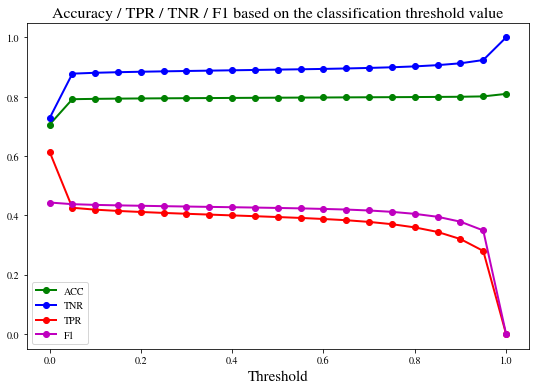

Chosen a default threshold...
Chosen classification threshold is: 0.65
Edge labels: number of positive: 525768
Predictions: number of positive: 435535


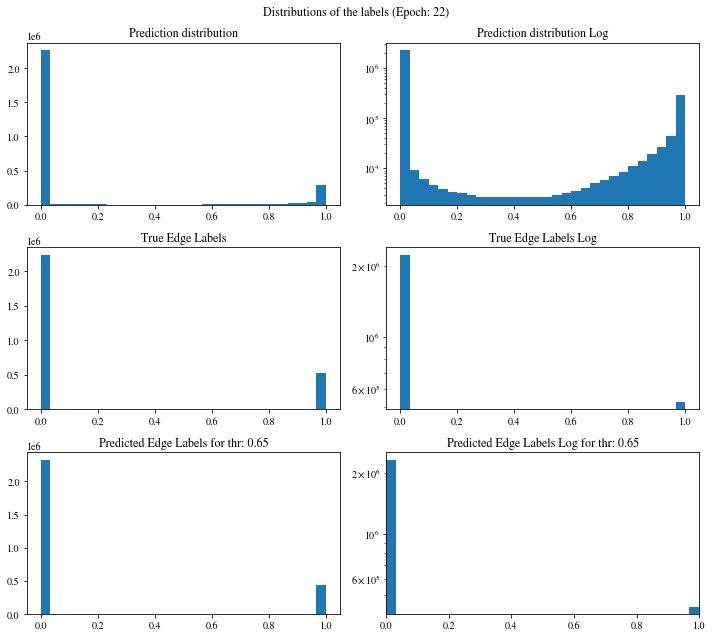

scores [0. 0. 0. ... 0. 0. 0.]
Confusion matrix:
[[2001045  233885]
 [ 324118  201650]]

Confusion matrix weighted:
[[0.44767509 0.05232491]
 [0.30823291 0.19176709]]

TN: 2001045 	 FN: 324118 	 TP: 201650 	 FP: 233885
Confusion matrix scaled:
[[0.724833   0.08471952]
 [0.11740437 0.07304312]]

Accuracy: 0.7979
Precision: 0.4630
Negative predictive value: 0.8606
Recall: Correctly classifying 38.3534 % of positive edges
True negative rate: Correctly classifying 89.5350 % of all negative edges
F1 score: 0.4195
[0.59223489 0.78563449] [0.89535019 0.38353418] [0.71291065 0.5154392 ]
Balanced accuracy: 0.6394
Precision weighted: [0.59223489 0.78563449]
Recall weighted: [0.89535019 0.38353418]
F1 score weighted: [0.71291065 0.5154392 ]
positive_likelihood_ratio: 3.6649295603389223, negative_likelihood_ratio: 0.6885192235957368


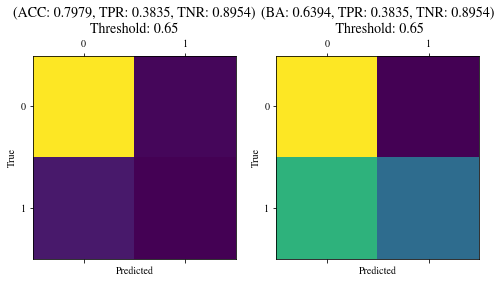

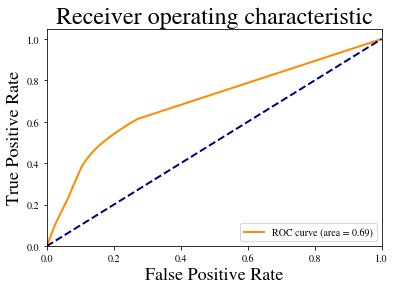

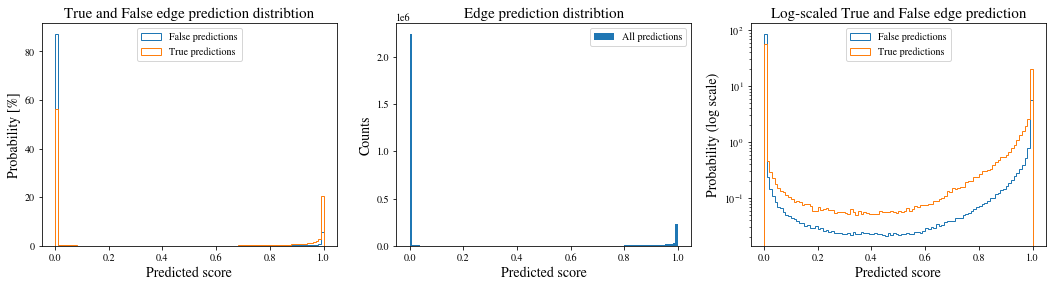

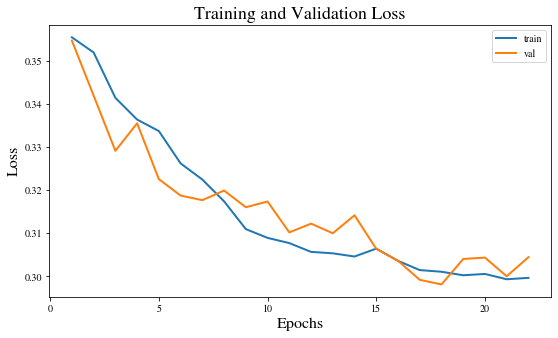

Training epoch 23:  10%|█         | 2/20 [00:00<00:01, 15.23it/s]

sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Training epoch 23:  20%|██        | 4/20 [00:00<00:01,  9.96it/s]

sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')


Training epoch 23:  30%|███       | 6/20 [00:00<00:01,  9.78it/s]

sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 23:  40%|████      | 8/20 [00:00<00:01,  8.93it/s]

sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Training epoch 23:  45%|████▌     | 9/20 [00:00<00:01,  8.55it/s]

sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')


Training epoch 23:  65%|██████▌   | 13/20 [00:01<00:00,  9.60it/s]

sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')
sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')


Training epoch 23:  75%|███████▌  | 15/20 [00:01<00:00,  8.53it/s]

sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')


Training epoch 23:  90%|█████████ | 18/20 [00:01<00:00,  9.58it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')


Training epoch 23: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
Epoch: 23, train loss: 0.2982
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_23_loss_0.2982.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.45it/s]


pred [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.62938821e-01
 0.00000000e+00 8.83057689e-12]
Epoch: 23, val loss: 0.2944


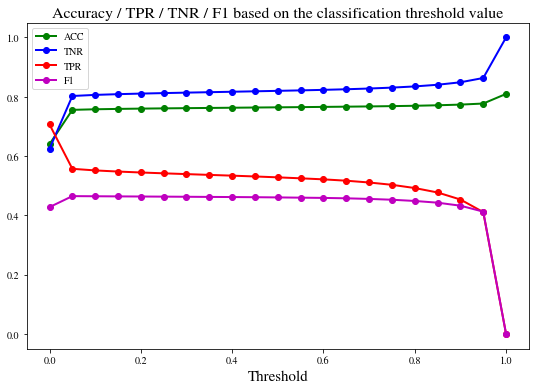

Chosen classification threshold is: 0.025
Edge labels: number of positive: 525768
Predictions: number of positive: 744260


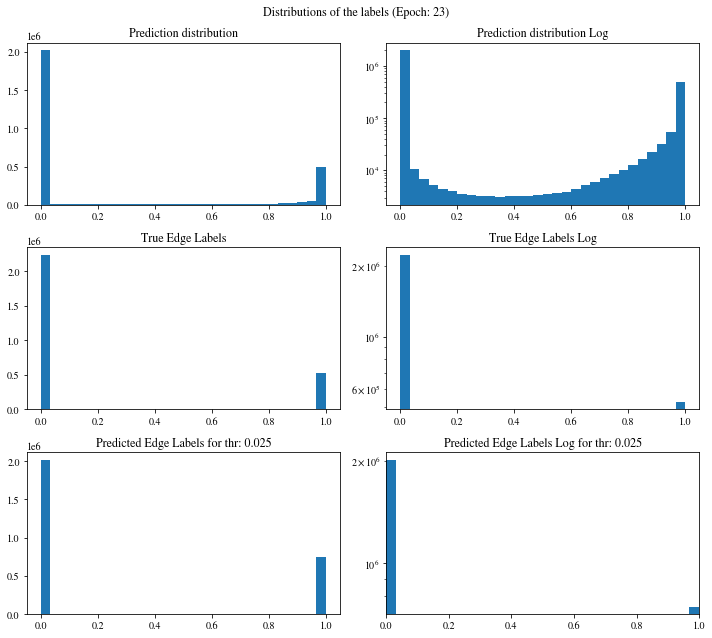

scores [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.62938821e-01
 0.00000000e+00 8.83057689e-12]
Confusion matrix:
[[1786013  448917]
 [ 230425  295343]]

Confusion matrix weighted:
[[0.399568   0.100432  ]
 [0.21913182 0.28086818]]

TN: 1786013 	 FN: 230425 	 TP: 295343 	 FP: 448917
Confusion matrix scaled:
[[0.64694255 0.16260996]
 [0.08346621 0.10698128]]

Accuracy: 0.7539
Precision: 0.3968
Negative predictive value: 0.8857
Recall: Correctly classifying 56.1736 % of positive edges
True negative rate: Correctly classifying 79.9136 % of all negative edges
F1 score: 0.4651
[0.64581883 0.73660646] [0.79913599 0.56173636] [0.71434354 0.63739503]
Balanced accuracy: 0.6804
Precision weighted: [0.64581883 0.73660646]
Recall weighted: [0.79913599 0.56173636]
F1 score weighted: [0.71434354 0.63739503]
positive_likelihood_ratio: 2.7966003344131822, negative_likelihood_ratio: 0.5484218578903051


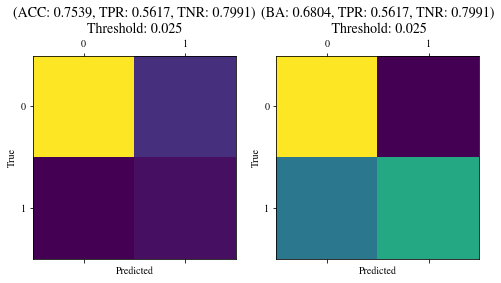

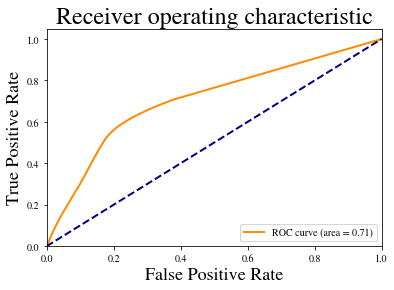

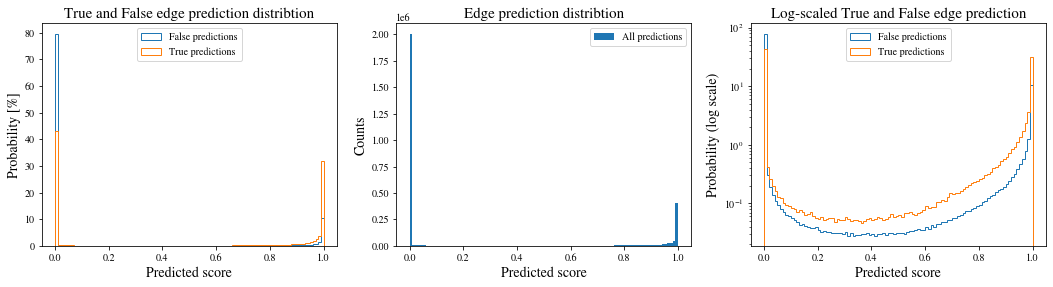

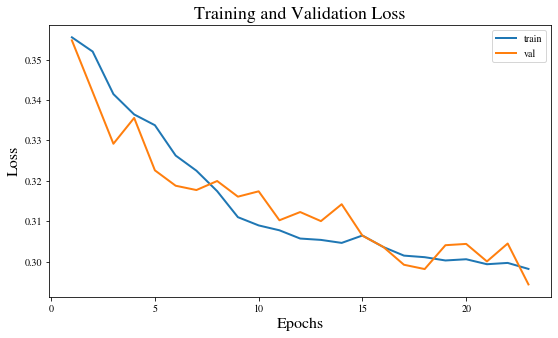

Training epoch 24:  10%|█         | 2/20 [00:00<00:01, 15.17it/s]

sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')


Training epoch 24:  20%|██        | 4/20 [00:00<00:01,  9.57it/s]

sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 24:  30%|███       | 6/20 [00:00<00:01,  9.63it/s]

sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')


Training epoch 24:  40%|████      | 8/20 [00:00<00:01,  9.50it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')


Training epoch 24:  60%|██████    | 12/20 [00:01<00:00,  8.71it/s]

sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')


Training epoch 24:  65%|██████▌   | 13/20 [00:01<00:00,  8.88it/s]

sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Training epoch 24:  85%|████████▌ | 17/20 [00:01<00:00, 10.05it/s]

sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 24:  95%|█████████▌| 19/20 [00:02<00:00,  9.47it/s]

sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')


Training epoch 24: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')
Epoch: 24, train loss: 0.2988
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_24_loss_0.2988.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.34it/s]


pred [7.74260170e-11 1.00000000e+00 1.00000000e+00 ... 3.82032767e-02
 7.90915847e-01 2.15650024e-03]
Epoch: 24, val loss: 0.2932


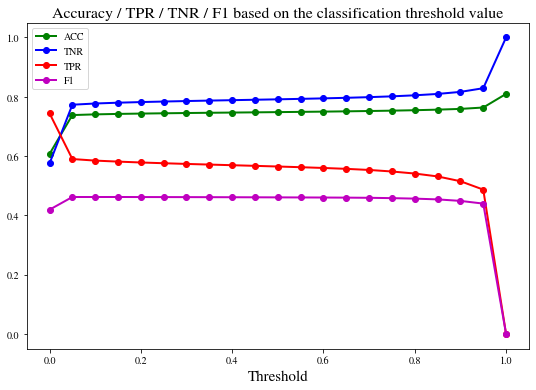

Chosen classification threshold is: 0.025
Edge labels: number of positive: 525768
Predictions: number of positive: 828097


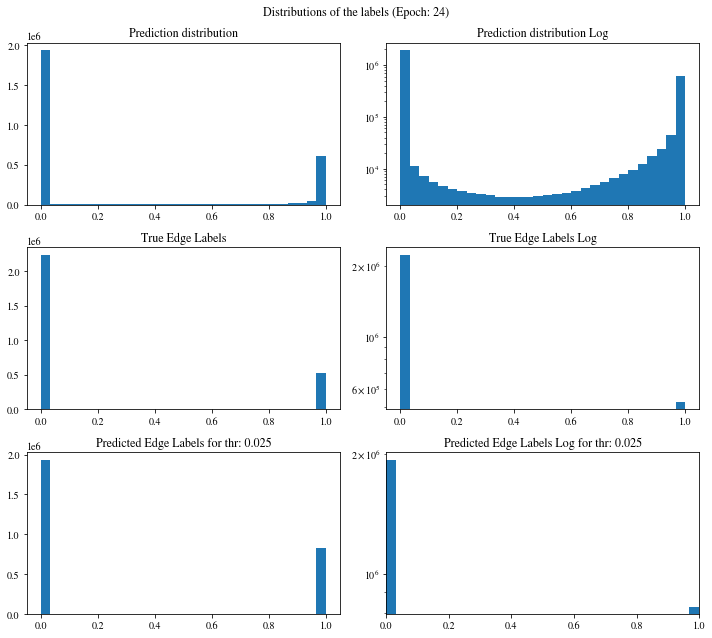

scores [7.74260170e-11 1.00000000e+00 1.00000000e+00 ... 3.82032767e-02
 7.90915847e-01 2.15650024e-03]
Confusion matrix:
[[1719359  515571]
 [ 213242  312526]]

Confusion matrix weighted:
[[0.38465612 0.11534388]
 [0.20279096 0.29720904]]

TN: 1719359 	 FN: 213242 	 TP: 312526 	 FP: 515571
Confusion matrix scaled:
[[0.62279865 0.18675386]
 [0.07724206 0.11320543]]

Accuracy: 0.7360
Precision: 0.3774
Negative predictive value: 0.8897
Recall: Correctly classifying 59.4418 % of positive edges
True negative rate: Correctly classifying 76.9312 % of all negative edges
F1 score: 0.4617
[0.6547928  0.72041434] [0.76931224 0.59441807] [0.70744798 0.65137929]
Balanced accuracy: 0.6819
Precision weighted: [0.6547928  0.72041434]
Recall weighted: [0.76931224 0.59441807]
F1 score weighted: [0.70744798 0.65137929]
positive_likelihood_ratio: 2.5767213010763914, negative_likelihood_ratio: 0.5272006730896478


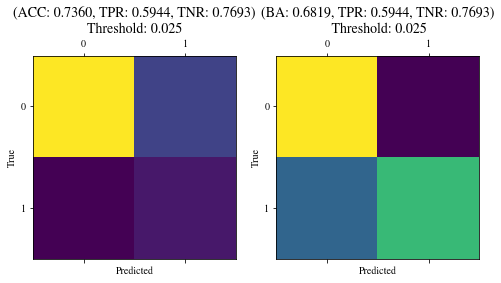

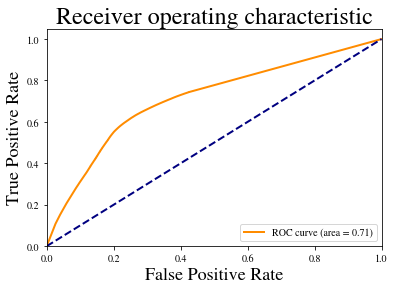

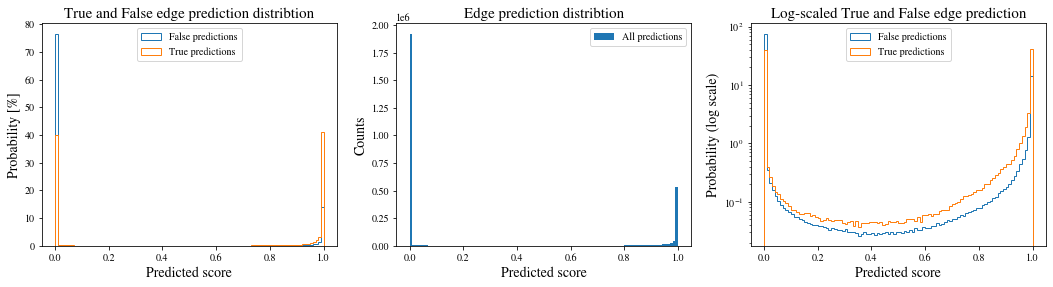

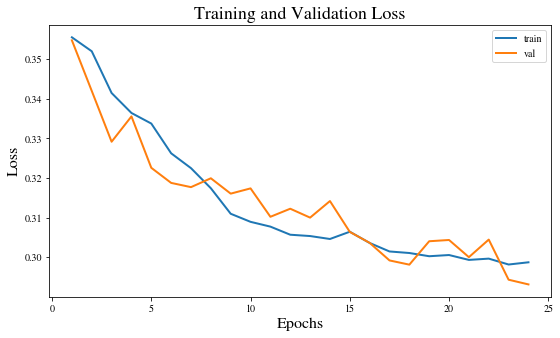

Training epoch 25:  10%|█         | 2/20 [00:00<00:01,  9.48it/s]

sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Training epoch 25:  20%|██        | 4/20 [00:00<00:01,  8.07it/s]

sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')
sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')


Training epoch 25:  35%|███▌      | 7/20 [00:00<00:01,  9.29it/s]

sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')


Training epoch 25:  45%|████▌     | 9/20 [00:01<00:01,  8.65it/s]

sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')
sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')


Training epoch 25:  55%|█████▌    | 11/20 [00:01<00:00,  9.54it/s]

sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')


Training epoch 25:  70%|███████   | 14/20 [00:01<00:00,  9.35it/s]

sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')


Training epoch 25:  80%|████████  | 16/20 [00:01<00:00,  9.52it/s]

sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 25:  95%|█████████▌| 19/20 [00:02<00:00,  9.71it/s]

sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')
sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')


Training epoch 25: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
Epoch: 25, train loss: 0.2982
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_25_loss_0.2982.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.24it/s]


pred [9.99949574e-01 9.99943018e-01 9.99960303e-01 ... 2.64528037e-25
 3.94430347e-02 8.23101401e-01]
Epoch: 25, val loss: 0.2936


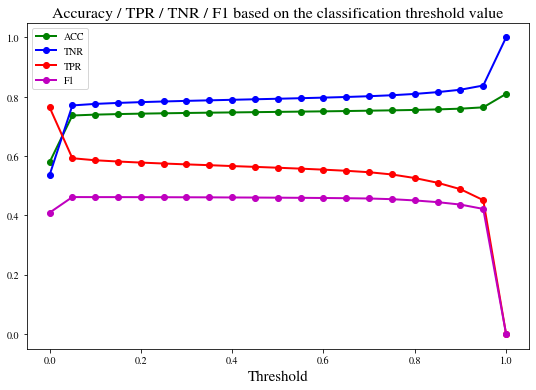

Chosen classification threshold is: 0.025
Edge labels: number of positive: 525768
Predictions: number of positive: 837762


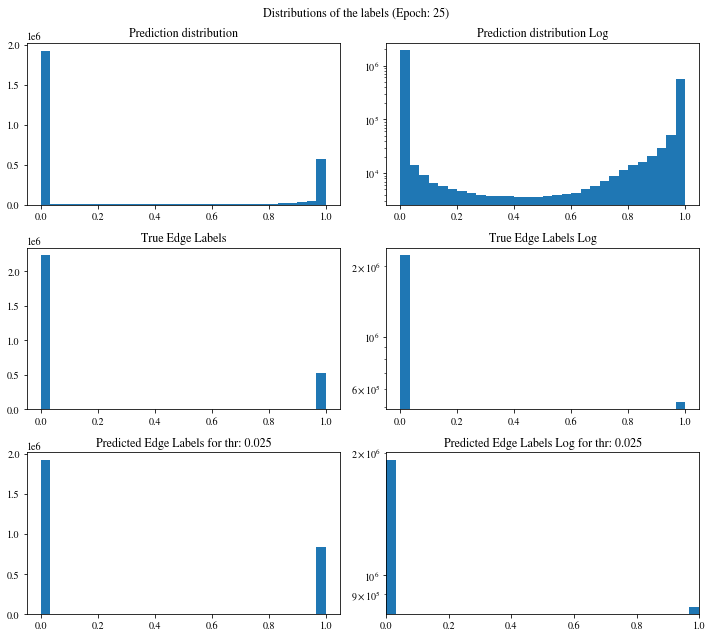

scores [9.99949574e-01 9.99943018e-01 9.99960303e-01 ... 2.64528037e-25
 3.94430347e-02 8.23101401e-01]
Confusion matrix:
[[1711872  523058]
 [ 211064  314704]]

Confusion matrix weighted:
[[0.38298112 0.11701888]
 [0.20071971 0.29928029]]

TN: 1711872 	 FN: 211064 	 TP: 314704 	 FP: 523058
Confusion matrix scaled:
[[0.62008666 0.18946585]
 [0.07645313 0.11399436]]

Accuracy: 0.7341
Precision: 0.3756
Negative predictive value: 0.8902
Recall: Correctly classifying 59.8561 % of positive edges
True negative rate: Correctly classifying 76.5962 % of all negative edges
F1 score: 0.4616
[0.65612571 0.71890677] [0.76596224 0.59856058] [0.7068023  0.65323707]
Balanced accuracy: 0.6823
Precision weighted: [0.65612571 0.71890677]
Recall weighted: [0.76596224 0.59856058]
F1 score weighted: [0.7068023  0.65323707]
positive_likelihood_ratio: 2.557538554428096, negative_likelihood_ratio: 0.5240981795355897


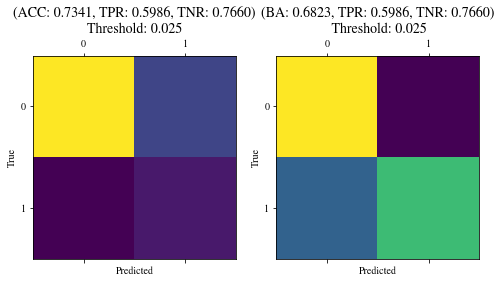

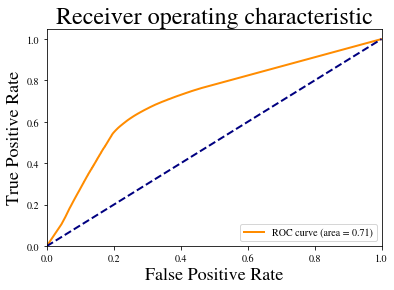

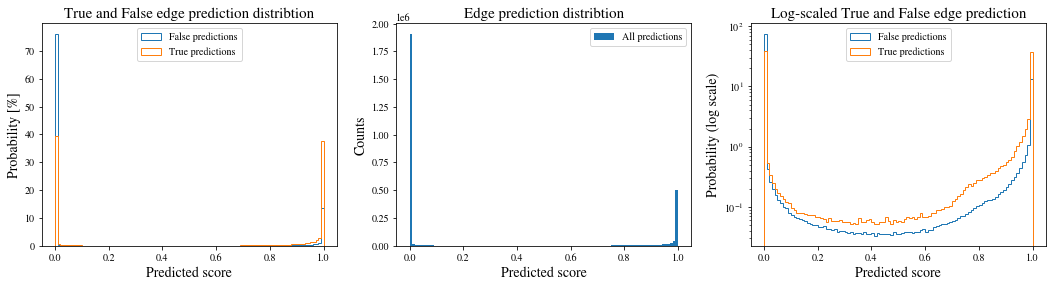

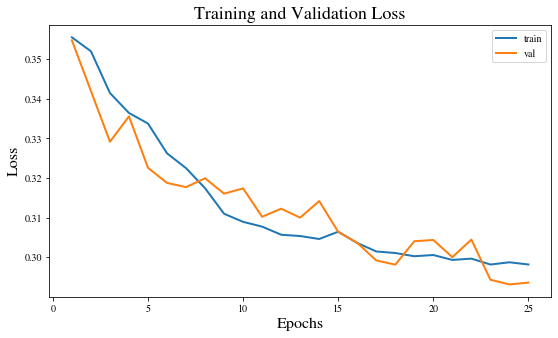

Training epoch 26:  15%|█▌        | 3/20 [00:00<00:01, 14.52it/s]

sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')


Training epoch 26:  25%|██▌       | 5/20 [00:00<00:01, 10.17it/s]

sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')
sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')


Training epoch 26:  35%|███▌      | 7/20 [00:00<00:01,  8.97it/s]

sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')


Training epoch 26:  45%|████▌     | 9/20 [00:00<00:01,  9.88it/s]

sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')


Training epoch 26:  55%|█████▌    | 11/20 [00:01<00:00, 10.38it/s]

sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')


Training epoch 26:  70%|███████   | 14/20 [00:01<00:00,  8.93it/s]

sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')


Training epoch 26:  80%|████████  | 16/20 [00:01<00:00,  9.17it/s]

sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')


Training epoch 26:  85%|████████▌ | 17/20 [00:01<00:00,  8.84it/s]

sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 26: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]

sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Epoch: 26, train loss: 0.2976
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_26_loss_0.2976.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.98it/s]


pred [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.42090392e-13
 9.21005070e-01 9.87717330e-01]
Epoch: 26, val loss: 0.2967


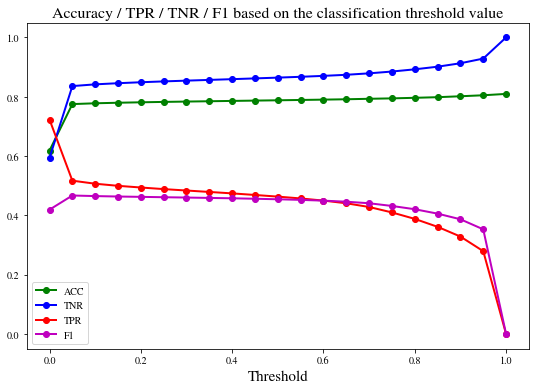

Chosen classification threshold is: 0.025
Edge labels: number of positive: 525768
Predictions: number of positive: 654580


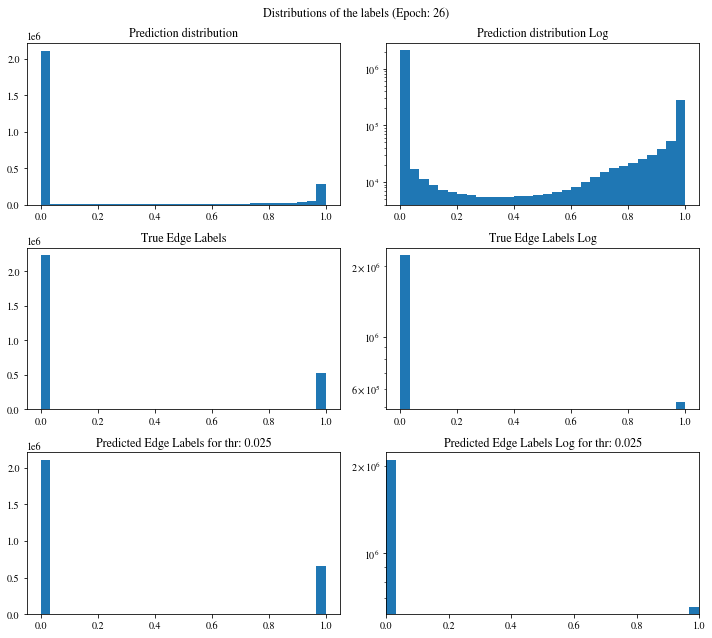

scores [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.42090392e-13
 9.21005070e-01 9.87717330e-01]
Confusion matrix:
[[1856510  378420]
 [ 249608  276160]]

Confusion matrix weighted:
[[0.41533963 0.08466037]
 [0.23737466 0.26262534]]

TN: 1856510 	 FN: 249608 	 TP: 276160 	 FP: 378420
Confusion matrix scaled:
[[0.67247848 0.13707403]
 [0.09041482 0.10003267]]

Accuracy: 0.7725
Precision: 0.4219
Negative predictive value: 0.8815
Recall: Correctly classifying 52.5251 % of positive edges
True negative rate: Correctly classifying 83.0679 % of all negative edges
F1 score: 0.4679
[0.63632685 0.75622271] [0.83067926 0.52525068] [0.72062893 0.61992156]
Balanced accuracy: 0.6780
Precision weighted: [0.63632685 0.75622271]
Recall weighted: [0.83067926 0.52525068]
F1 score weighted: [0.72062893 0.61992156]
positive_likelihood_ratio: 3.102104815504619, negative_likelihood_ratio: 0.5715194077687392


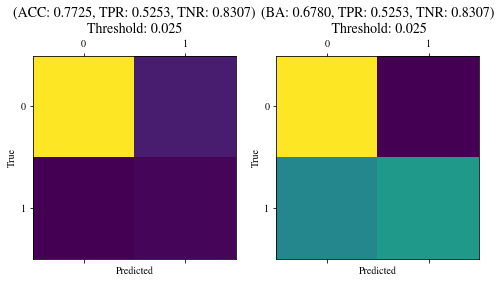

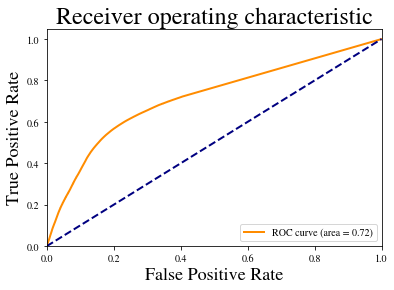

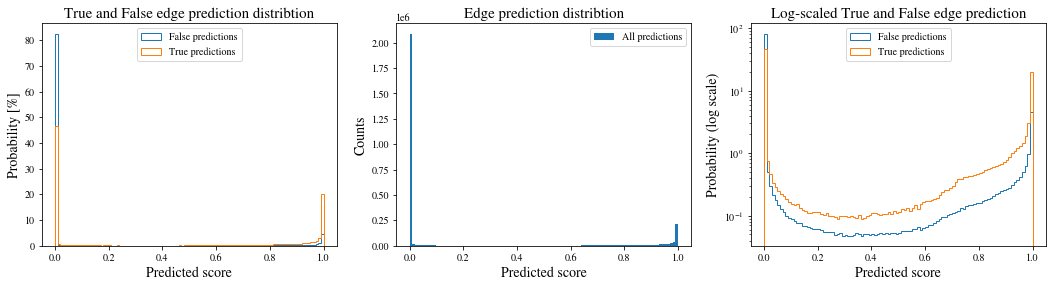

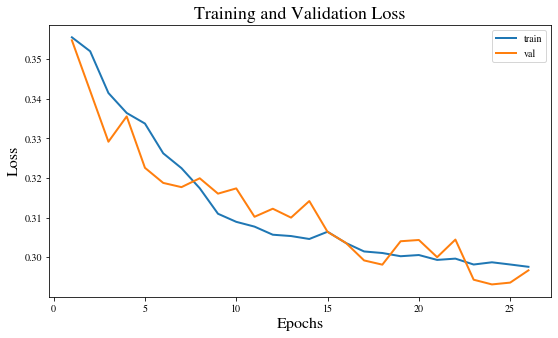

Training epoch 27:  10%|█         | 2/20 [00:00<00:01, 14.44it/s]

sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')


Training epoch 27:  20%|██        | 4/20 [00:00<00:01, 10.82it/s]

sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')


Training epoch 27:  30%|███       | 6/20 [00:00<00:01,  9.40it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')


Training epoch 27:  35%|███▌      | 7/20 [00:00<00:01,  9.04it/s]

sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')


Training epoch 27:  55%|█████▌    | 11/20 [00:01<00:00,  9.28it/s]

sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')


Training epoch 27:  65%|██████▌   | 13/20 [00:01<00:00,  8.94it/s]

sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')


Training epoch 27:  80%|████████  | 16/20 [00:01<00:00,  9.57it/s]

sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')


Training epoch 27:  90%|█████████ | 18/20 [00:01<00:00,  9.51it/s]

sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 27: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')
Epoch: 27, train loss: 0.2962
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_27_loss_0.2962.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]


pred [0.         0.         0.         ... 0.0619697  0.97539127 0.97533268]
Epoch: 27, val loss: 0.2917


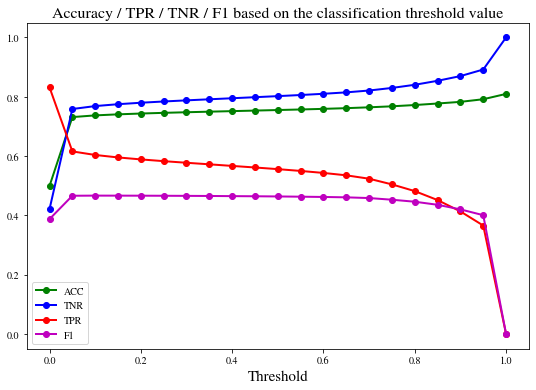

Chosen classification threshold is: 0.025
Edge labels: number of positive: 525768
Predictions: number of positive: 888738


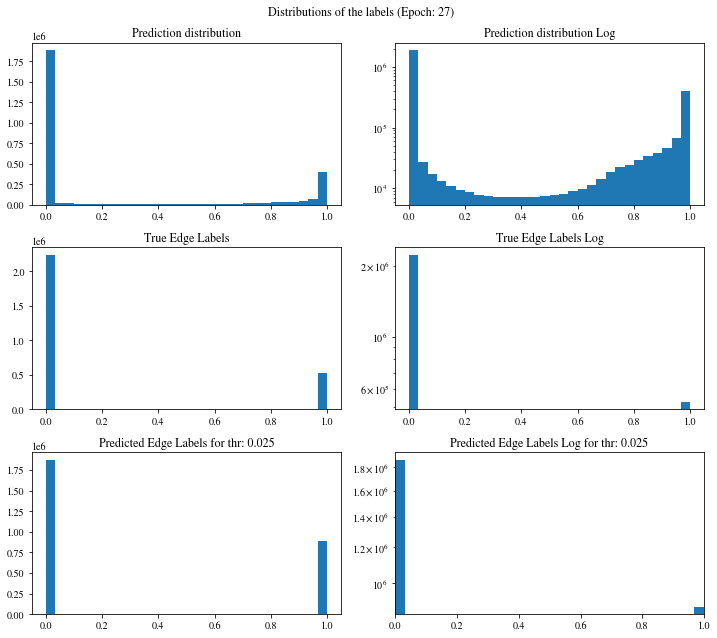

scores [0.         0.         0.         ... 0.0619697  0.97539127 0.97533268]
Confusion matrix:
[[1675325  559605]
 [ 196635  329133]]

Confusion matrix weighted:
[[0.3748048  0.1251952 ]
 [0.18699788 0.31300212]]

TN: 1675325 	 FN: 196635 	 TP: 329133 	 FP: 559605
Confusion matrix scaled:
[[0.60684834 0.20270417]
 [0.07122655 0.11922094]]

Accuracy: 0.7261
Precision: 0.3703
Negative predictive value: 0.8950
Recall: Correctly classifying 62.6004 % of positive edges
True negative rate: Correctly classifying 74.9610 % of all negative edges
F1 score: 0.4654
[0.6671467  0.71429493] [0.74960961 0.62600425] [0.70597826 0.66724156]
Balanced accuracy: 0.6878
Precision weighted: [0.6671467  0.71429493]
Recall weighted: [0.74960961 0.62600425]
F1 score weighted: [0.70597826 0.66724156]
positive_likelihood_ratio: 2.5001128792023137, negative_likelihood_ratio: 0.498920706271314


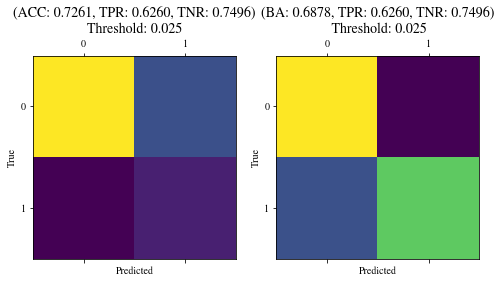

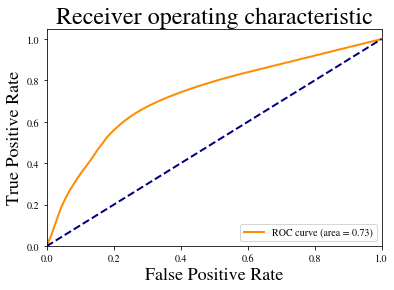

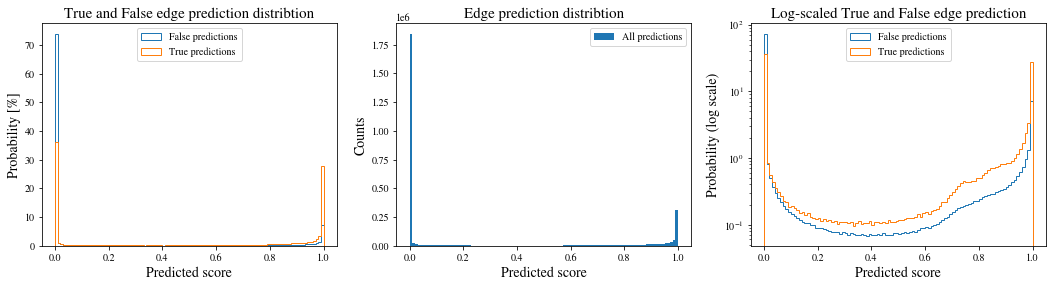

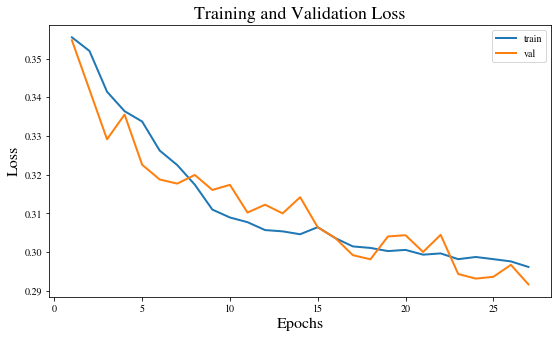

Training epoch 28:  10%|█         | 2/20 [00:00<00:01, 14.90it/s]

sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')


Training epoch 28:  20%|██        | 4/20 [00:00<00:01,  9.00it/s]

sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')


Training epoch 28:  30%|███       | 6/20 [00:00<00:01,  8.62it/s]

sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')


Training epoch 28:  40%|████      | 8/20 [00:00<00:01,  9.60it/s]

sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 28:  50%|█████     | 10/20 [00:01<00:01,  8.94it/s]

sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 28:  60%|██████    | 12/20 [00:01<00:00,  8.98it/s]

sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Training epoch 28:  75%|███████▌  | 15/20 [00:01<00:00,  9.87it/s]

sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')


Training epoch 28:  85%|████████▌ | 17/20 [00:01<00:00,  9.02it/s]

sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')


Training epoch 28: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]

sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')


Epoch: 28, train loss: 0.2953
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_28_loss_0.2953.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]


pred [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.34254391e-02
 7.31905311e-05 2.73391424e-06]
Epoch: 28, val loss: 0.2931


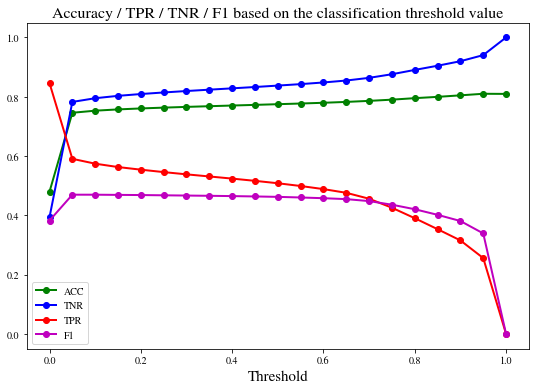

Chosen classification threshold is: 0.025
Edge labels: number of positive: 525768
Predictions: number of positive: 829782


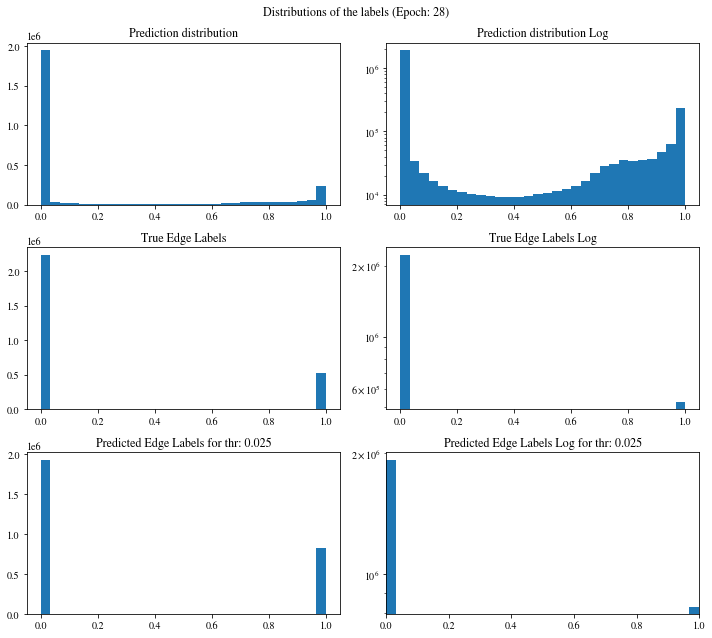

scores [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.34254391e-02
 7.31905311e-05 2.73391424e-06]
Confusion matrix:
[[1722885  512045]
 [ 208031  317737]]

Confusion matrix weighted:
[[0.38544496 0.11455504]
 [0.19783536 0.30216464]]

TN: 1722885 	 FN: 208031 	 TP: 317737 	 FP: 512045
Confusion matrix scaled:
[[0.62407587 0.18547664]
 [0.07535449 0.11509299]]

Accuracy: 0.7392
Precision: 0.3829
Negative predictive value: 0.8923
Recall: Correctly classifying 60.4329 % of positive edges
True negative rate: Correctly classifying 77.0890 % of all negative edges
F1 score: 0.4688
[0.66082285 0.72510288] [0.77088992 0.60432929] [0.71162552 0.65923018]
Balanced accuracy: 0.6876
Precision weighted: [0.66082285 0.72510288]
Recall weighted: [0.77088992 0.60432929]
F1 score weighted: [0.71162552 0.65923018]
positive_likelihood_ratio: 2.6377245183195677, negative_likelihood_ratio: 0.5132648720123845


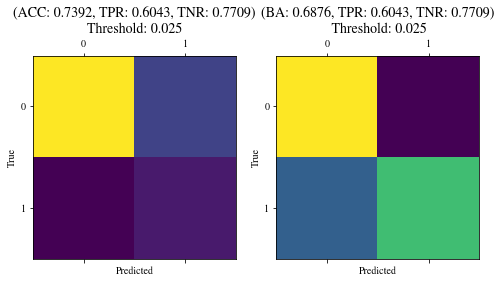

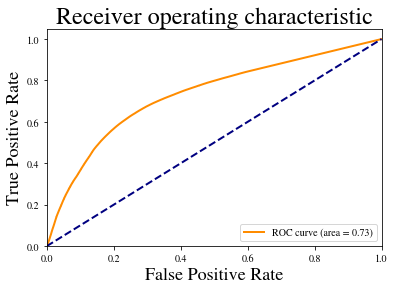

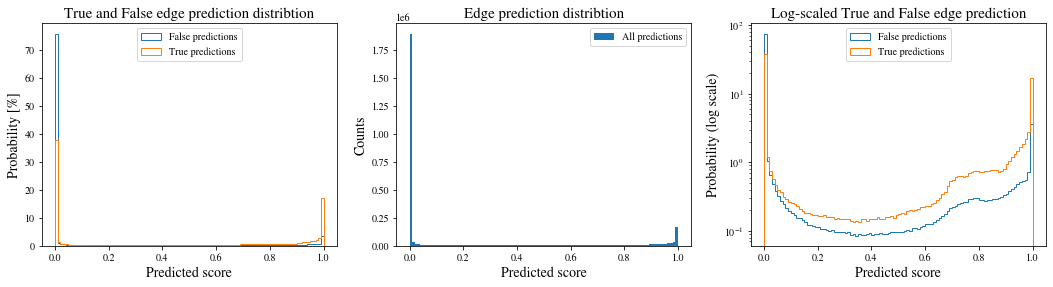

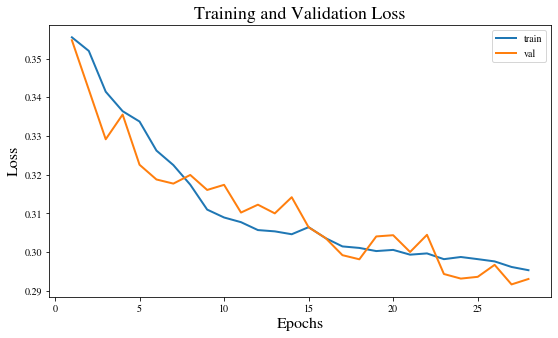

Training epoch 29:  10%|█         | 2/20 [00:00<00:01, 10.22it/s]

sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 29:  20%|██        | 4/20 [00:00<00:01,  9.51it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')


Training epoch 29:  35%|███▌      | 7/20 [00:00<00:01,  9.76it/s]

sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')


Training epoch 29:  40%|████      | 8/20 [00:00<00:01,  9.77it/s]

sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')
sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')


Training epoch 29:  60%|██████    | 12/20 [00:01<00:00, 10.94it/s]

sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')


Training epoch 29:  75%|███████▌  | 15/20 [00:01<00:00,  8.95it/s]

sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')


Training epoch 29:  80%|████████  | 16/20 [00:01<00:00,  8.71it/s]

sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')


Training epoch 29:  95%|█████████▌| 19/20 [00:02<00:00,  8.61it/s]

sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')
sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')


Training epoch 29: 100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
Epoch: 29, train loss: 0.2935
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_29_loss_0.2935.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.13it/s]


pred [0.         0.         0.         ... 0.01104938 0.24149422 0.77228981]
Epoch: 29, val loss: 0.2892


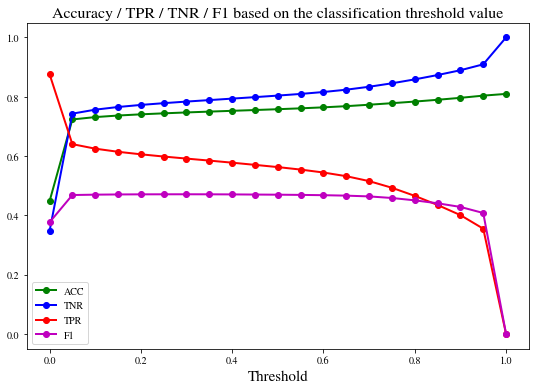

Chosen classification threshold is: 0.025
Edge labels: number of positive: 525768
Predictions: number of positive: 944408


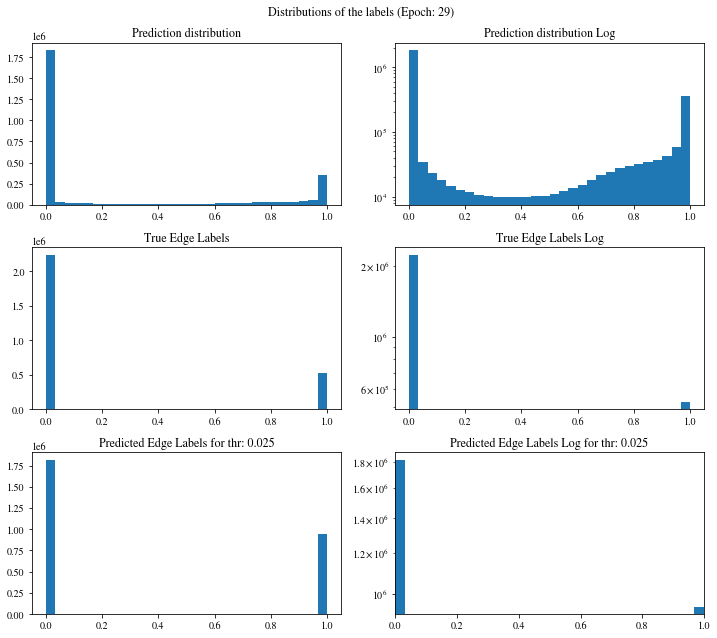

scores [0.         0.         0.         ... 0.01104938 0.24149422 0.77228981]
Confusion matrix:
[[1634003  600927]
 [ 182287  343481]]

Confusion matrix weighted:
[[0.36556022 0.13443978]
 [0.17335308 0.32664692]]

TN: 1634003 	 FN: 182287 	 TP: 343481 	 FP: 600927
Confusion matrix scaled:
[[0.59188039 0.21767212]
 [0.06602932 0.12441817]]

Accuracy: 0.7163
Precision: 0.3637
Negative predictive value: 0.8996
Recall: Correctly classifying 65.3294 % of positive edges
True negative rate: Correctly classifying 73.1120 % of all negative edges
F1 score: 0.4673
[0.67832845 0.70842842] [0.73112044 0.65329385] [0.70373576 0.67974496]
Balanced accuracy: 0.6922
Precision weighted: [0.67832845 0.70842842]
Recall weighted: [0.73112044 0.65329385]
F1 score weighted: [0.70373576 0.67974496]
positive_likelihood_ratio: 2.4296894967955622, negative_likelihood_ratio: 0.47421209126245994


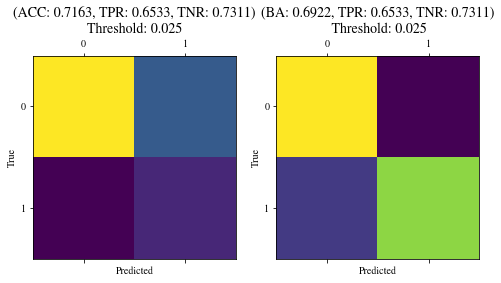

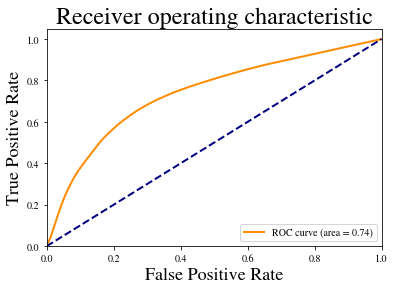

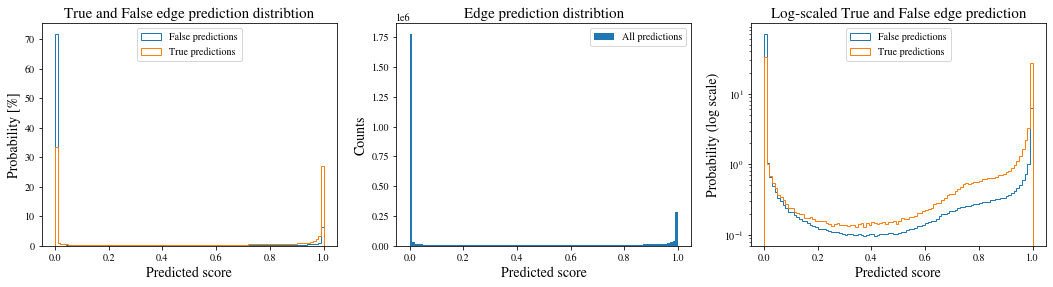

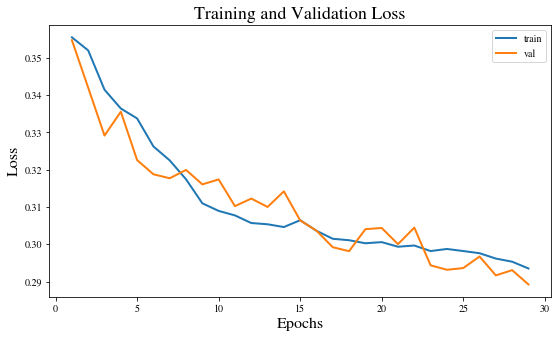

Training epoch 30:  10%|█         | 2/20 [00:00<00:01, 14.50it/s]

sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')


Training epoch 30:  20%|██        | 4/20 [00:00<00:01, 11.35it/s]

sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Training epoch 30:  30%|███       | 6/20 [00:00<00:01,  9.02it/s]

sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')


Training epoch 30:  35%|███▌      | 7/20 [00:00<00:01,  8.72it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Training epoch 30:  50%|█████     | 10/20 [00:01<00:01,  9.00it/s]

sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')


Training epoch 30:  60%|██████    | 12/20 [00:01<00:00,  8.08it/s]

sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 30:  75%|███████▌  | 15/20 [00:01<00:00,  9.49it/s]

sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 30:  85%|████████▌ | 17/20 [00:01<00:00,  9.32it/s]

sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')


Training epoch 30: 100%|██████████| 20/20 [00:02<00:00,  9.33it/s]

sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')


Epoch: 30, train loss: 0.2926
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_30_loss_0.2926.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.97it/s]


pred [3.93508007e-13 9.95542705e-01 9.98945773e-01 ... 3.60502042e-02
 7.97622740e-01 9.21901822e-01]
Epoch: 30, val loss: 0.2919


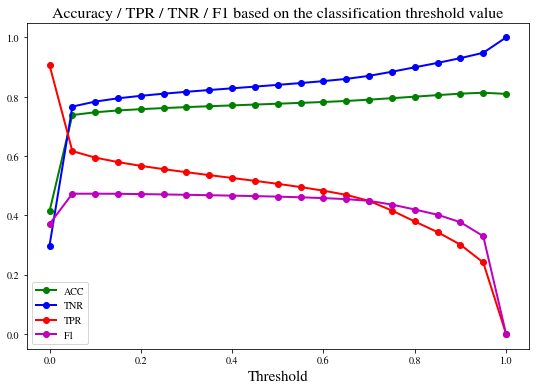

Chosen classification threshold is: 0.025
Edge labels: number of positive: 525768
Predictions: number of positive: 889298


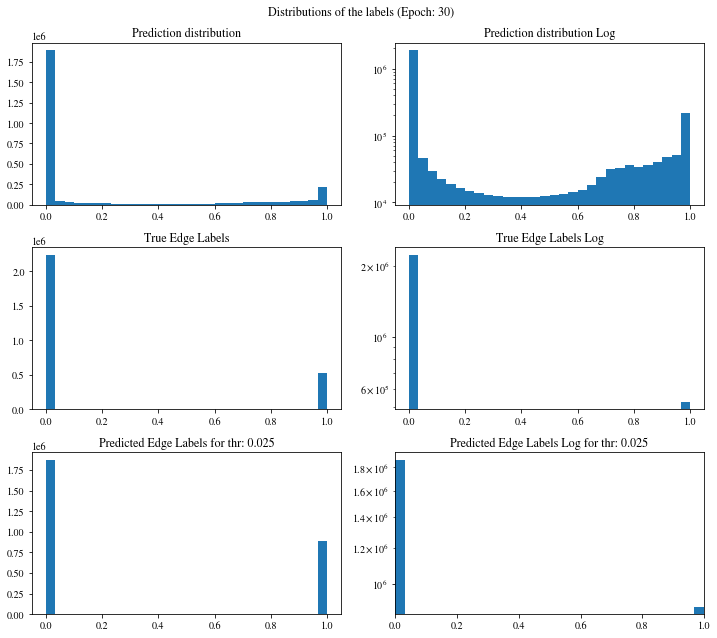

scores [3.93508007e-13 9.95542705e-01 9.98945773e-01 ... 3.60502042e-02
 7.97622740e-01 9.21901822e-01]
Confusion matrix:
[[1679759  555171]
 [ 191641  334127]]

Confusion matrix weighted:
[[0.37579678 0.12420322]
 [0.18224863 0.31775137]]

TN: 1679759 	 FN: 191641 	 TP: 334127 	 FP: 555171
Confusion matrix scaled:
[[0.60845446 0.20109806]
 [0.06941759 0.1210299 ]]

Accuracy: 0.7295
Precision: 0.3757
Negative predictive value: 0.8976
Recall: Correctly classifying 63.5503 % of positive edges
True negative rate: Correctly classifying 75.1594 % of all negative edges
F1 score: 0.4722
[0.67341612 0.71896837] [0.75159356 0.63550273] [0.7103604  0.67466388]
Balanced accuracy: 0.6935
Precision weighted: [0.67341612 0.71896837]
Recall weighted: [0.75159356 0.63550273]
F1 score weighted: [0.7103604  0.67466388]
positive_likelihood_ratio: 2.5583182823602044, negative_likelihood_ratio: 0.48496592717395953


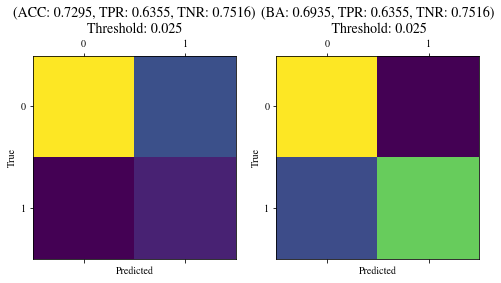

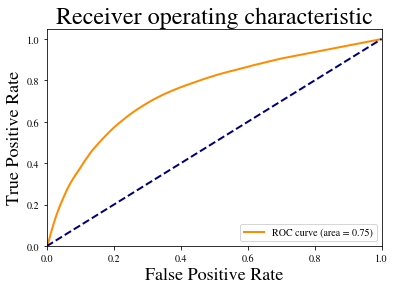

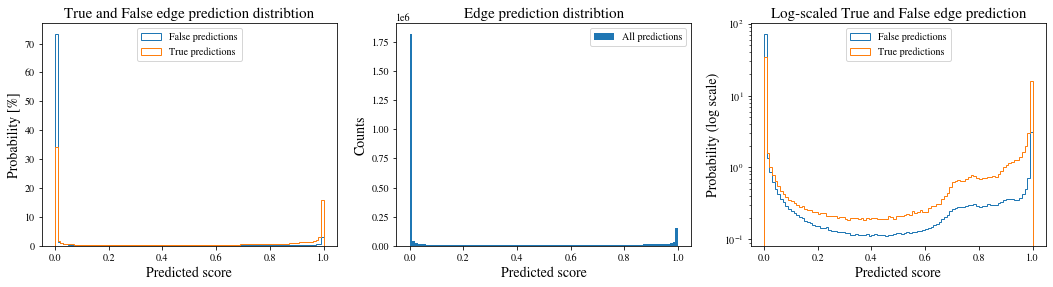

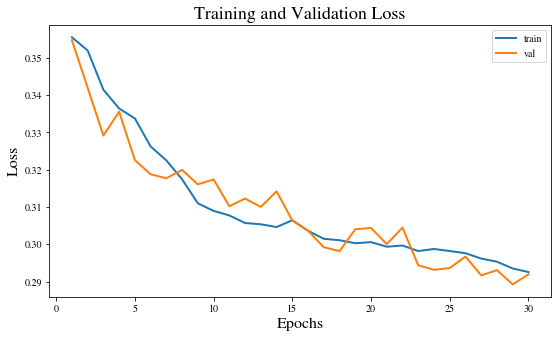

Training epoch 31:  10%|█         | 2/20 [00:00<00:01, 15.64it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')


Training epoch 31:  20%|██        | 4/20 [00:00<00:01, 10.25it/s]

sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 31:  30%|███       | 6/20 [00:00<00:01,  9.22it/s]

sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')


Training epoch 31:  40%|████      | 8/20 [00:00<00:01,  9.13it/s]

sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')


Training epoch 31:  55%|█████▌    | 11/20 [00:01<00:00, 10.11it/s]

sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')


Training epoch 31:  65%|██████▌   | 13/20 [00:01<00:00,  9.37it/s]

sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 31:  80%|████████  | 16/20 [00:01<00:00,  9.83it/s]

sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')


Training epoch 31:  90%|█████████ | 18/20 [00:01<00:00, 10.19it/s]

sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')
sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')


Training epoch 31: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]

sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')


Epoch: 31, train loss: 0.2925
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_31_loss_0.2925.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.10it/s]


pred [3.07749700e-27 0.00000000e+00 0.00000000e+00 ... 5.76448515e-02
 6.89658880e-01 7.45829020e-05]
Epoch: 31, val loss: 0.2884


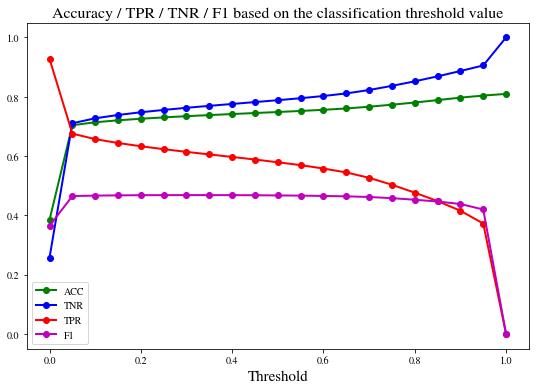

Chosen classification threshold is: 0.025
Edge labels: number of positive: 525768
Predictions: number of positive: 1041720


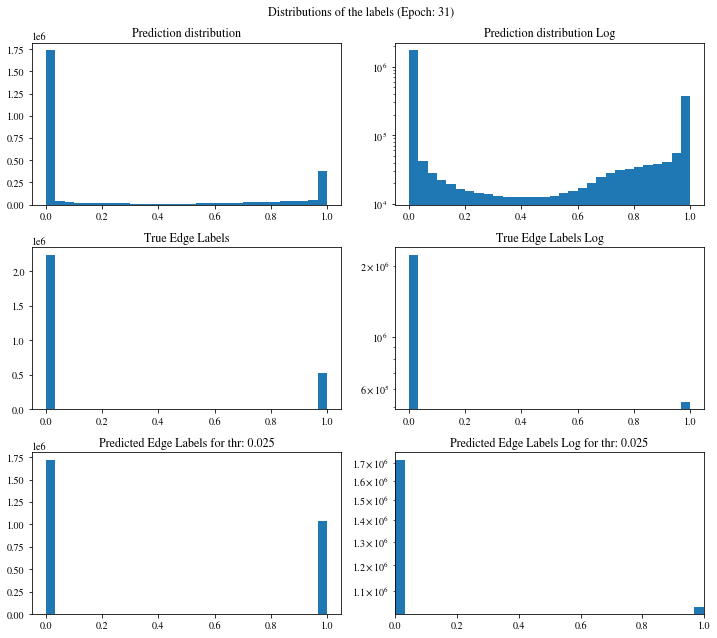

scores [3.07749700e-27 0.00000000e+00 0.00000000e+00 ... 5.76448515e-02
 6.89658880e-01 7.45829020e-05]
Confusion matrix:
[[1556250  678680]
 [ 162728  363040]]

Confusion matrix weighted:
[[0.34816527 0.15183473]
 [0.15475267 0.34524733]]

TN: 1556250 	 FN: 162728 	 TP: 363040 	 FP: 678680
Confusion matrix scaled:
[[0.56371613 0.24583638]
 [0.05894451 0.13150297]]

Accuracy: 0.6952
Precision: 0.3485
Negative predictive value: 0.9053
Recall: Correctly classifying 69.0495 % of positive edges
True negative rate: Correctly classifying 69.6331 % of all negative edges
F1 score: 0.4632
[0.69229042 0.69454796] [0.69633053 0.69049467] [0.6943046  0.69251538]
Balanced accuracy: 0.6934
Precision weighted: [0.69229042 0.69454796]
Recall weighted: [0.69633053 0.69049467]
F1 score weighted: [0.6943046  0.69251538]
positive_likelihood_ratio: 2.2738363378638082, negative_likelihood_ratio: 0.44448048463845186


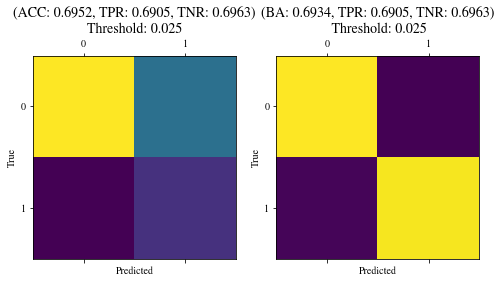

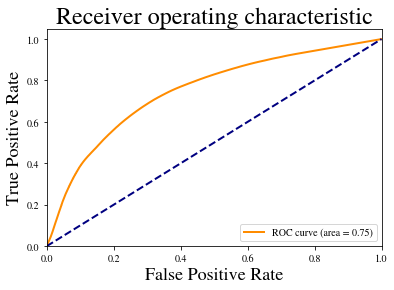

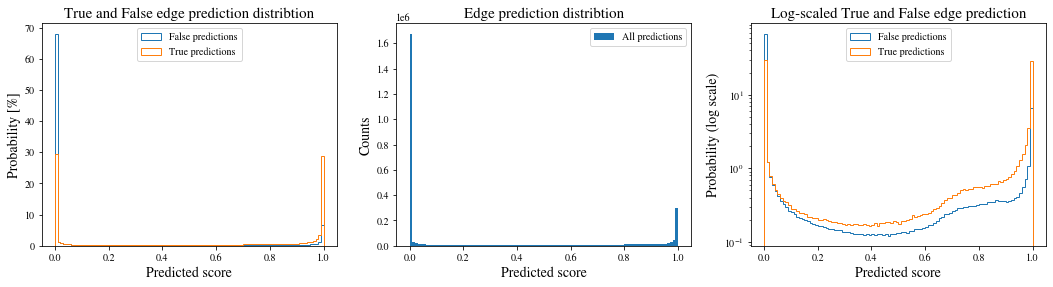

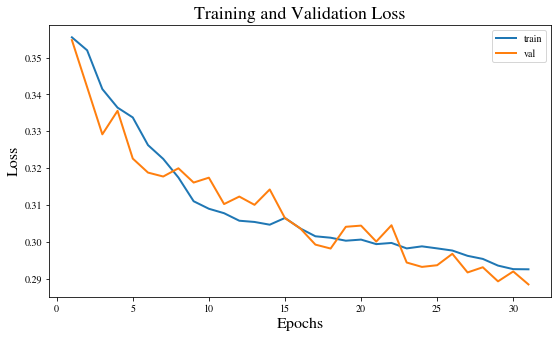

Training epoch 32:  10%|█         | 2/20 [00:00<00:01, 14.74it/s]

sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')


Training epoch 32:  20%|██        | 4/20 [00:00<00:01,  9.14it/s]

sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')
sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')


Training epoch 32:  30%|███       | 6/20 [00:00<00:01,  9.93it/s]

sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Training epoch 32:  40%|████      | 8/20 [00:00<00:01,  8.93it/s]

sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')


Training epoch 32:  50%|█████     | 10/20 [00:01<00:01,  9.26it/s]

sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')


Training epoch 32:  70%|███████   | 14/20 [00:01<00:00, 10.37it/s]

sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Training epoch 32:  80%|████████  | 16/20 [00:01<00:00,  9.00it/s]

sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 32:  90%|█████████ | 18/20 [00:01<00:00,  8.22it/s]

sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')


Training epoch 32: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')
Epoch: 32, train loss: 0.2911
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_32_loss_0.2911.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.93it/s]


pred [0.99933308 0.99898726 0.99946994 ... 0.21516286 0.99017489 0.99142963]
Epoch: 32, val loss: 0.2860


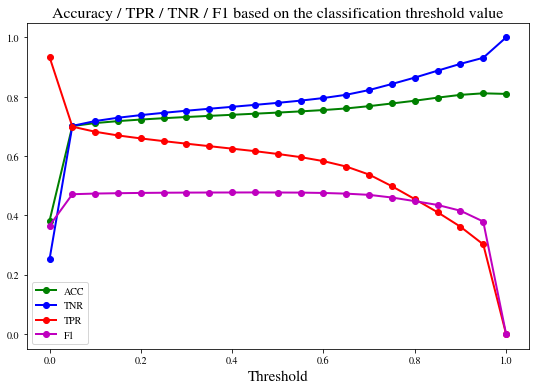

Chosen classification threshold is: 0.05
Edge labels: number of positive: 525768
Predictions: number of positive: 1034458


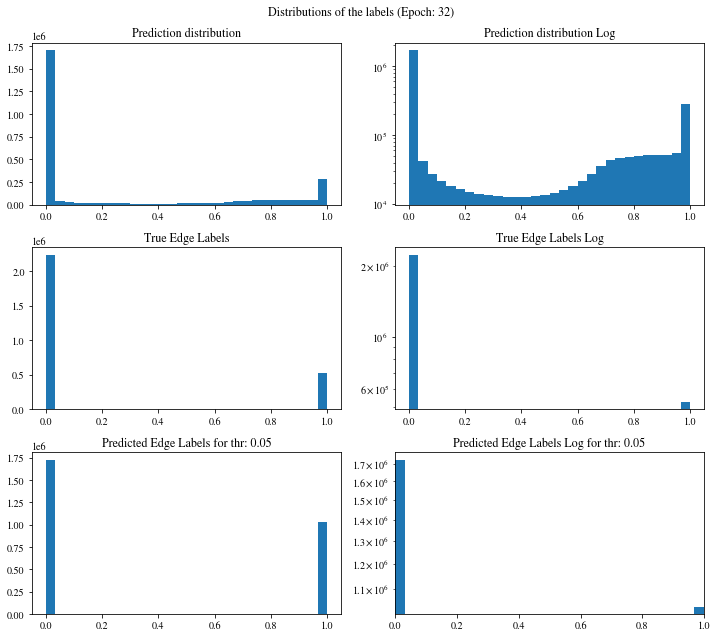

scores [0.99933308 0.99898726 0.99946994 ... 0.21516286 0.99017489 0.99142963]
Confusion matrix:
[[1568067  666863]
 [ 158173  367595]]

Confusion matrix weighted:
[[0.35080897 0.14919103]
 [0.15042091 0.34957909]]

TN: 1568067 	 FN: 158173 	 TP: 367595 	 FP: 666863
Confusion matrix scaled:
[[0.56799657 0.24155594]
 [0.05729457 0.13315292]]

Accuracy: 0.7011
Precision: 0.3554
Negative predictive value: 0.9084
Recall: Correctly classifying 69.9158 % of positive edges
True negative rate: Correctly classifying 70.1618 % of all negative edges
F1 score: 0.4712
[0.69989637 0.70088219] [0.70161795 0.69915818] [0.7007561  0.70001912]
Balanced accuracy: 0.7004
Precision weighted: [0.69989637 0.70088219]
Recall weighted: [0.70161795 0.69915818]
F1 score weighted: [0.7007561  0.70001912]
positive_likelihood_ratio: 2.3431643378092297, negative_likelihood_ratio: 0.4287829539142929


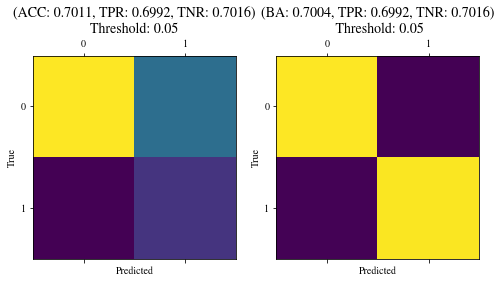

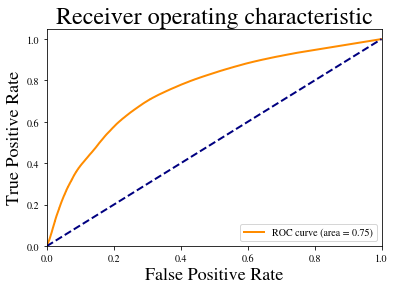

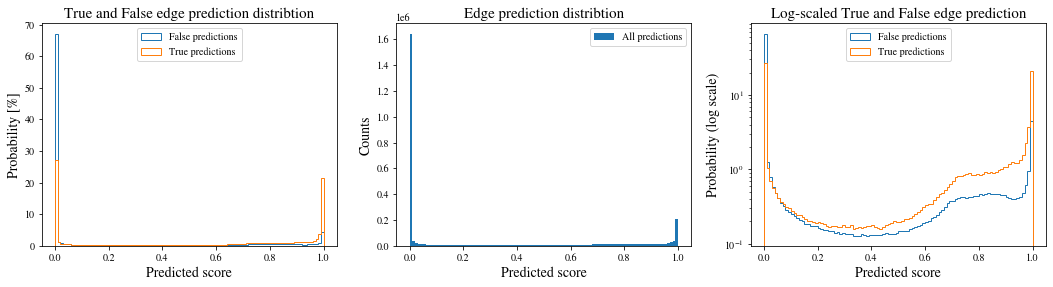

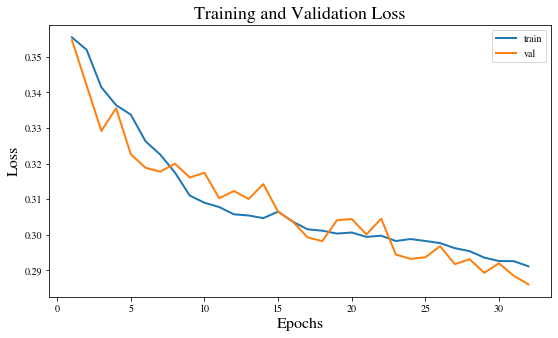

Training epoch 33:   0%|          | 0/20 [00:00<?, ?it/s]

sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Training epoch 33:  25%|██▌       | 5/20 [00:00<00:01, 11.04it/s]

sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Training epoch 33:  35%|███▌      | 7/20 [00:00<00:01,  9.75it/s]

sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')


Training epoch 33:  45%|████▌     | 9/20 [00:00<00:01, 10.19it/s]

sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')


Training epoch 33:  60%|██████    | 12/20 [00:01<00:00,  9.05it/s]

sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')


Training epoch 33:  70%|███████   | 14/20 [00:01<00:00,  8.72it/s]

sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')


Training epoch 33:  80%|████████  | 16/20 [00:01<00:00,  8.33it/s]

sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')


Training epoch 33:  90%|█████████ | 18/20 [00:01<00:00,  9.17it/s]

sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 33: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
Epoch: 33, train loss: 0.2906
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_33_loss_0.2906.pt


Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.18it/s]


pred [5.63217838e-38 1.11922964e-37 0.00000000e+00 ... 2.46965498e-01
 7.95998514e-01 1.15052797e-01]
Epoch: 33, val loss: 0.2855


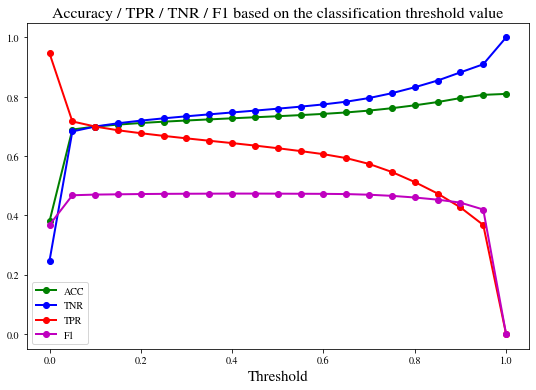

Chosen classification threshold is: 0.1
Edge labels: number of positive: 525768
Predictions: number of positive: 1039309


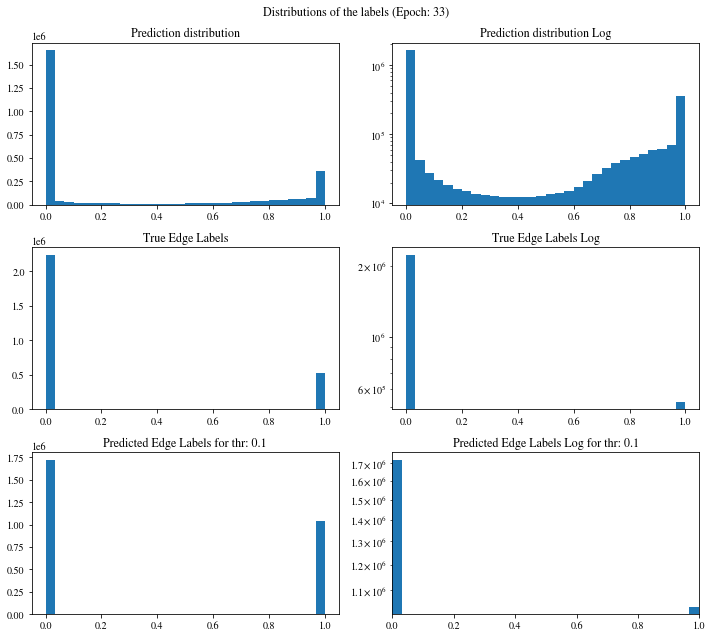

scores [5.63217838e-38 1.11922964e-37 0.00000000e+00 ... 2.46965498e-01
 7.95998514e-01 1.15052797e-01]
Confusion matrix:
[[1563380  671550]
 [ 158009  367759]]

Confusion matrix weighted:
[[0.3497604  0.1502396 ]
 [0.15026495 0.34973505]]

TN: 1563380 	 FN: 158009 	 TP: 367759 	 FP: 671550
Confusion matrix scaled:
[[0.56629881 0.2432537 ]
 [0.05723516 0.13321233]]

Accuracy: 0.6995
Precision: 0.3538
Negative predictive value: 0.9082
Recall: Correctly classifying 69.9470 % of positive edges
True negative rate: Correctly classifying 69.9521 % of all negative edges
F1 score: 0.4700
[0.69948534 0.69950556] [0.69952079 0.69947011] [0.69950306 0.69948783]
Balanced accuracy: 0.6995
Precision weighted: [0.69948534 0.69950556]
Recall weighted: [0.69952079 0.69947011]
F1 score weighted: [0.69950306 0.69948783]
positive_likelihood_ratio: 2.327848603328317, negative_likelihood_ratio: 0.429622529669606


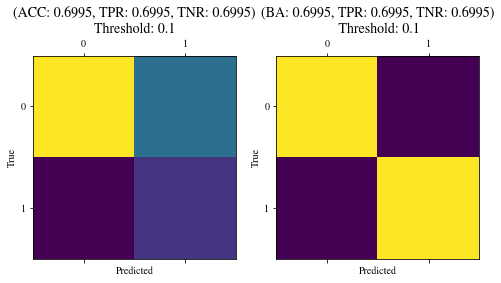

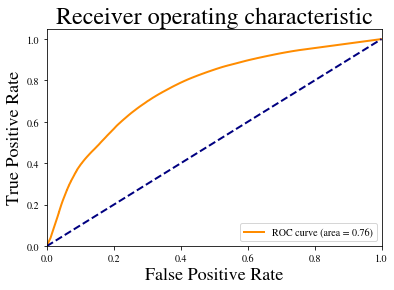

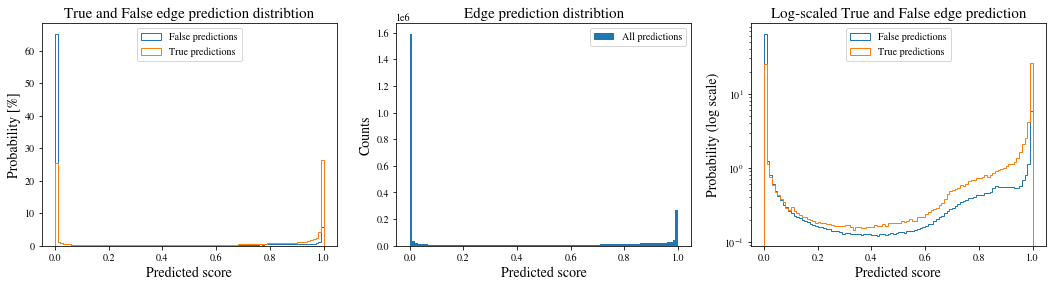

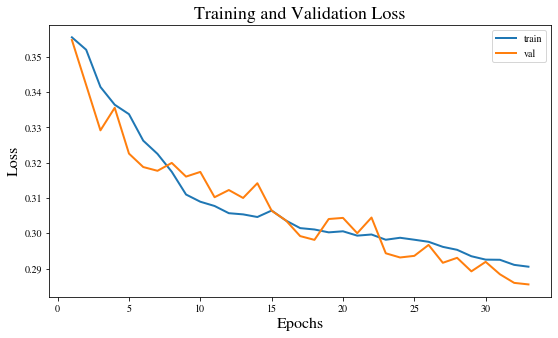

Training epoch 34:  10%|█         | 2/20 [00:00<00:01, 15.32it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')


Training epoch 34:  20%|██        | 4/20 [00:00<00:01, 10.89it/s]

sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')


Training epoch 34:  30%|███       | 6/20 [00:00<00:01, 10.89it/s]

sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 34:  40%|████      | 8/20 [00:00<00:01, 10.05it/s]

sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Training epoch 34:  50%|█████     | 10/20 [00:01<00:01,  9.15it/s]

sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 34:  60%|██████    | 12/20 [00:01<00:00,  9.28it/s]

sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')


Training epoch 34:  80%|████████  | 16/20 [00:01<00:00,  9.39it/s]

sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')


Training epoch 34:  90%|█████████ | 18/20 [00:01<00:00,  8.57it/s]

sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')


Training epoch 34: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')
Epoch: 34, train loss: 0.2893
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_34_loss_0.2893.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.01it/s]


pred [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.12348081e-04
 7.38689423e-01 7.39436757e-07]
Epoch: 34, val loss: 0.2861


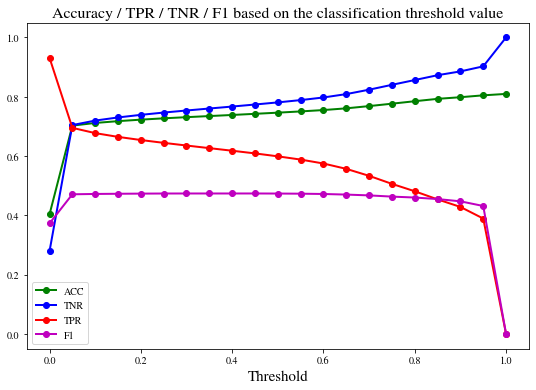

Chosen classification threshold is: 0.05
Edge labels: number of positive: 525768
Predictions: number of positive: 1026104


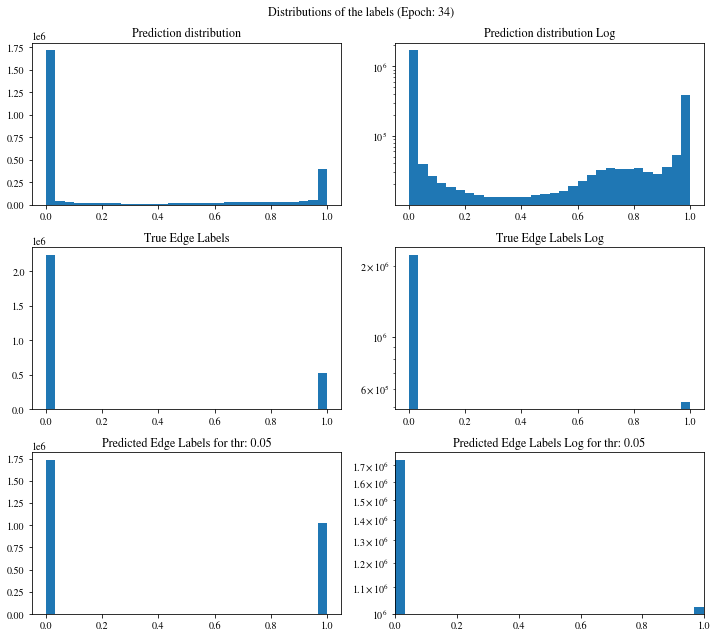

scores [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.12348081e-04
 7.38689423e-01 7.39436757e-07]
Confusion matrix:
[[1574270  660660]
 [ 160324  365444]]

Confusion matrix weighted:
[[0.35219671 0.14780329]
 [0.15246649 0.34753351]]

TN: 1574270 	 FN: 160324 	 TP: 365444 	 FP: 660660
Confusion matrix scaled:
[[0.57024347 0.23930904]
 [0.05807372 0.13237377]]

Accuracy: 0.7026
Precision: 0.3561
Negative predictive value: 0.9076
Recall: Correctly classifying 69.5067 % of positive edges
True negative rate: Correctly classifying 70.4393 % of all negative edges
F1 score: 0.4710
[0.69788467 0.70161053] [0.70439343 0.69506703] [0.70112394 0.69832345]
Balanced accuracy: 0.6997
Precision weighted: [0.69788467 0.70161053]
Recall weighted: [0.70439343 0.69506703]
F1 score weighted: [0.70112394 0.69832345]
positive_likelihood_ratio: 2.3513246569834956, negative_likelihood_ratio: 0.4329015048989587


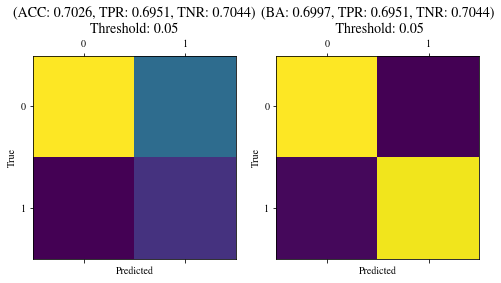

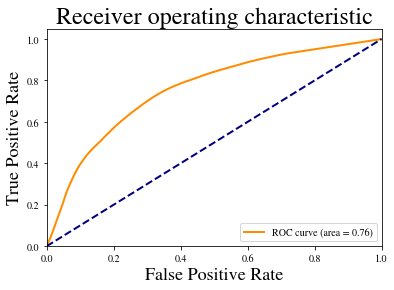

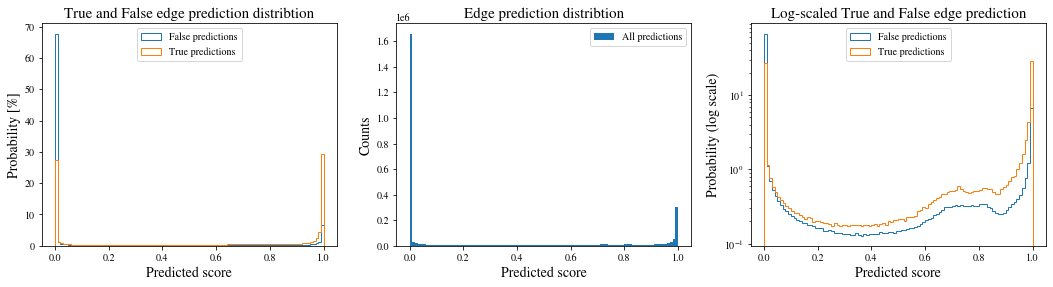

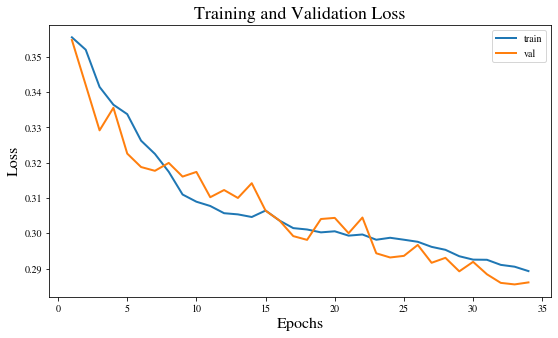

Training epoch 35:  10%|█         | 2/20 [00:00<00:01, 13.26it/s]

sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 35:  20%|██        | 4/20 [00:00<00:01, 10.26it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Training epoch 35:  30%|███       | 6/20 [00:00<00:01,  9.82it/s]

sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')


Training epoch 35:  40%|████      | 8/20 [00:00<00:01,  9.99it/s]

sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')


Training epoch 35:  50%|█████     | 10/20 [00:01<00:01,  9.25it/s]

sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')


Training epoch 35:  70%|███████   | 14/20 [00:01<00:00,  9.44it/s]

sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')


Training epoch 35:  75%|███████▌  | 15/20 [00:01<00:00,  9.15it/s]

sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')


Training epoch 35:  95%|█████████▌| 19/20 [00:02<00:00,  8.65it/s]

sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')


Training epoch 35: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


Epoch: 35, train loss: 0.2892
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_35_loss_0.2892.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.05it/s]


pred [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.91130224e-04
 9.98419819e-06 1.75421633e-06]
Epoch: 35, val loss: 0.2857


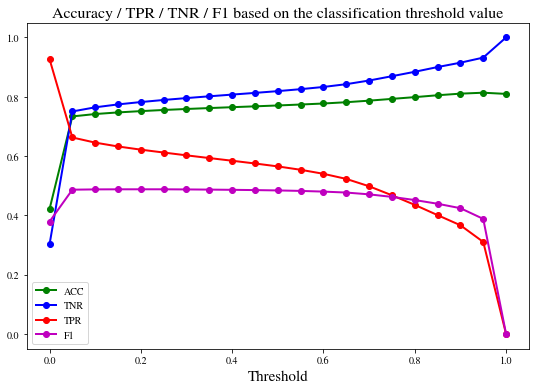

Chosen classification threshold is: 0.025
Edge labels: number of positive: 525768
Predictions: number of positive: 941298


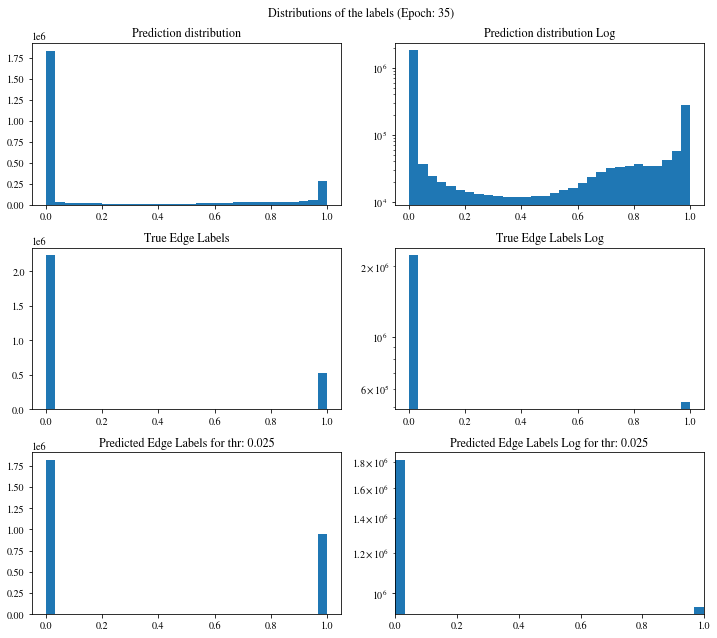

scores [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.91130224e-04
 9.98419819e-06 1.75421633e-06]
Confusion matrix:
[[1649413  585517]
 [ 169987  355781]]

Confusion matrix weighted:
[[0.36900775 0.13099225]
 [0.1616559  0.3383441 ]]

TN: 1649413 	 FN: 169987 	 TP: 355781 	 FP: 585517
Confusion matrix scaled:
[[0.59746231 0.2120902 ]
 [0.06157392 0.12887357]]

Accuracy: 0.7263
Precision: 0.3780
Negative predictive value: 0.9066
Recall: Correctly classifying 67.6688 % of positive edges
True negative rate: Correctly classifying 73.8016 % of all negative edges
F1 score: 0.4850
[0.69537032 0.72089899] [0.73801551 0.6766882 ] [0.71605854 0.69809432]
Balanced accuracy: 0.7074
Precision weighted: [0.69537032 0.72089899]
Recall weighted: [0.73801551 0.6766882 ]
F1 score weighted: [0.71605854 0.69809432]
positive_likelihood_ratio: 2.5829322671928967, negative_likelihood_ratio: 0.4380826680219063


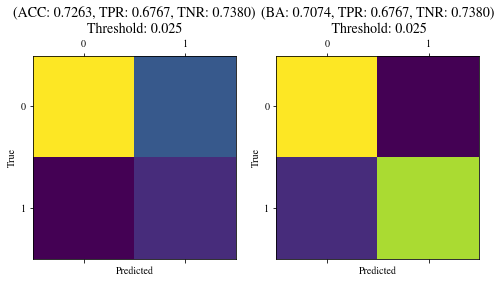

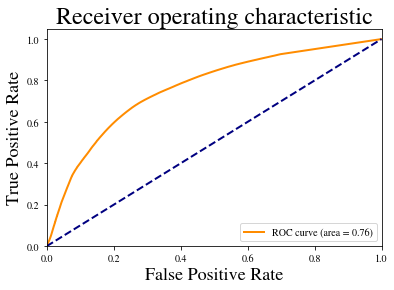

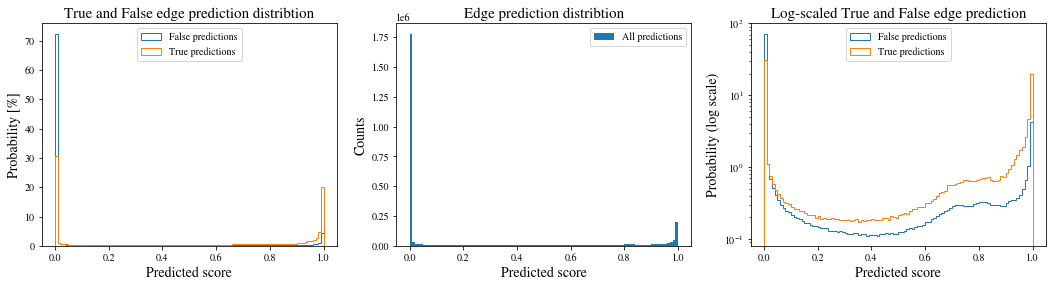

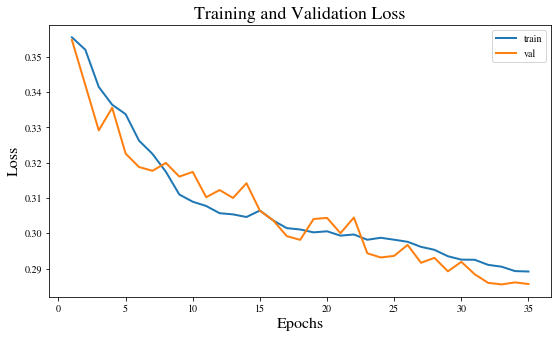

Training epoch 36:  10%|█         | 2/20 [00:00<00:01, 11.86it/s]

sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')


Training epoch 36:  20%|██        | 4/20 [00:00<00:01, 10.74it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')


Training epoch 36:  30%|███       | 6/20 [00:00<00:01, 12.04it/s]

sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Training epoch 36:  40%|████      | 8/20 [00:00<00:01, 10.27it/s]

sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 36:  50%|█████     | 10/20 [00:00<00:01,  9.41it/s]

sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')


Training epoch 36:  70%|███████   | 14/20 [00:01<00:00,  9.50it/s]

sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')


Training epoch 36:  80%|████████  | 16/20 [00:01<00:00,  8.77it/s]

sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')
sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')


Training epoch 36:  90%|█████████ | 18/20 [00:01<00:00,  8.78it/s]

sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')


Training epoch 36: 100%|██████████| 20/20 [00:02<00:00,  9.38it/s]

sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
Epoch: 36, train loss: 0.2886
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_36_loss_0.2886.pt


Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.19it/s]


pred [7.33052467e-21 0.00000000e+00 0.00000000e+00 ... 6.08210900e-22
 1.19603797e-11 8.91748015e-18]
Epoch: 36, val loss: 0.2830


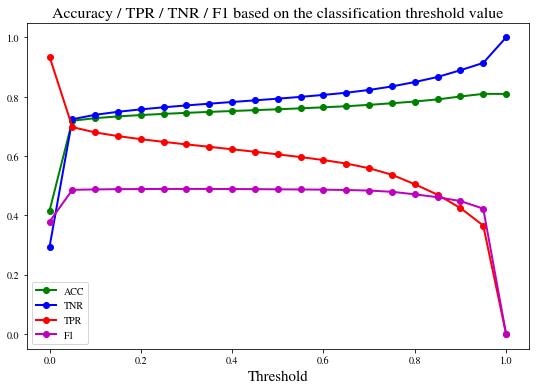

Chosen classification threshold is: 0.025
Edge labels: number of positive: 525768
Predictions: number of positive: 1019863


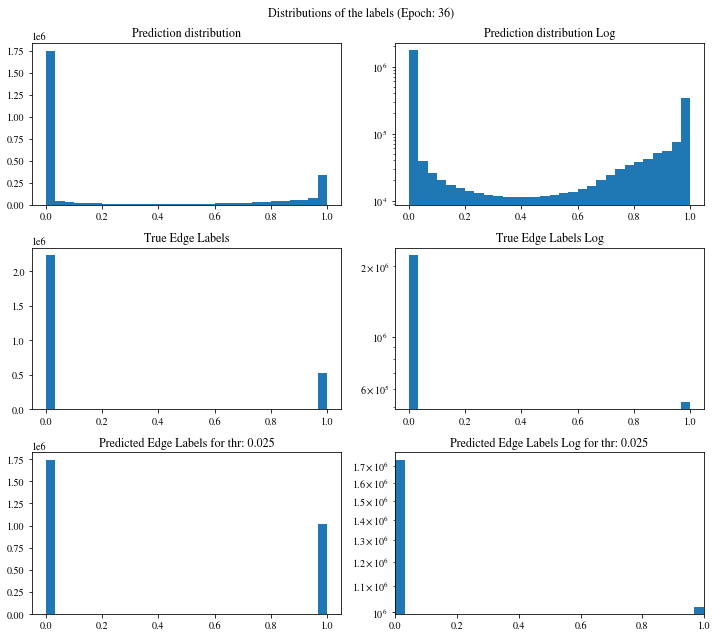

scores [7.33052467e-21 0.00000000e+00 0.00000000e+00 ... 6.08210900e-22
 1.19603797e-11 8.91748015e-18]
Confusion matrix:
[[1589462  645468]
 [ 151373  374395]]

Confusion matrix weighted:
[[0.35559548 0.14440452]
 [0.14395418 0.35604582]]

TN: 1589462 	 FN: 151373 	 TP: 374395 	 FP: 645468
Confusion matrix scaled:
[[0.57574642 0.23380609]
 [0.05483142 0.13561607]]

Accuracy: 0.7114
Precision: 0.3671
Negative predictive value: 0.9130
Recall: Correctly classifying 71.2092 % of positive edges
True negative rate: Correctly classifying 71.1191 % of all negative edges
F1 score: 0.4845
[0.71183209 0.71145085] [0.71119095 0.71209164] [0.71151138 0.7117711 ]
Balanced accuracy: 0.7116
Precision weighted: [0.71183209 0.71145085]
Recall weighted: [0.71119095 0.71209164]
F1 score weighted: [0.71151138 0.7117711 ]
positive_likelihood_ratio: 2.465614066265583, negative_likelihood_ratio: 0.40482567049459917


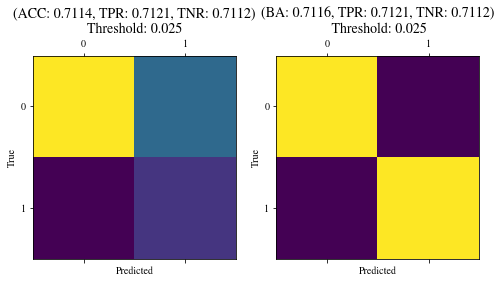

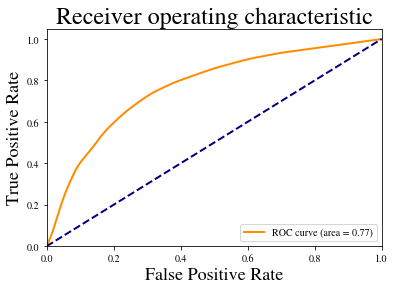

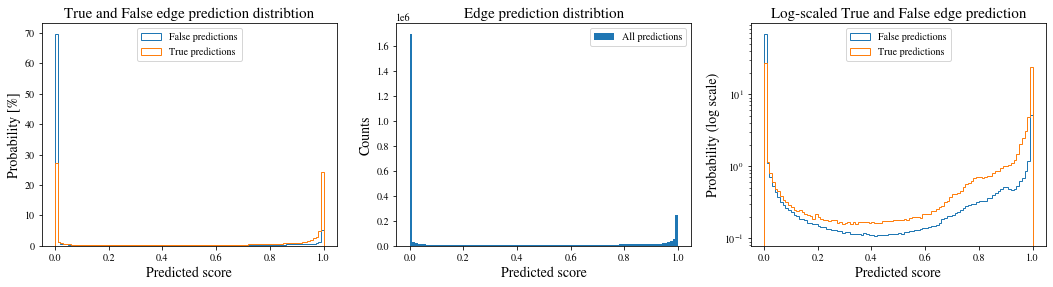

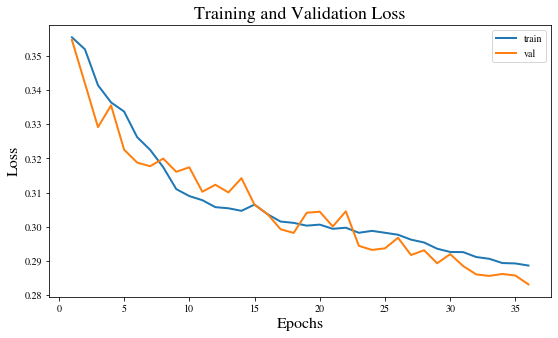

Training epoch 37:  10%|█         | 2/20 [00:00<00:01, 10.24it/s]

sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 37:  20%|██        | 4/20 [00:00<00:01,  8.96it/s]

sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')


Training epoch 37:  30%|███       | 6/20 [00:00<00:01, 10.07it/s]

sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')


Training epoch 37:  45%|████▌     | 9/20 [00:01<00:01,  8.48it/s]

sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')


Training epoch 37:  50%|█████     | 10/20 [00:01<00:01,  8.41it/s]

sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')


Training epoch 37:  75%|███████▌  | 15/20 [00:01<00:00, 10.03it/s]

sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')


Training epoch 37:  85%|████████▌ | 17/20 [00:01<00:00,  9.91it/s]

sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')
sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')


Training epoch 37:  95%|█████████▌| 19/20 [00:02<00:00,  9.55it/s]

sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')


Training epoch 37: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
Epoch: 37, train loss: 0.2861
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_37_loss_0.2861.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.22it/s]


pred [1.92089907e-16 1.00000000e+00 1.00000000e+00 ... 2.13096828e-05
 1.41696432e-06 1.29451607e-07]
Epoch: 37, val loss: 0.2802


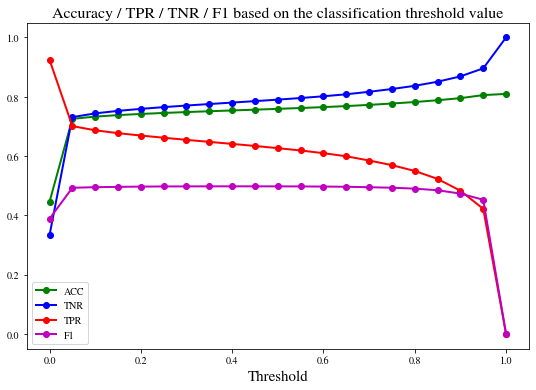

Chosen classification threshold is: 0.025
Edge labels: number of positive: 525768
Predictions: number of positive: 1000625


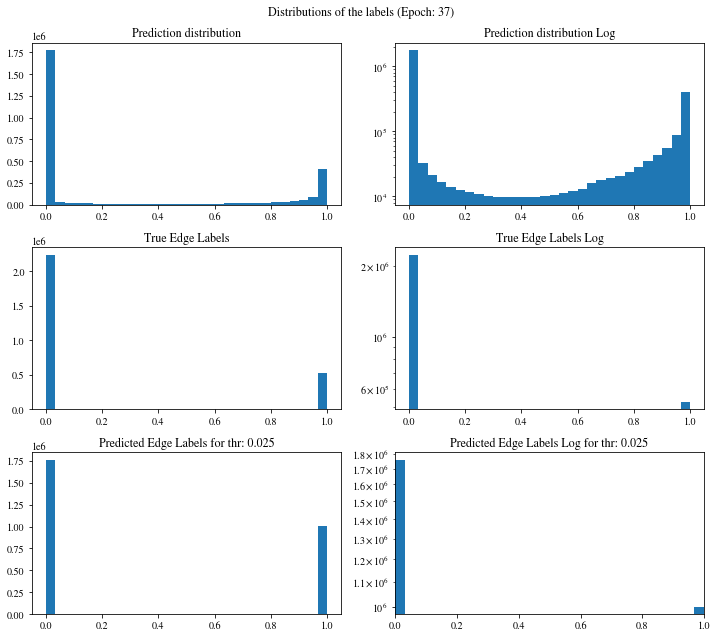

scores [1.92089907e-16 1.00000000e+00 1.00000000e+00 ... 2.13096828e-05
 1.41696432e-06 1.29451607e-07]
Confusion matrix:
[[1608931  625999]
 [ 151142  374626]]

Confusion matrix weighted:
[[0.35995109 0.14004891]
 [0.1437345  0.3562655 ]]

TN: 1608931 	 FN: 151142 	 TP: 374626 	 FP: 625999
Confusion matrix scaled:
[[0.58279863 0.22675389]
 [0.05474775 0.13569974]]

Accuracy: 0.7185
Precision: 0.3744
Negative predictive value: 0.9141
Recall: Correctly classifying 71.2531 % of positive edges
True negative rate: Correctly classifying 71.9902 % of all negative edges
F1 score: 0.4909
[0.71463448 0.7178222 ] [0.71990219 0.712531  ] [0.71725867 0.71516682]
Balanced accuracy: 0.7162
Precision weighted: [0.71463448 0.7178222 ]
Recall weighted: [0.71990219 0.712531  ]
F1 score weighted: [0.71725867 0.71516682]
positive_likelihood_ratio: 2.5438649469039776, negative_likelihood_ratio: 0.39931674329294226


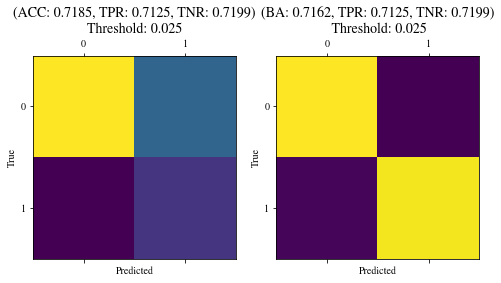

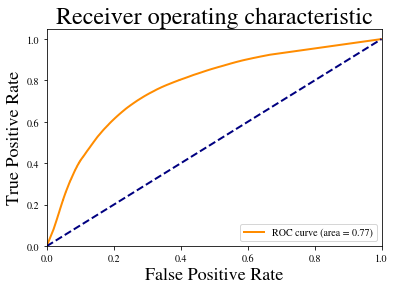

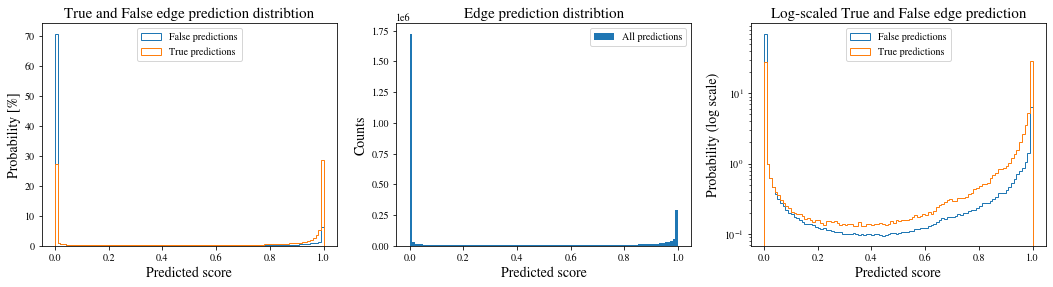

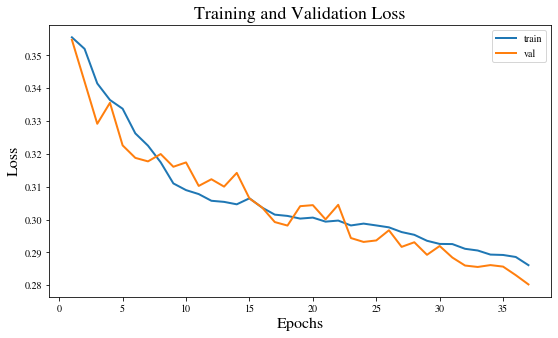

Training epoch 38:  10%|█         | 2/20 [00:00<00:01, 16.45it/s]

sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')


Training epoch 38:  20%|██        | 4/20 [00:00<00:01, 12.66it/s]

sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')
sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')


Training epoch 38:  30%|███       | 6/20 [00:00<00:01, 11.00it/s]

sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')


Training epoch 38:  40%|████      | 8/20 [00:00<00:01,  9.73it/s]

sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')


Training epoch 38:  50%|█████     | 10/20 [00:01<00:01,  8.96it/s]

sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Training epoch 38:  65%|██████▌   | 13/20 [00:01<00:00,  8.95it/s]

sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')
sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')


Training epoch 38:  75%|███████▌  | 15/20 [00:01<00:00,  8.92it/s]

sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')


Training epoch 38:  85%|████████▌ | 17/20 [00:01<00:00,  8.55it/s]

sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')
sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')


Training epoch 38:  95%|█████████▌| 19/20 [00:02<00:00,  9.04it/s]

sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')


Training epoch 38: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


Epoch: 38, train loss: 0.2890
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_38_loss_0.2890.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.54it/s]


pred [0.99942446 0.99927217 0.99950898 ... 0.32986185 0.7804358  0.15103847]
Epoch: 38, val loss: 0.2819


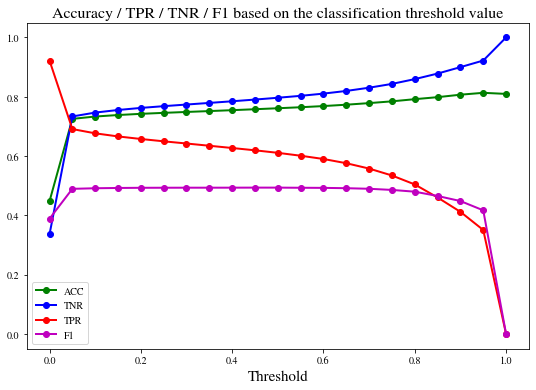

Chosen classification threshold is: 0.025
Edge labels: number of positive: 525768
Predictions: number of positive: 991123


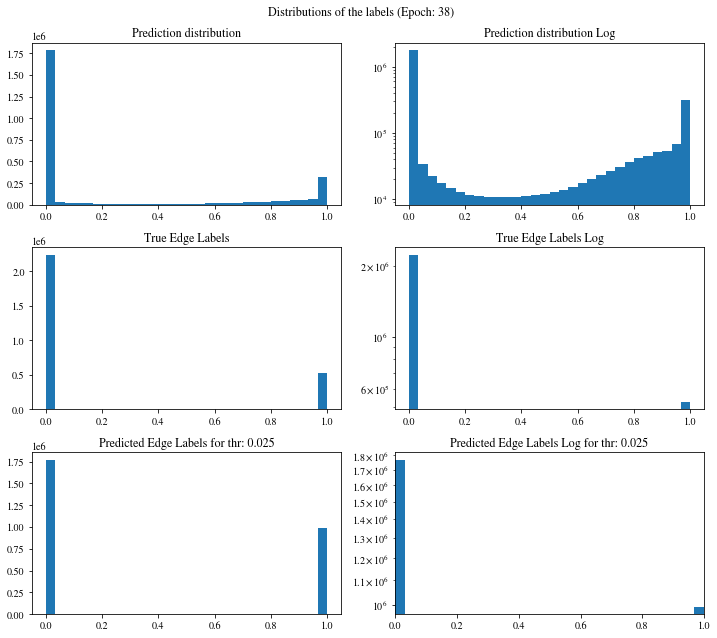

scores [0.99942446 0.99927217 0.99950898 ... 0.32986185 0.7804358  0.15103847]
Confusion matrix:
[[1613637  621293]
 [ 155938  369830]]

Confusion matrix weighted:
[[0.36100392 0.13899608]
 [0.14829545 0.35170455]]

TN: 1613637 	 FN: 155938 	 TP: 369830 	 FP: 621293
Confusion matrix scaled:
[[0.58450327 0.22504924]
 [0.05648499 0.1339625 ]]

Accuracy: 0.7185
Precision: 0.3731
Negative predictive value: 0.9119
Recall: Correctly classifying 70.3409 % of positive edges
True negative rate: Correctly classifying 72.2008 % of all negative edges
F1 score: 0.4876
[0.7088246  0.71673956] [0.72200785 0.70340911] [0.71535549 0.71001177]
Balanced accuracy: 0.7127
Precision weighted: [0.7088246  0.71673956]
Recall weighted: [0.72200785 0.70340911]
F1 score weighted: [0.71535549 0.71001177]
positive_likelihood_ratio: 2.530320023224165, negative_likelihood_ratio: 0.41078624362913646


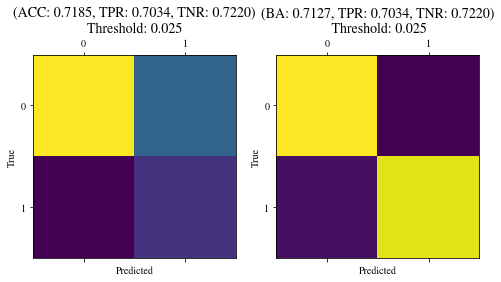

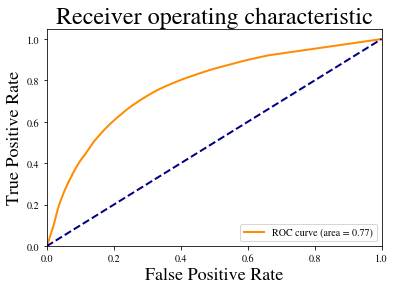

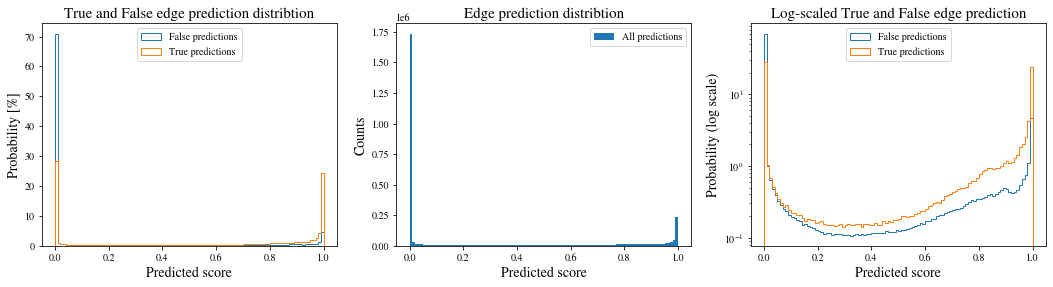

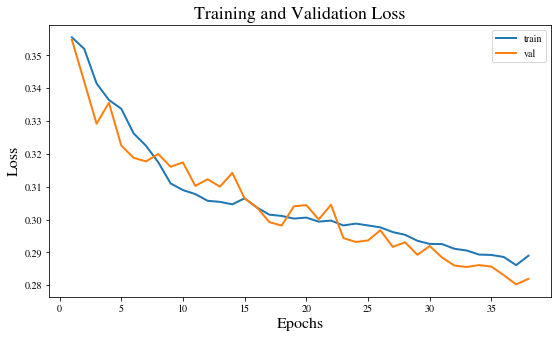

Training epoch 39:  10%|█         | 2/20 [00:00<00:01, 16.99it/s]

sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')


Training epoch 39:  20%|██        | 4/20 [00:00<00:01,  9.75it/s]

sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')
sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')


Training epoch 39:  30%|███       | 6/20 [00:00<00:01,  9.95it/s]

sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')


Training epoch 39:  40%|████      | 8/20 [00:00<00:01,  9.28it/s]

sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')
sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')


Training epoch 39:  55%|█████▌    | 11/20 [00:01<00:00,  9.60it/s]

sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')


Training epoch 39:  65%|██████▌   | 13/20 [00:01<00:00,  9.62it/s]

sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')


Training epoch 39:  75%|███████▌  | 15/20 [00:01<00:00,  8.95it/s]

sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')


Training epoch 39:  85%|████████▌ | 17/20 [00:01<00:00,  9.71it/s]

sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 39: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')
Epoch: 39, train loss: 0.2883
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_39_loss_0.2883.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.20it/s]


pred [7.06860407e-20 9.99999642e-01 9.99999881e-01 ... 2.39070430e-02
 8.34523618e-01 1.38454873e-03]
Epoch: 39, val loss: 0.2884


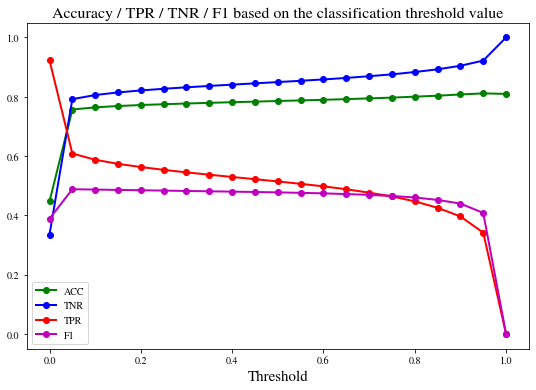

Chosen classification threshold is: 0.025
Edge labels: number of positive: 525768
Predictions: number of positive: 824030


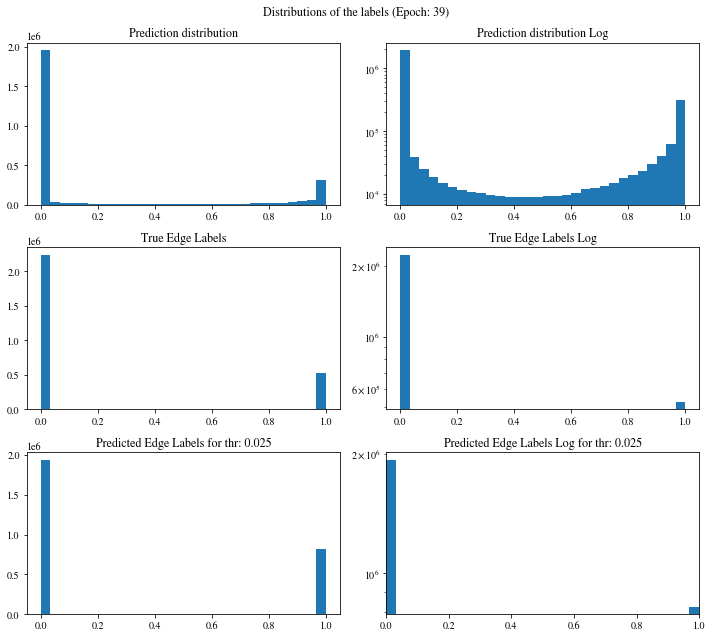

scores [7.06860407e-20 9.99999642e-01 9.99999881e-01 ... 2.39070430e-02
 8.34523618e-01 1.38454873e-03]
Confusion matrix:
[[1740809  494121]
 [ 195859  329909]]

Confusion matrix weighted:
[[0.38945493 0.11054507]
 [0.18625991 0.31374009]]

TN: 1740809 	 FN: 195859 	 TP: 329909 	 FP: 494121
Confusion matrix scaled:
[[0.63056843 0.17898408]
 [0.07094546 0.11950202]]

Accuracy: 0.7501
Precision: 0.4004
Negative predictive value: 0.8989
Recall: Correctly classifying 62.7480 % of positive edges
True negative rate: Correctly classifying 77.8910 % of all negative edges
F1 score: 0.4888
[0.67647193 0.73945572] [0.77890985 0.62748018] [0.72408582 0.67888159]
Balanced accuracy: 0.7032
Precision weighted: [0.67647193 0.73945572]
Recall weighted: [0.77890985 0.62748018]
F1 score weighted: [0.72408582 0.67888159]
positive_likelihood_ratio: 2.838119168696435, negative_likelihood_ratio: 0.4782579353878277


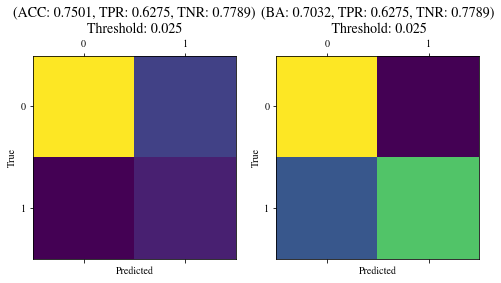

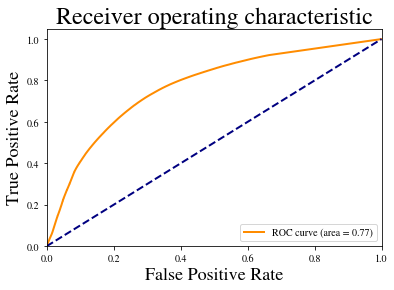

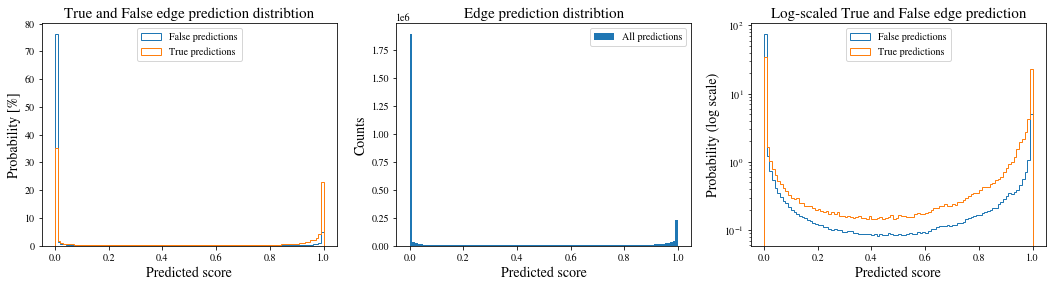

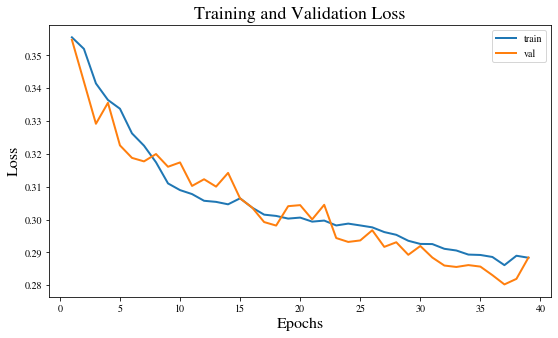

Training epoch 40:  10%|█         | 2/20 [00:00<00:01, 15.04it/s]

sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')


Training epoch 40:  20%|██        | 4/20 [00:00<00:01,  9.06it/s]

sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')


Training epoch 40:  30%|███       | 6/20 [00:00<00:01,  9.43it/s]

sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')
sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')


Training epoch 40:  40%|████      | 8/20 [00:00<00:01,  9.77it/s]

sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Training epoch 40:  50%|█████     | 10/20 [00:01<00:01,  9.52it/s]

sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')


Training epoch 40:  65%|██████▌   | 13/20 [00:01<00:00,  8.18it/s]

sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 40:  75%|███████▌  | 15/20 [00:01<00:00,  8.38it/s]

sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')
sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')


Training epoch 40:  90%|█████████ | 18/20 [00:01<00:00,  9.36it/s]

sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')


Training epoch 40: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
Epoch: 40, train loss: 0.2871
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_40_loss_0.2871.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.14it/s]


pred [0.99632937 0.99499065 0.99687612 ... 0.86897224 0.01943228 0.88157022]
Epoch: 40, val loss: 0.2890


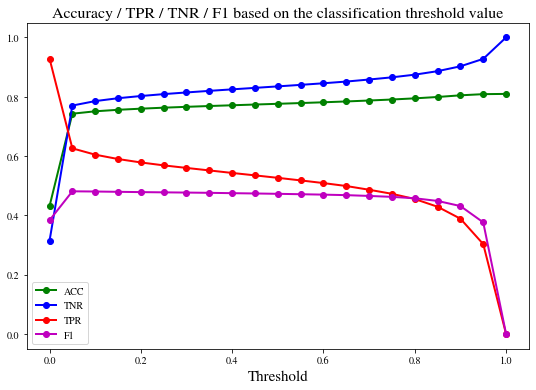

Chosen classification threshold is: 0.025
Edge labels: number of positive: 525768
Predictions: number of positive: 882783


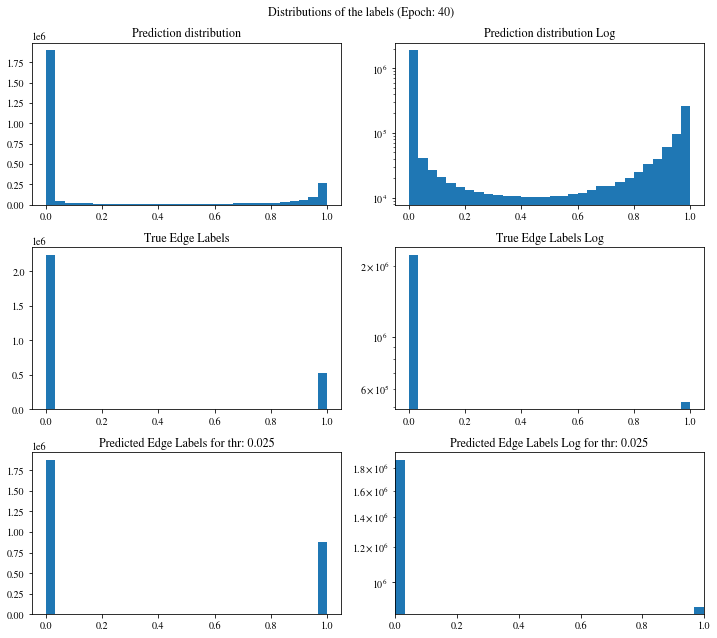

scores [0.99632937 0.99499065 0.99687612 ... 0.86897224 0.01943228 0.88157022]
Confusion matrix:
[[1691085  543845]
 [ 186830  338938]]

Confusion matrix weighted:
[[0.37833064 0.12166936]
 [0.17767342 0.32232658]]

TN: 1691085 	 FN: 186830 	 TP: 338938 	 FP: 543845
Confusion matrix scaled:
[[0.61255704 0.19699547]
 [0.06767491 0.12277257]]

Accuracy: 0.7353
Precision: 0.3839
Negative predictive value: 0.9005
Recall: Correctly classifying 64.4653 % of positive edges
True negative rate: Correctly classifying 75.6661 % of all negative edges
F1 score: 0.4813
[0.68044582 0.7259674 ] [0.75666128 0.64465315] [0.71653255 0.68289823]
Balanced accuracy: 0.7007
Precision weighted: [0.68044582 0.7259674 ]
Recall weighted: [0.75666128 0.64465315]
F1 score weighted: [0.71653255 0.68289823]
positive_likelihood_ratio: 2.649200922528444, negative_likelihood_ratio: 0.4696247227593636


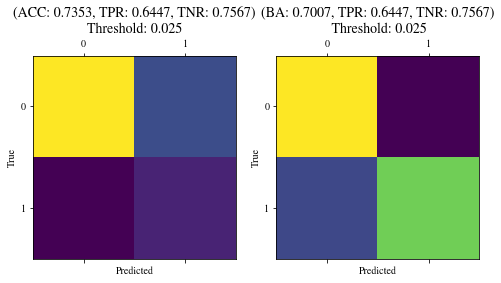

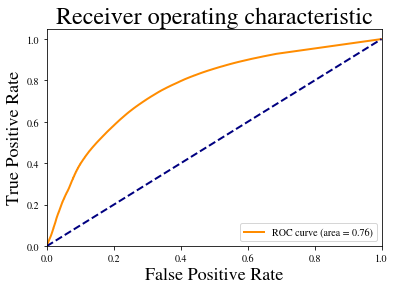

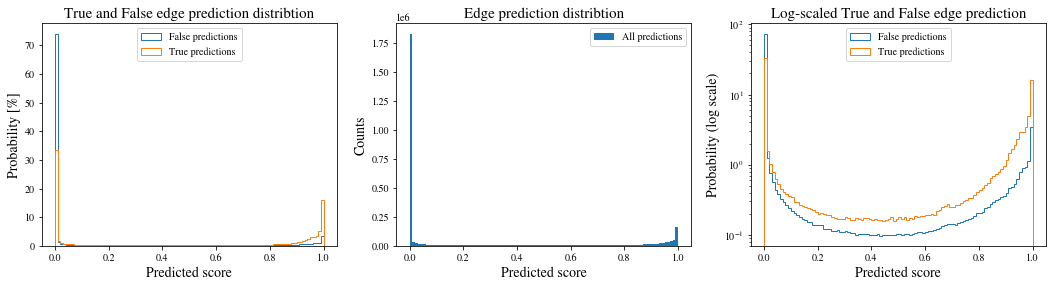

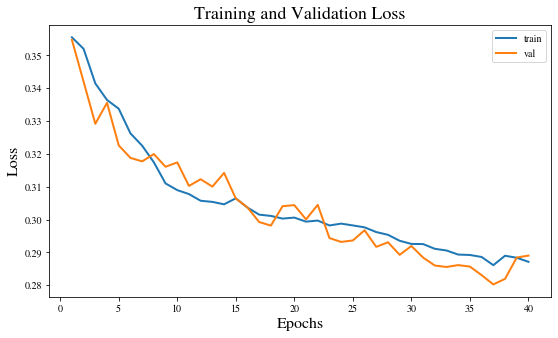

Training epoch 41:  10%|█         | 2/20 [00:00<00:01, 15.53it/s]

sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')


Training epoch 41:  20%|██        | 4/20 [00:00<00:01, 12.78it/s]

sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')


Training epoch 41:  30%|███       | 6/20 [00:00<00:01,  9.59it/s]

sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')


Training epoch 41:  40%|████      | 8/20 [00:00<00:01,  9.46it/s]

sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')


Training epoch 41:  60%|██████    | 12/20 [00:01<00:00, 10.12it/s]

sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')


Training epoch 41:  70%|███████   | 14/20 [00:01<00:00,  9.48it/s]

sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 41:  80%|████████  | 16/20 [00:01<00:00,  8.82it/s]

sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 41:  90%|█████████ | 18/20 [00:01<00:00,  8.30it/s]

sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Training epoch 41: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]

sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
Epoch: 41, train loss: 0.2861
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_41_loss_0.2861.pt


Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.20it/s]


pred [9.98955846e-01 9.98467743e-01 9.99106348e-01 ... 8.18720878e-08
 2.58159707e-04 5.00516080e-07]
Epoch: 41, val loss: 0.2841


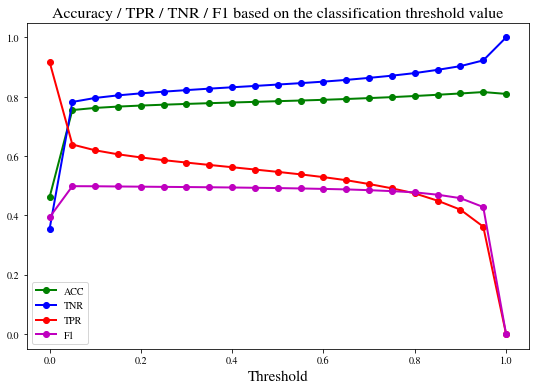

Chosen classification threshold is: 0.025
Edge labels: number of positive: 525768
Predictions: number of positive: 858475


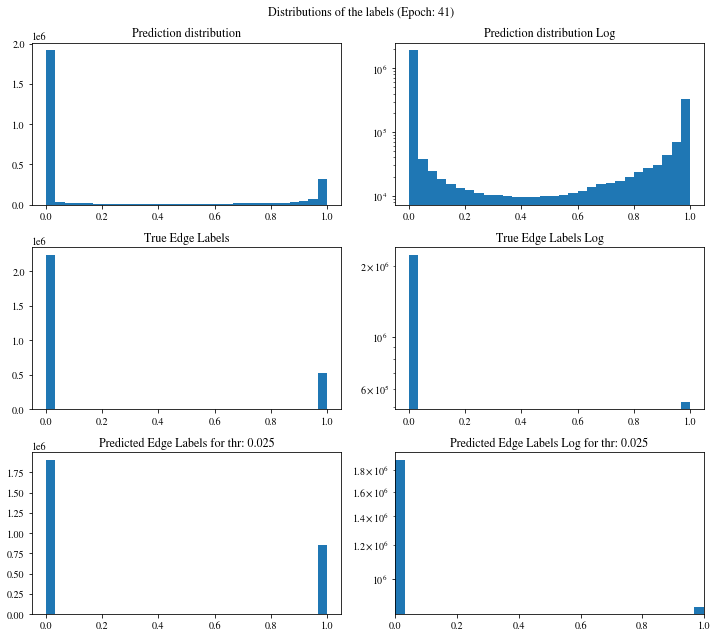

scores [9.98955846e-01 9.98467743e-01 9.99106348e-01 ... 8.18720878e-08
 2.58159707e-04 5.00516080e-07]
Confusion matrix:
[[1721169  513761]
 [ 181054  344714]]

Confusion matrix weighted:
[[0.38506105 0.11493895]
 [0.17218051 0.32781949]]

TN: 1721169 	 FN: 181054 	 TP: 344714 	 FP: 513761
Confusion matrix scaled:
[[0.62345429 0.18609823]
 [0.06558269 0.1248648 ]]

Accuracy: 0.7483
Precision: 0.4015
Negative predictive value: 0.9048
Recall: Correctly classifying 65.5639 % of positive edges
True negative rate: Correctly classifying 77.0122 % of all negative edges
F1 score: 0.4981
[0.69101281 0.74040259] [0.77012211 0.65563899] [0.72842587 0.69544749]
Balanced accuracy: 0.7129
Precision weighted: [0.69101281 0.74040259]
Recall weighted: [0.77012211 0.65563899]
F1 score weighted: [0.72842587 0.69544749]
positive_likelihood_ratio: 2.852118486649335, negative_likelihood_ratio: 0.44715118281850946


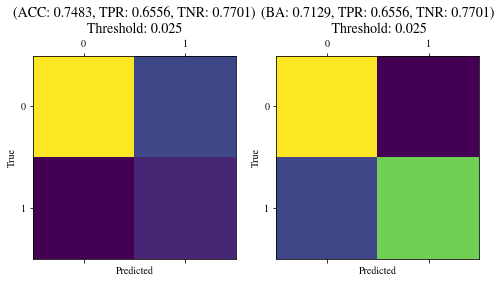

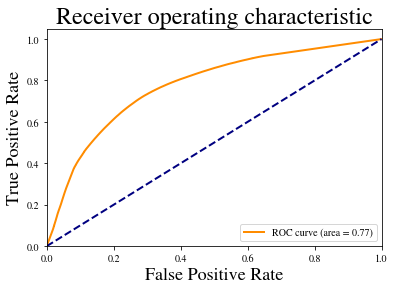

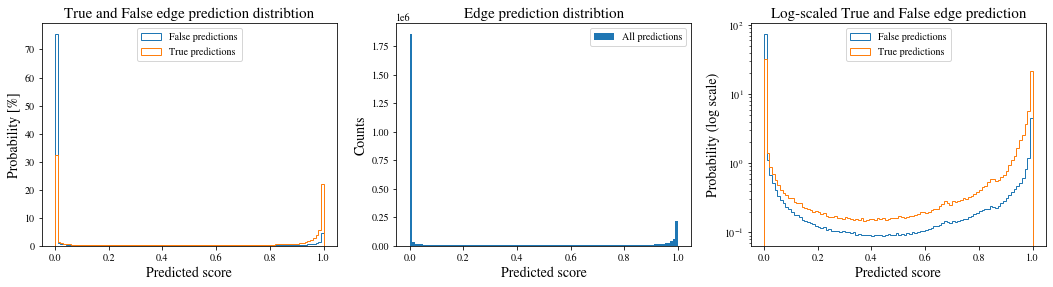

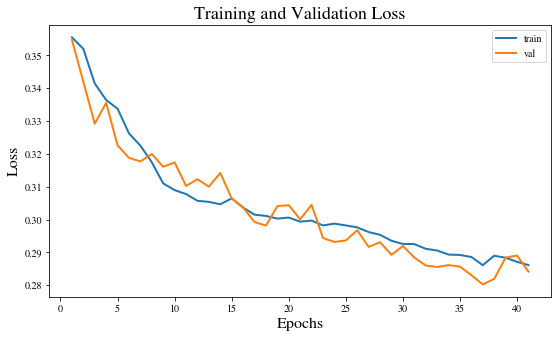

Training epoch 42:  10%|█         | 2/20 [00:00<00:01, 13.04it/s]

sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 42:  20%|██        | 4/20 [00:00<00:01, 11.06it/s]

sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')


Training epoch 42:  30%|███       | 6/20 [00:00<00:01, 11.21it/s]

sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')
sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')


Training epoch 42:  40%|████      | 8/20 [00:00<00:01,  9.80it/s]

sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')


Training epoch 42:  60%|██████    | 12/20 [00:01<00:00,  9.18it/s]

sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')
sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')


Training epoch 42:  75%|███████▌  | 15/20 [00:01<00:00,  9.46it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')


Training epoch 42:  85%|████████▌ | 17/20 [00:01<00:00,  9.19it/s]

sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 42:  95%|█████████▌| 19/20 [00:02<00:00,  8.54it/s]

sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')


Training epoch 42: 100%|██████████| 20/20 [00:02<00:00,  9.33it/s]


sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
Epoch: 42, train loss: 0.2849
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_42_loss_0.2849.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]


pred [0.         0.         0.         ... 0.03246538 0.10387098 0.45207468]
Epoch: 42, val loss: 0.2803


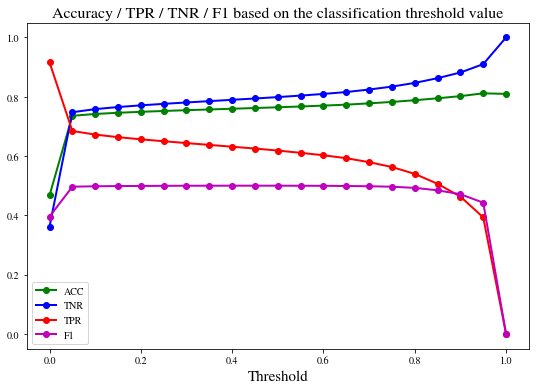

Chosen classification threshold is: 0.025
Edge labels: number of positive: 525768
Predictions: number of positive: 949108


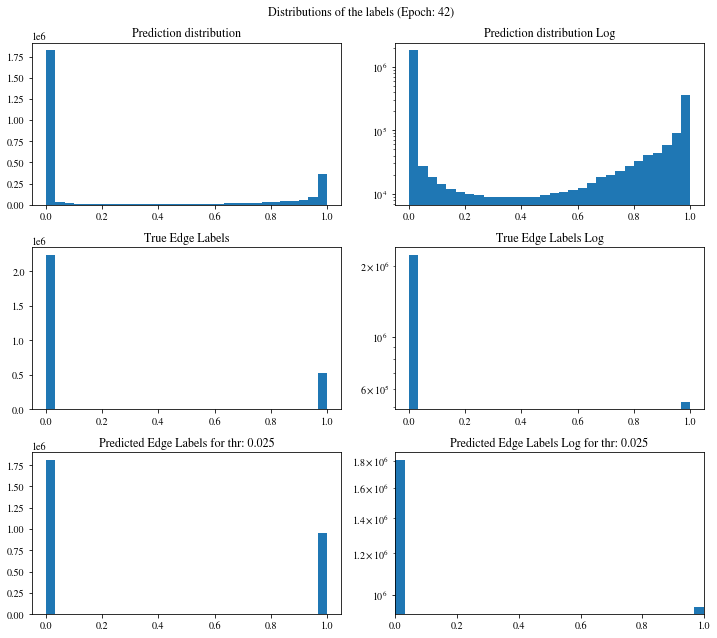

scores [0.         0.         0.         ... 0.03246538 0.10387098 0.45207468]
Confusion matrix:
[[1650911  584019]
 [ 160679  365089]]

Confusion matrix weighted:
[[0.36934289 0.13065711]
 [0.15280409 0.34719591]]

TN: 1650911 	 FN: 160679 	 TP: 365089 	 FP: 584019
Confusion matrix scaled:
[[0.59800492 0.21154759]
 [0.05820231 0.13224518]]

Accuracy: 0.7303
Precision: 0.3847
Negative predictive value: 0.9113
Recall: Correctly classifying 69.4392 % of positive edges
True negative rate: Correctly classifying 73.8686 % of all negative edges
F1 score: 0.4951
[0.70735426 0.72657469] [0.73868578 0.69439182] [0.72268059 0.71011881]
Balanced accuracy: 0.7165
Precision weighted: [0.70735426 0.72657469]
Recall weighted: [0.73868578 0.69439182]
F1 score weighted: [0.72268059 0.71011881]
positive_likelihood_ratio: 2.6573058701829426, negative_likelihood_ratio: 0.4137187789054819


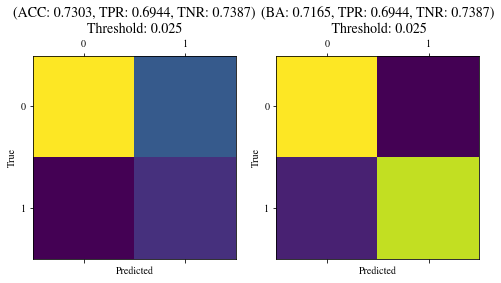

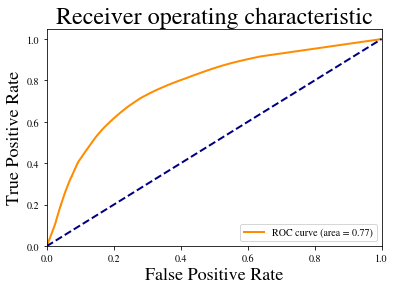

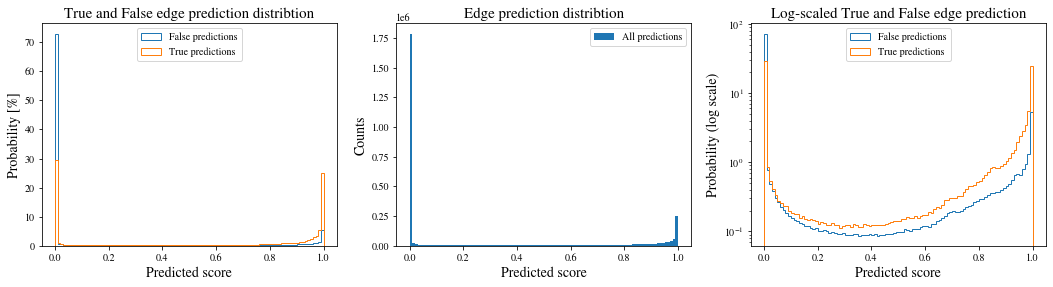

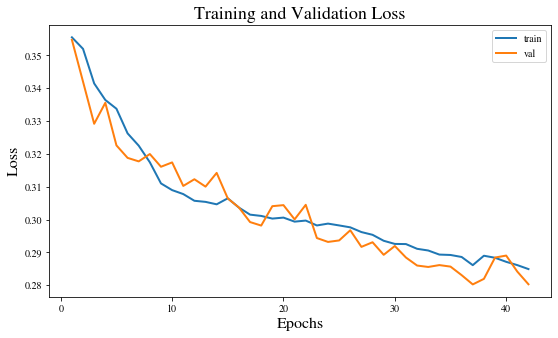

Training epoch 43:  10%|█         | 2/20 [00:00<00:01, 15.19it/s]

sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')


Training epoch 43:  20%|██        | 4/20 [00:00<00:01, 10.71it/s]

sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')


Training epoch 43:  30%|███       | 6/20 [00:00<00:01,  8.82it/s]

sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')
sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')


Training epoch 43:  35%|███▌      | 7/20 [00:00<00:01,  8.38it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Training epoch 43:  55%|█████▌    | 11/20 [00:01<00:00,  9.32it/s]

sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')


Training epoch 43:  65%|██████▌   | 13/20 [00:01<00:00, 10.30it/s]

sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')


Training epoch 43:  75%|███████▌  | 15/20 [00:01<00:00,  9.66it/s]

sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 43:  95%|█████████▌| 19/20 [00:01<00:00,  9.98it/s]

sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')


Training epoch 43: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')
Epoch: 43, train loss: 0.2833
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_43_loss_0.2833.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]


pred [3.35969437e-36 0.00000000e+00 0.00000000e+00 ... 5.14451027e-01
 7.23243475e-01 8.84070575e-01]
Epoch: 43, val loss: 0.2756


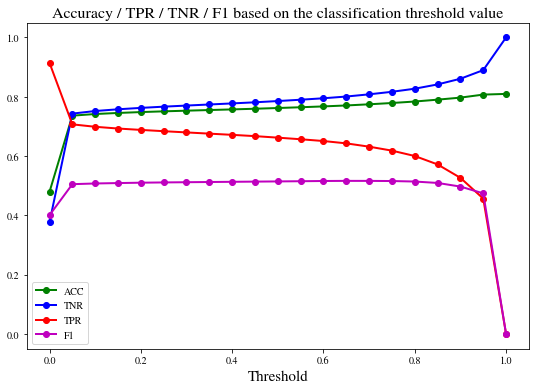

Chosen classification threshold is: 0.025
Edge labels: number of positive: 525768
Predictions: number of positive: 966581


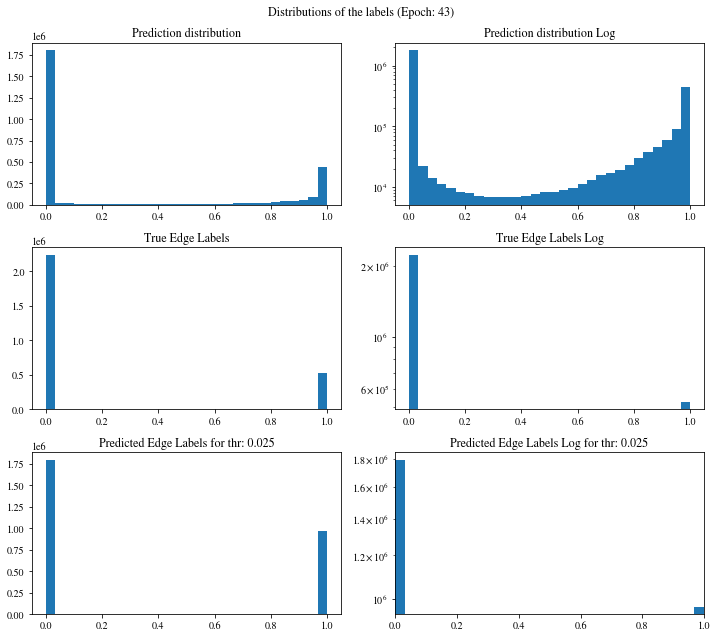

scores [3.35969437e-36 0.00000000e+00 0.00000000e+00 ... 5.14451027e-01
 7.23243475e-01 8.84070575e-01]
Confusion matrix:
[[1643765  591165]
 [ 150352  375416]]

Confusion matrix weighted:
[[0.36774418 0.13225582]
 [0.14298322 0.35701678]]

TN: 1643765 	 FN: 150352 	 TP: 375416 	 FP: 591165
Confusion matrix scaled:
[[0.59541645 0.21413606]
 [0.05446159 0.1359859 ]]

Accuracy: 0.7314
Precision: 0.3884
Negative predictive value: 0.9162
Recall: Correctly classifying 71.4034 % of positive edges
True negative rate: Correctly classifying 73.5488 % of all negative edges
F1 score: 0.5031
[0.72004005 0.72968889] [0.73548836 0.71403357] [0.72768222 0.72177635]
Balanced accuracy: 0.7248
Precision weighted: [0.72004005 0.72968889]
Recall weighted: [0.73548836 0.71403357]
F1 score weighted: [0.72768222 0.72177635]
positive_likelihood_ratio: 2.6994409986442234, negative_likelihood_ratio: 0.38881163793880974


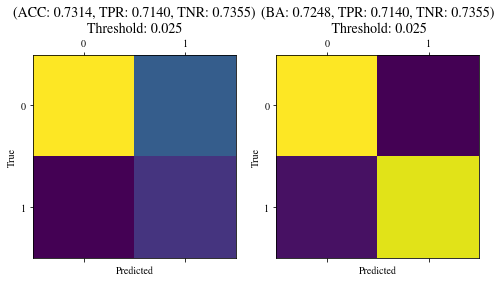

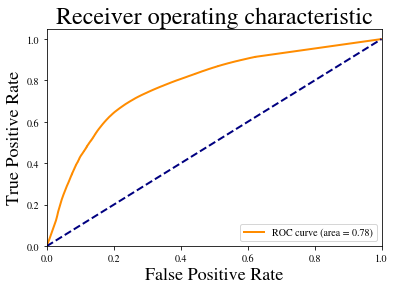

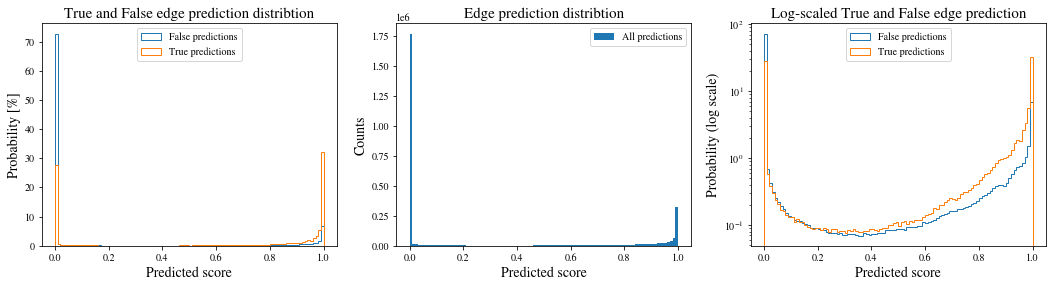

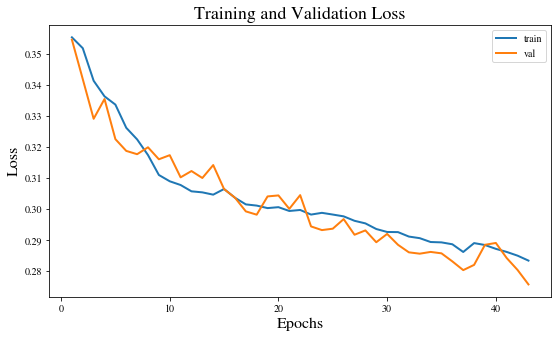

Training epoch 44:  10%|█         | 2/20 [00:00<00:01, 10.39it/s]

sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')


Training epoch 44:  20%|██        | 4/20 [00:00<00:01, 10.02it/s]

sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')
sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')


Training epoch 44:  35%|███▌      | 7/20 [00:00<00:01,  9.85it/s]

sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')


Training epoch 44:  45%|████▌     | 9/20 [00:00<00:01, 10.07it/s]

sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')
sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')


Training epoch 44:  60%|██████    | 12/20 [00:01<00:00,  9.35it/s]

sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')
sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')


Training epoch 44:  70%|███████   | 14/20 [00:01<00:00,  8.28it/s]

sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 44:  85%|████████▌ | 17/20 [00:01<00:00,  9.15it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')


Training epoch 44: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]

sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Epoch: 44, train loss: 0.2831
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_44_loss_0.2831.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.20it/s]


pred [1.06798449e-37 1.00000000e+00 1.00000000e+00 ... 8.92021662e-15
 3.75287357e-10 1.14029884e-15]
Epoch: 44, val loss: 0.2784


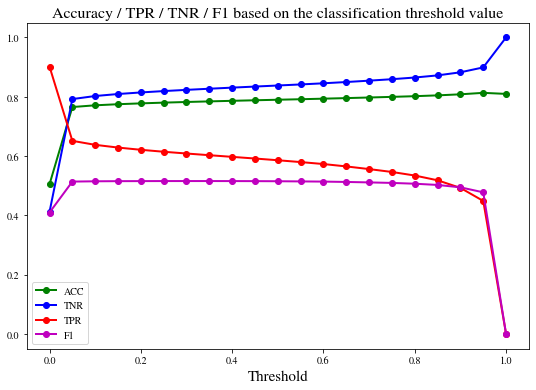

Chosen classification threshold is: 0.025
Edge labels: number of positive: 525768
Predictions: number of positive: 833299


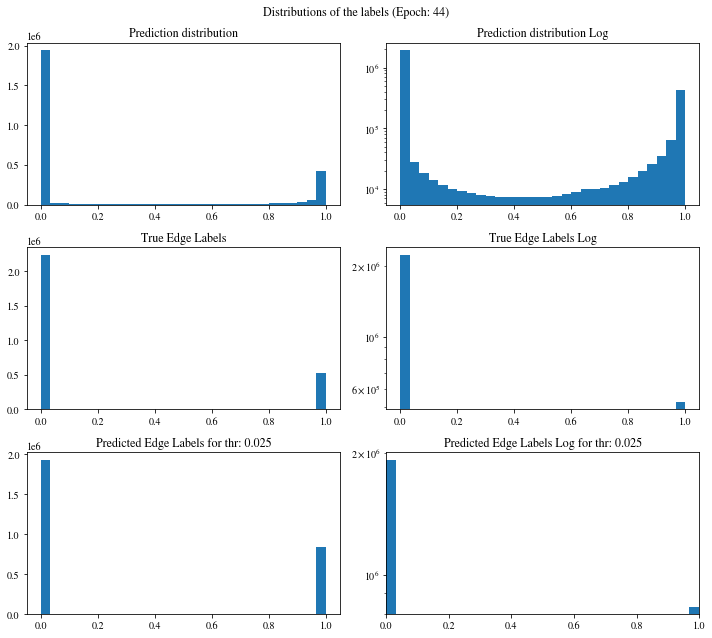

scores [1.06798449e-37 1.00000000e+00 1.00000000e+00 ... 8.92021662e-15
 3.75287357e-10 1.14029884e-15]
Confusion matrix:
[[1749941  484989]
 [ 177458  348310]]

Confusion matrix weighted:
[[0.39149794 0.10850206]
 [0.16876075 0.33123925]]

TN: 1749941 	 FN: 177458 	 TP: 348310 	 FP: 484989
Confusion matrix scaled:
[[0.63387629 0.17567622]
 [0.06428012 0.12616737]]

Accuracy: 0.7600
Precision: 0.4180
Negative predictive value: 0.9079
Recall: Correctly classifying 66.2479 % of positive edges
True negative rate: Correctly classifying 78.2996 % of all negative edges
F1 score: 0.5126
[0.69878067 0.75325935] [0.78299589 0.66247851] [0.73849514 0.70495838]
Balanced accuracy: 0.7227
Precision weighted: [0.69878067 0.75325935]
Recall weighted: [0.78299589 0.66247851]
F1 score weighted: [0.73849514 0.70495838]
positive_likelihood_ratio: 3.052838499551896, negative_likelihood_ratio: 0.431064195273341


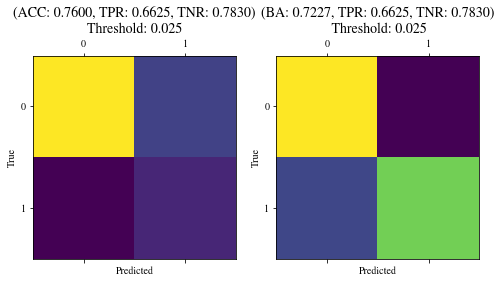

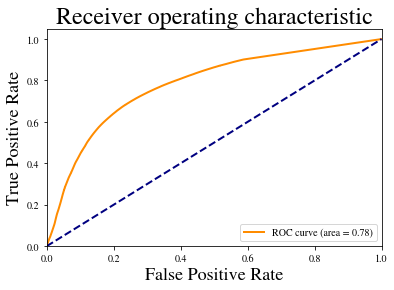

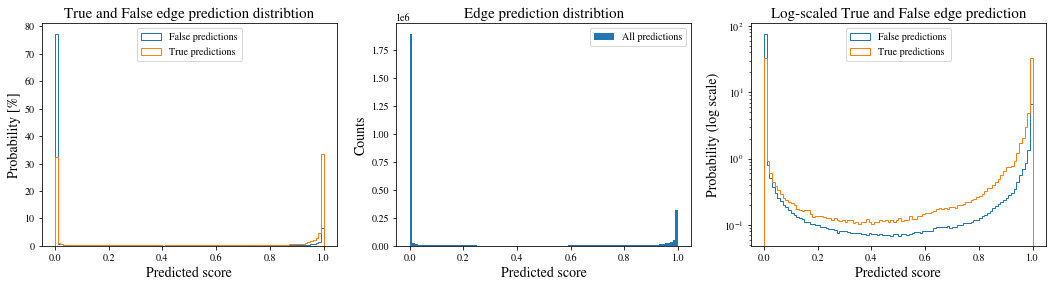

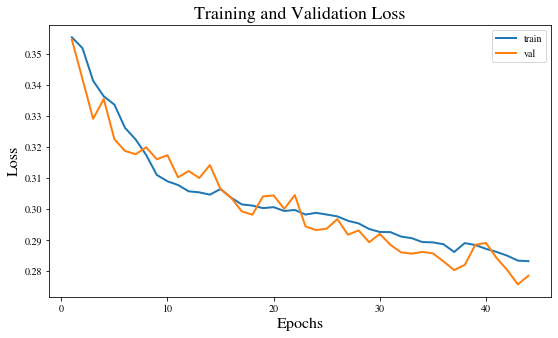

Training epoch 45:  10%|█         | 2/20 [00:00<00:01,  9.55it/s]

sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')


Training epoch 45:  20%|██        | 4/20 [00:00<00:01,  9.65it/s]

sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')


Training epoch 45:  30%|███       | 6/20 [00:00<00:01,  9.03it/s]

sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Training epoch 45:  45%|████▌     | 9/20 [00:00<00:01,  9.62it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')


Training epoch 45:  55%|█████▌    | 11/20 [00:01<00:01,  8.93it/s]

sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')


Training epoch 45:  65%|██████▌   | 13/20 [00:01<00:00,  9.42it/s]

sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')
sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')


Training epoch 45:  75%|███████▌  | 15/20 [00:01<00:00,  9.07it/s]

sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')
sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')


Training epoch 45:  85%|████████▌ | 17/20 [00:01<00:00,  9.71it/s]

sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')


Training epoch 45: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]

sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
Epoch: 45, train loss: 0.2817
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_45_loss_0.2817.pt


Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.24it/s]


pred [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.25029898e-08
 2.27298571e-08 1.71014695e-11]
Epoch: 45, val loss: 0.2772


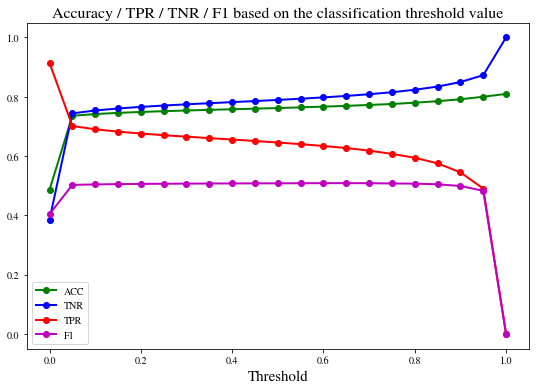

Chosen classification threshold is: 0.025
Edge labels: number of positive: 525768
Predictions: number of positive: 965136


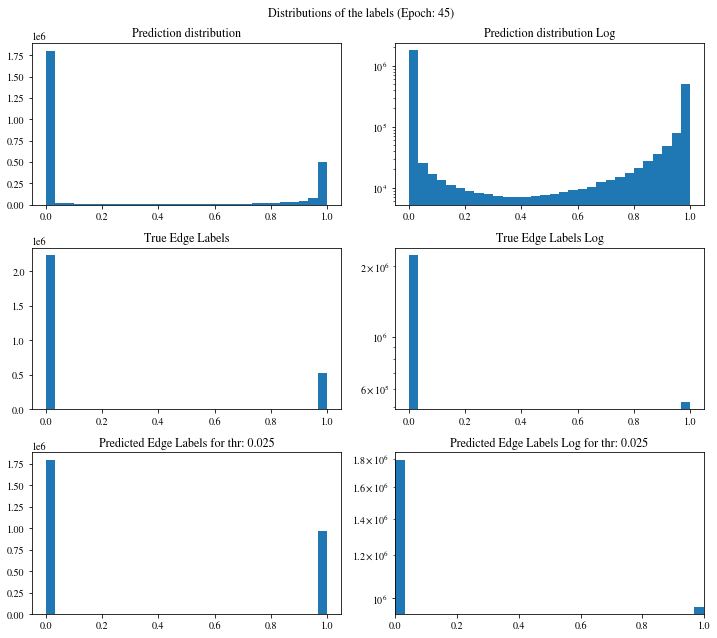

scores [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.25029898e-08
 2.27298571e-08 1.71014695e-11]
Confusion matrix:
[[1643364  591566]
 [ 152198  373570]]

Confusion matrix weighted:
[[0.36765447 0.13234553]
 [0.14473874 0.35526126]]

TN: 1643364 	 FN: 152198 	 TP: 373570 	 FP: 591566
Confusion matrix scaled:
[[0.5952712  0.21428132]
 [0.05513026 0.13531723]]

Accuracy: 0.7306
Precision: 0.3871
Negative predictive value: 0.9152
Recall: Correctly classifying 71.0523 % of positive edges
True negative rate: Correctly classifying 73.5309 % of all negative edges
F1 score: 0.5011
[0.71752408 0.72858144] [0.73530894 0.71052251] [0.72630765 0.71943867]
Balanced accuracy: 0.7229
Precision weighted: [0.71752408 0.72858144]
Recall weighted: [0.73530894 0.71052251]
F1 score weighted: [0.72630765 0.71943867]
positive_likelihood_ratio: 2.6843464251916465, negative_likelihood_ratio: 0.3936814501443859


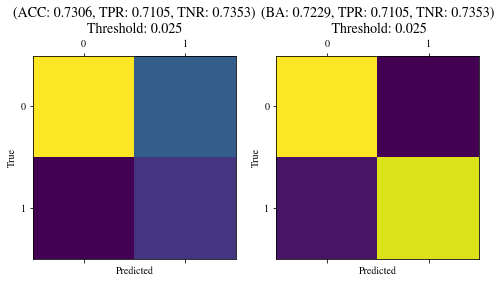

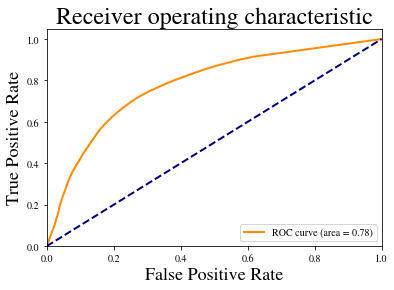

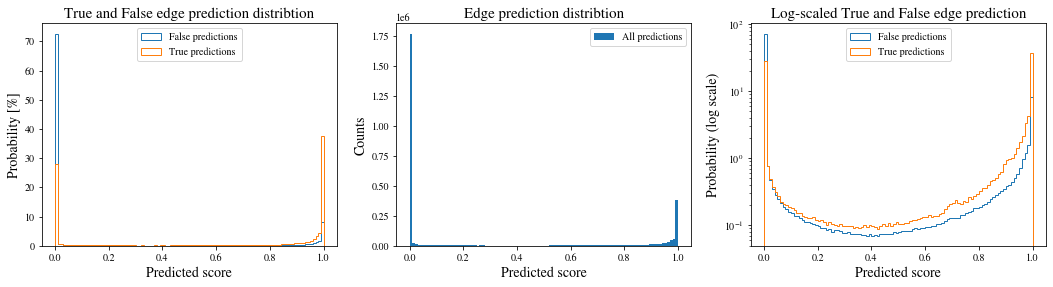

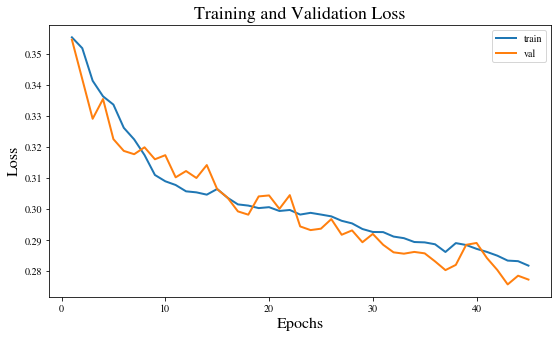

Training epoch 46:  10%|█         | 2/20 [00:00<00:01, 11.33it/s]

sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')


Training epoch 46:  20%|██        | 4/20 [00:00<00:01, 12.14it/s]

sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')


Training epoch 46:  30%|███       | 6/20 [00:00<00:01, 10.05it/s]

sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')


Training epoch 46:  40%|████      | 8/20 [00:00<00:01,  9.93it/s]

sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Training epoch 46:  55%|█████▌    | 11/20 [00:01<00:00,  9.08it/s]

sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')
sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')


Training epoch 46:  65%|██████▌   | 13/20 [00:01<00:00,  9.93it/s]

sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 46:  80%|████████  | 16/20 [00:01<00:00,  9.46it/s]

sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')
sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')


Training epoch 46:  90%|█████████ | 18/20 [00:01<00:00,  9.66it/s]

sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 46: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]

sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')


Epoch: 46, train loss: 0.2816
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_46_loss_0.2816.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.44it/s]


pred [0.         0.         0.         ... 0.88149399 0.95036632 0.97272134]
Epoch: 46, val loss: 0.2734


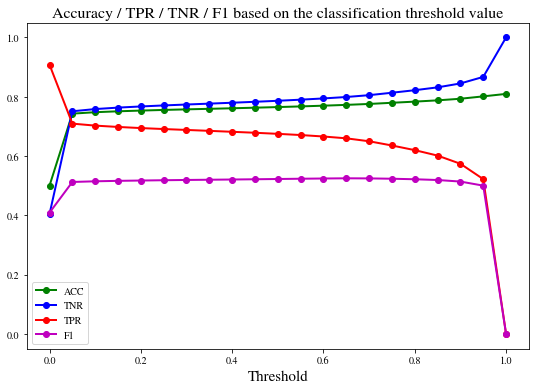

Chosen classification threshold is: 0.025
Edge labels: number of positive: 525768
Predictions: number of positive: 947565


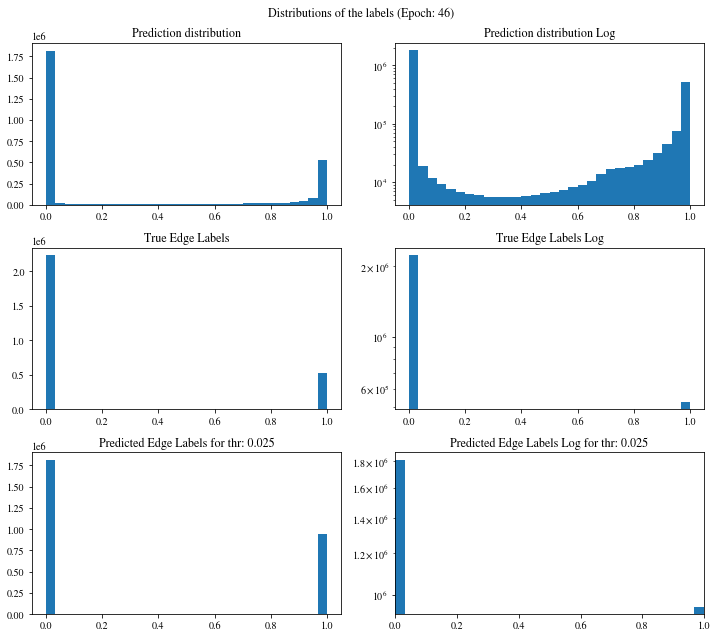

scores [0.         0.         0.         ... 0.88149399 0.95036632 0.97272134]
Confusion matrix:
[[1663270  571660]
 [ 149863  375905]]

Confusion matrix weighted:
[[0.37210785 0.12789215]
 [0.14251818 0.35748182]]

TN: 1663270 	 FN: 149863 	 TP: 375905 	 FP: 571660
Confusion matrix scaled:
[[0.60248169 0.20707082]
 [0.05428446 0.13616303]]

Accuracy: 0.7386
Precision: 0.3967
Negative predictive value: 0.9173
Recall: Correctly classifying 71.4964 % of positive edges
True negative rate: Correctly classifying 74.4216 % of all negative edges
F1 score: 0.5103
[0.72306457 0.73650802] [0.7442157  0.71496363] [0.73348769 0.72557593]
Balanced accuracy: 0.7296
Precision weighted: [0.72306457 0.73650802]
Recall weighted: [0.7442157  0.71496363]
F1 score weighted: [0.73348769 0.72557593]
positive_likelihood_ratio: 2.7951818823633046, negative_likelihood_ratio: 0.38300235387411147


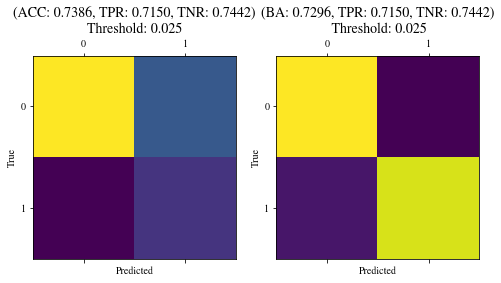

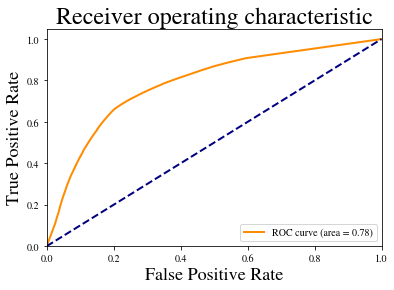

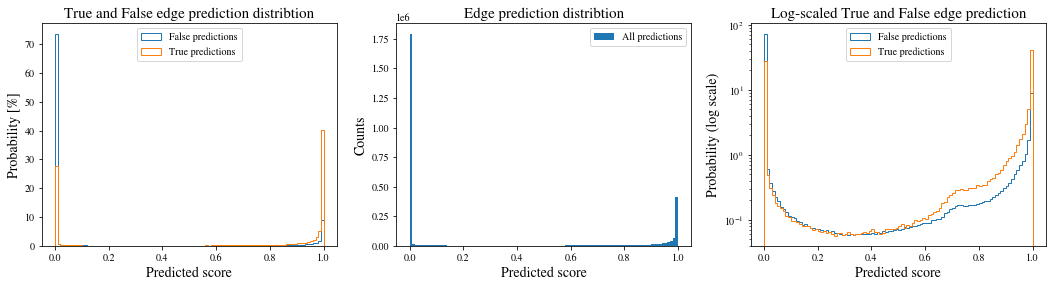

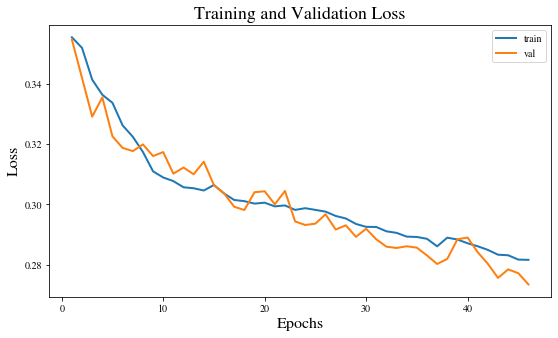

Training epoch 47:  10%|█         | 2/20 [00:00<00:01, 11.82it/s]

sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')
sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')


Training epoch 47:  20%|██        | 4/20 [00:00<00:01,  8.65it/s]

sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')


Training epoch 47:  30%|███       | 6/20 [00:00<00:01,  9.77it/s]

sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')


Training epoch 47:  40%|████      | 8/20 [00:00<00:01, 10.24it/s]

sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 47:  55%|█████▌    | 11/20 [00:01<00:01,  8.63it/s]

sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')


Training epoch 47:  65%|██████▌   | 13/20 [00:01<00:00,  9.95it/s]

sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')


Training epoch 47:  80%|████████  | 16/20 [00:01<00:00,  9.77it/s]

sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')


Training epoch 47:  90%|█████████ | 18/20 [00:01<00:00, 10.28it/s]

sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')


Training epoch 47: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
Epoch: 47, train loss: 0.2811
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_47_loss_0.2811.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.59it/s]


pred [0.         0.         0.         ... 0.01947801 0.55862421 0.00062286]
Epoch: 47, val loss: 0.2763


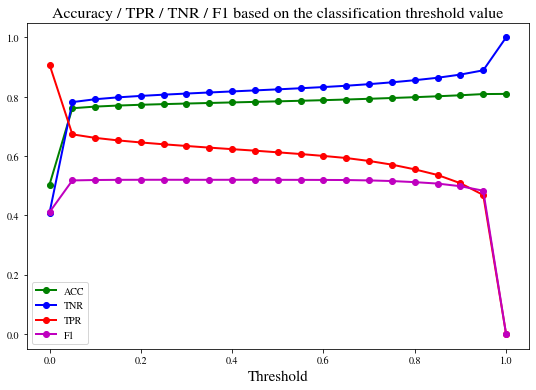

Chosen classification threshold is: 0.025
Edge labels: number of positive: 525768
Predictions: number of positive: 866016


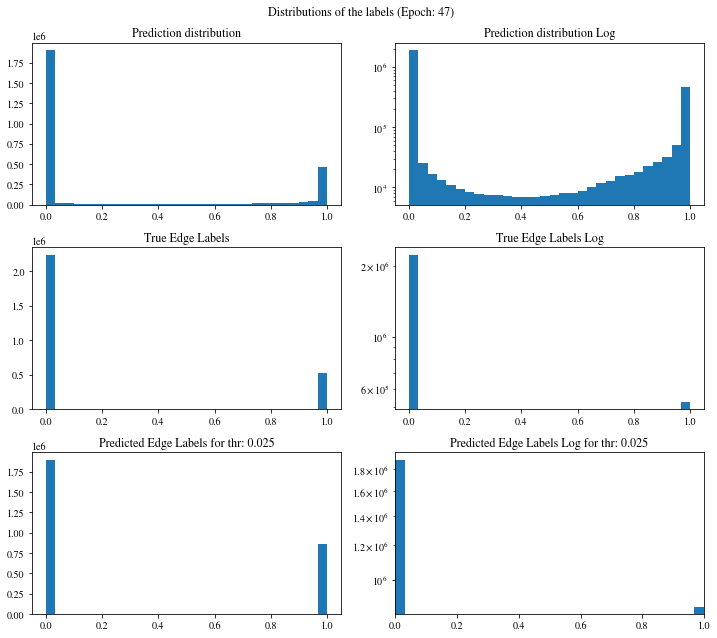

scores [0.         0.         0.         ... 0.01947801 0.55862421 0.00062286]
Confusion matrix:
[[1728195  506735]
 [ 166487  359281]]

Confusion matrix weighted:
[[0.38663291 0.11336709]
 [0.15832744 0.34167256]]

TN: 1728195 	 FN: 166487 	 TP: 359281 	 FP: 506735
Confusion matrix scaled:
[[0.62599929 0.18355322]
 [0.06030613 0.13014136]]

Accuracy: 0.7561
Precision: 0.4149
Negative predictive value: 0.9121
Recall: Correctly classifying 68.3345 % of positive edges
True negative rate: Correctly classifying 77.3266 % of all negative edges
F1 score: 0.5163
[0.70946981 0.75086328] [0.77326583 0.68334513] [0.73999538 0.71551493]
Balanced accuracy: 0.7283
Precision weighted: [0.70946981 0.75086328]
Recall weighted: [0.77326583 0.68334513]
F1 score weighted: [0.73999538 0.71551493]
positive_likelihood_ratio: 3.0138603443066936, negative_likelihood_ratio: 0.409503255377864


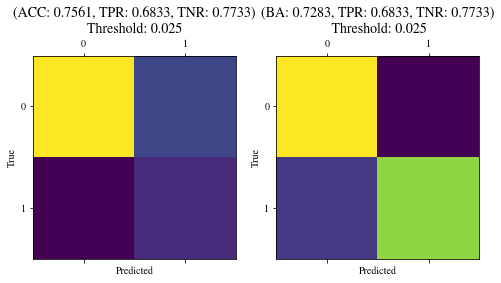

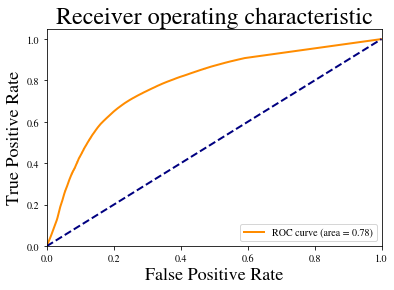

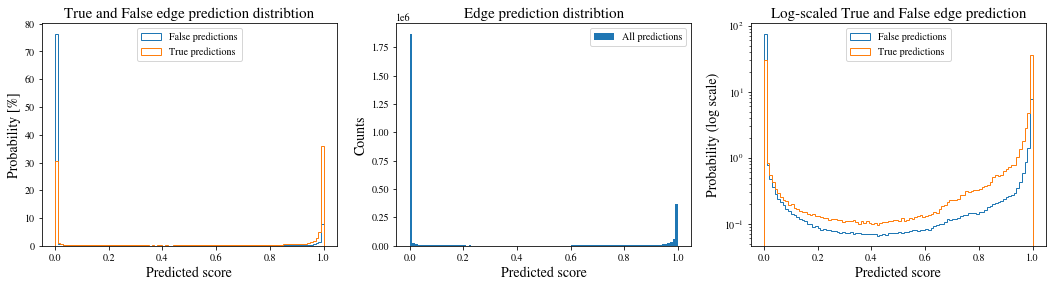

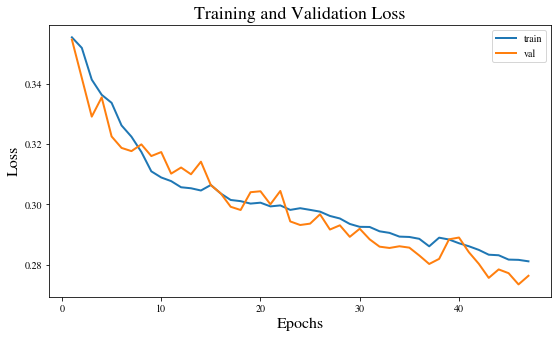

Training epoch 48:  10%|█         | 2/20 [00:00<00:01, 13.45it/s]

sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')
sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')


Training epoch 48:  20%|██        | 4/20 [00:00<00:01, 10.70it/s]

sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 48:  40%|████      | 8/20 [00:00<00:01, 10.15it/s]

sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')
sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')


Training epoch 48:  50%|█████     | 10/20 [00:01<00:01,  9.36it/s]

sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')


Training epoch 48:  60%|██████    | 12/20 [00:01<00:00,  8.58it/s]

sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')


Training epoch 48:  70%|███████   | 14/20 [00:01<00:00,  9.21it/s]

sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')
sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')


Training epoch 48:  85%|████████▌ | 17/20 [00:01<00:00,  9.65it/s]

sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Training epoch 48:  90%|█████████ | 18/20 [00:01<00:00,  9.07it/s]

sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')


Training epoch 48: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


Epoch: 48, train loss: 0.2803
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_48_loss_0.2803.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.45it/s]


pred [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.40651481e-21
 7.87434801e-02 3.43365878e-01]
Epoch: 48, val loss: 0.2867


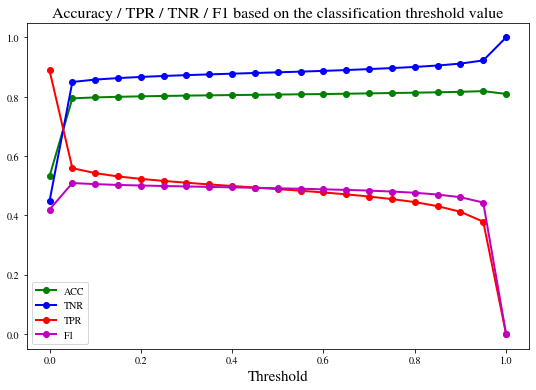

Chosen classification threshold is: 0.025
Edge labels: number of positive: 525768
Predictions: number of positive: 655181


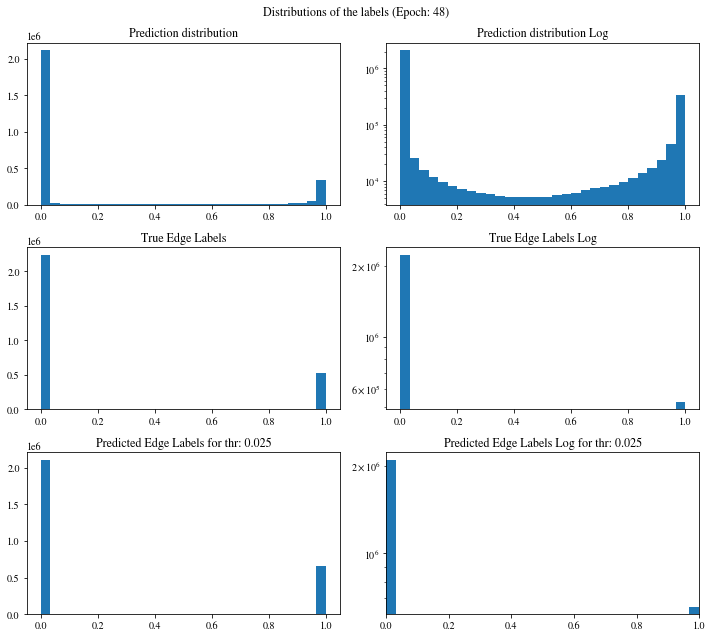

scores [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.40651481e-21
 7.87434801e-02 3.43365878e-01]
Confusion matrix:
[[1881816  353114]
 [ 223701  302067]]

Confusion matrix weighted:
[[0.42100111 0.07899889]
 [0.21273737 0.28726263]]

TN: 1881816 	 FN: 223701 	 TP: 302067 	 FP: 353114
Confusion matrix scaled:
[[0.681645   0.12790751]
 [0.08103059 0.10941689]]

Accuracy: 0.7911
Precision: 0.4610
Negative predictive value: 0.8938
Recall: Correctly classifying 57.4525 % of positive edges
True negative rate: Correctly classifying 84.2002 % of all negative edges
F1 score: 0.5116
[0.66431363 0.78431015] [0.84200221 0.57452527] [0.74267764 0.6632238 ]
Balanced accuracy: 0.7083
Precision weighted: [0.66431363 0.78431015]
Recall weighted: [0.84200221 0.57452527]
F1 score weighted: [0.74267764 0.6632238 ]
positive_likelihood_ratio: 3.636286730377762, negative_likelihood_ratio: 0.5053130845361007


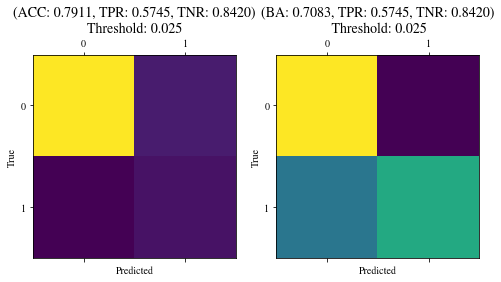

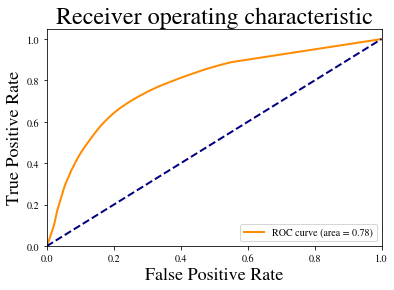

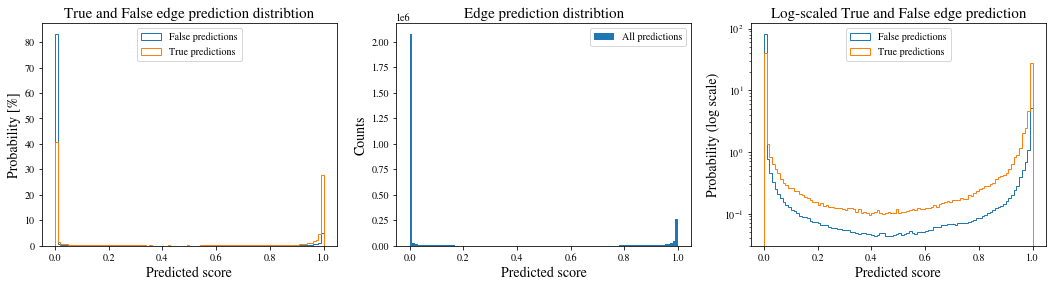

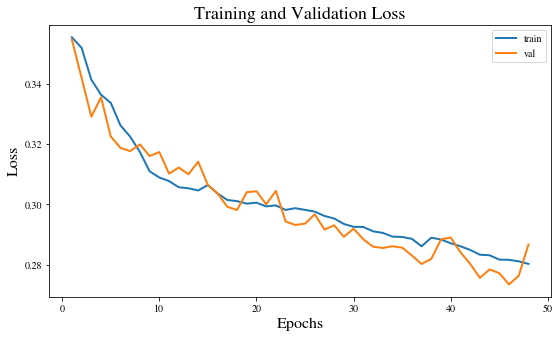

Training epoch 49:  10%|█         | 2/20 [00:00<00:01, 15.97it/s]

sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')
sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')


Training epoch 49:  20%|██        | 4/20 [00:00<00:01,  8.26it/s]

sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')
sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')


Training epoch 49:  30%|███       | 6/20 [00:00<00:01,  8.75it/s]

sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 49:  45%|████▌     | 9/20 [00:00<00:01,  9.81it/s]

sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')


Training epoch 49:  55%|█████▌    | 11/20 [00:01<00:00,  9.92it/s]

sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')


Training epoch 49:  65%|██████▌   | 13/20 [00:01<00:00,  9.99it/s]

sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')
sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')


Training epoch 49:  85%|████████▌ | 17/20 [00:01<00:00, 10.05it/s]

sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')
sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')


Training epoch 49:  95%|█████████▌| 19/20 [00:01<00:00,  9.14it/s]

sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')


Training epoch 49: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')
Epoch: 49, train loss: 0.2806
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_49_loss_0.2806.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.43it/s]


pred [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.94626624e-06
 6.09545836e-09 2.17520355e-04]
Epoch: 49, val loss: 0.2812


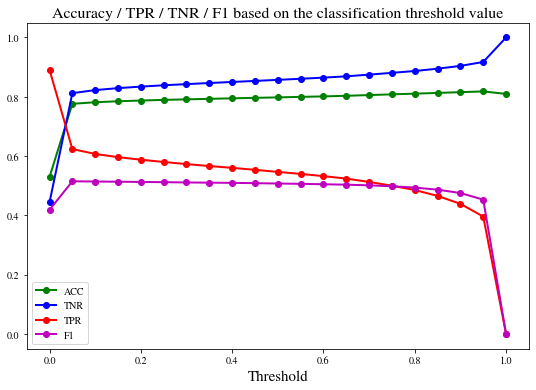

Chosen classification threshold is: 0.025
Edge labels: number of positive: 525768
Predictions: number of positive: 775781


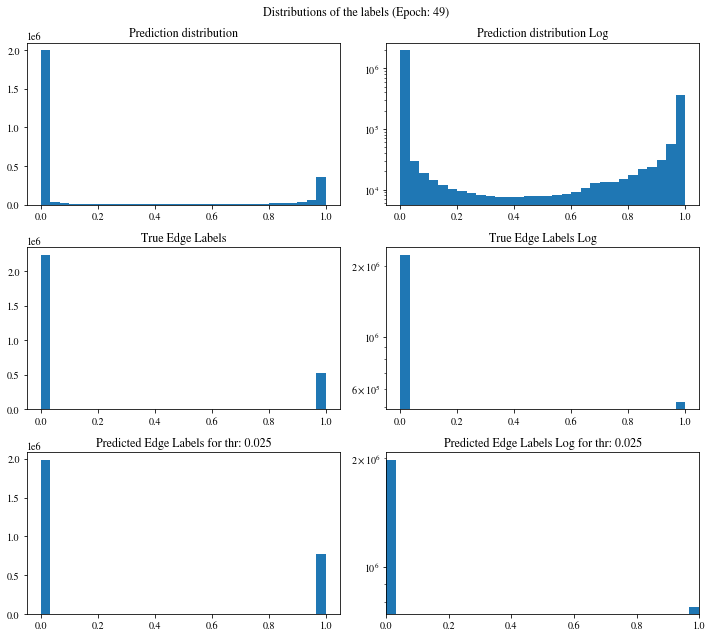

scores [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.94626624e-06
 6.09545836e-09 2.17520355e-04]
Confusion matrix:
[[1794307  440623]
 [ 190610  335158]]

Confusion matrix weighted:
[[0.40142353 0.09857647]
 [0.18126816 0.31873184]]

TN: 1794307 	 FN: 190610 	 TP: 335158 	 FP: 440623
Confusion matrix scaled:
[[0.64994686 0.15960565]
 [0.06904413 0.12140336]]

Accuracy: 0.7714
Precision: 0.4320
Negative predictive value: 0.9040
Recall: Correctly classifying 63.7464 % of positive edges
True negative rate: Correctly classifying 80.2847 % of all negative edges
F1 score: 0.5150
[0.6889124  0.76378024] [0.80284707 0.63746367] [0.74152879 0.69492849]
Balanced accuracy: 0.7202
Precision weighted: [0.6889124  0.76378024]
Recall weighted: [0.80284707 0.63746367]
F1 score weighted: [0.74152879 0.69492849]
positive_likelihood_ratio: 3.2333461596140713, negative_likelihood_ratio: 0.45156336965322486


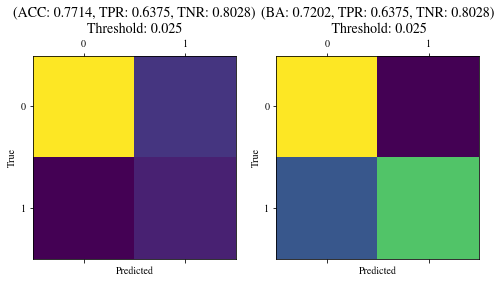

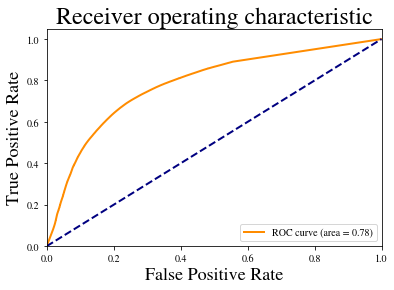

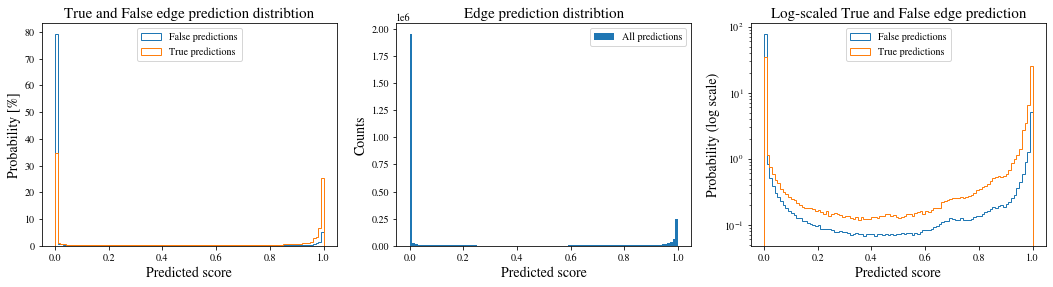

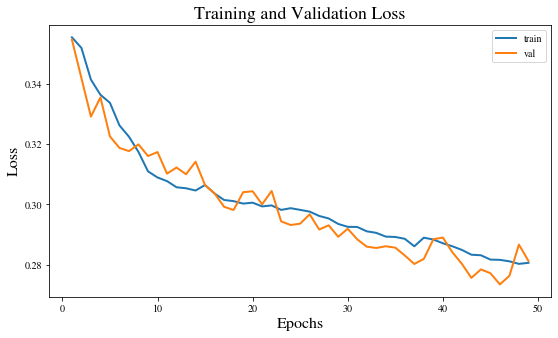

Training epoch 50:  10%|█         | 2/20 [00:00<00:01, 10.88it/s]

sample.edge_index tensor([[   4,   11,   22,  ..., 3621, 3626, 3622],
        [   0,    0,    0,  ..., 3626, 3622, 3626]], device='cuda:0')
sample.edge_index tensor([[   3,   11,   14,  ..., 3829, 3834, 3832],
        [   0,    0,    0,  ..., 3830, 3832, 3834]], device='cuda:0')


Training epoch 50:  20%|██        | 4/20 [00:00<00:01,  8.85it/s]

sample.edge_index tensor([[   7,   10,   17,  ..., 3903, 3906, 3905],
        [   0,    0,    0,  ..., 3904, 3905, 3906]], device='cuda:0')
sample.edge_index tensor([[  73,   74,  129,  ..., 3192, 3196, 3194],
        [   0,    0,    0,  ..., 3193, 3194, 3196]], device='cuda:0')


Training epoch 50:  30%|███       | 6/20 [00:00<00:01,  8.62it/s]

sample.edge_index tensor([[  17,   20,   24,  ..., 4292, 4295, 4293],
        [   0,    0,    0,  ..., 4295, 4293, 4295]], device='cuda:0')
sample.edge_index tensor([[  26,   64,   71,  ..., 3147, 3149, 3148],
        [   0,    0,    0,  ..., 3149, 3148, 3149]], device='cuda:0')


Training epoch 50:  40%|████      | 8/20 [00:00<00:01, 10.05it/s]

sample.edge_index tensor([[   9,   22,   78,  ..., 2663, 2667, 2666],
        [   0,    0,    0,  ..., 2664, 2666, 2667]], device='cuda:0')
sample.edge_index tensor([[   4,   12,   19,  ..., 3937, 3939, 3938],
        [   0,    0,    0,  ..., 3939, 3938, 3939]], device='cuda:0')
sample.edge_index tensor([[  71,   82,  101,  ..., 3105, 3107, 3106],
        [   0,    0,    0,  ..., 3107, 3106, 3107]], device='cuda:0')


Training epoch 50:  50%|█████     | 10/20 [00:01<00:00, 10.04it/s]

sample.edge_index tensor([[  15,   22,   92,  ..., 3262, 3265, 3263],
        [   0,    0,    0,  ..., 3265, 3263, 3265]], device='cuda:0')
sample.edge_index tensor([[  30,   31,   32,  ..., 3599, 3605, 3604],
        [   0,    0,    0,  ..., 3600, 3604, 3605]], device='cuda:0')


Training epoch 50:  60%|██████    | 12/20 [00:01<00:00,  9.93it/s]

sample.edge_index tensor([[  44,  219,  339,  ..., 3179, 3185, 3184],
        [   0,    0,    0,  ..., 3181, 3184, 3185]], device='cuda:0')
sample.edge_index tensor([[   6,   24,   28,  ..., 3672, 3674, 3673],
        [   0,    0,    0,  ..., 3674, 3673, 3674]], device='cuda:0')
sample.edge_index tensor([[   2,   27,   87,  ..., 3176, 3181, 3180],
        [   0,    0,    0,  ..., 3177, 3180, 3181]], device='cuda:0')


Training epoch 50:  80%|████████  | 16/20 [00:01<00:00,  9.36it/s]

sample.edge_index tensor([[   9,   31,   41,  ..., 3753, 3756, 3755],
        [   0,    0,    0,  ..., 3754, 3755, 3756]], device='cuda:0')
sample.edge_index tensor([[   6,   37,   43,  ..., 3416, 3418, 3417],
        [   0,    0,    0,  ..., 3418, 3417, 3418]], device='cuda:0')


Training epoch 50:  90%|█████████ | 18/20 [00:01<00:00,  9.11it/s]

sample.edge_index tensor([[  12,   18,   20,  ..., 3611, 3613, 3612],
        [   0,    0,    0,  ..., 3613, 3612, 3613]], device='cuda:0')
sample.edge_index tensor([[  81,  104,  108,  ..., 3043, 3046, 3044],
        [   0,    0,    0,  ..., 3046, 3044, 3046]], device='cuda:0')


Training epoch 50: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


sample.edge_index tensor([[  23,   28,   43,  ..., 3384, 3386, 3385],
        [   0,    0,    0,  ..., 3386, 3385, 3386]], device='cuda:0')
sample.edge_index tensor([[   2,    4,   22,  ..., 3381, 3384, 3383],
        [   0,    0,    0,  ..., 3382, 3383, 3384]], device='cuda:0')
Epoch: 50, train loss: 0.2803
>>> Saving model to ./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_50_loss_0.2803.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.55it/s]


pred [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 7.2545675e-13 1.0000000e+00
 1.0000000e+00]
Epoch: 50, val loss: 0.2797


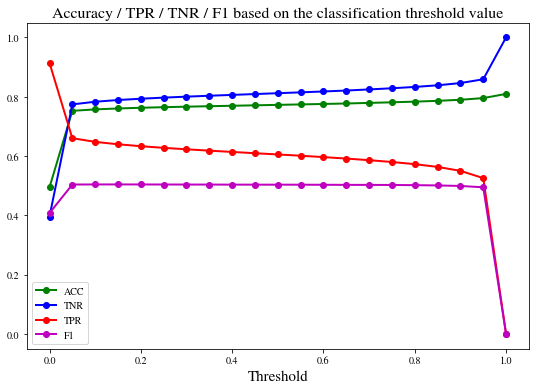

Chosen classification threshold is: 0.025
Edge labels: number of positive: 525768
Predictions: number of positive: 875587


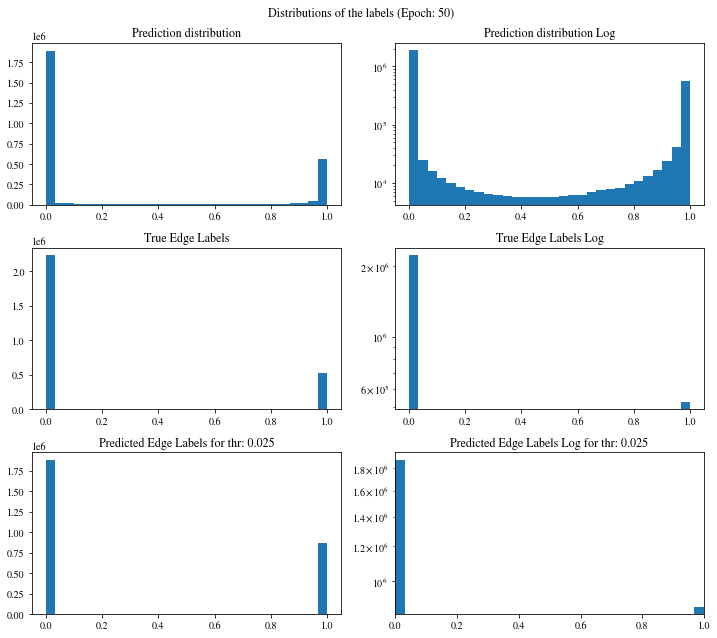

scores [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 7.2545675e-13 1.0000000e+00
 1.0000000e+00]
Confusion matrix:
[[1712183  522747]
 [ 172928  352840]]

Confusion matrix weighted:
[[0.3830507  0.1169493 ]
 [0.16445276 0.33554724]]

TN: 1712183 	 FN: 172928 	 TP: 352840 	 FP: 522747
Confusion matrix scaled:
[[0.62019931 0.1893532 ]
 [0.06263923 0.12780826]]

Accuracy: 0.7480
Precision: 0.4030
Negative predictive value: 0.9083
Recall: Correctly classifying 67.1094 % of positive edges
True negative rate: Correctly classifying 76.6101 % of all negative edges
F1 score: 0.5036
[0.69963156 0.74154653] [0.7661014  0.67109448] [0.7313593  0.70456369]
Balanced accuracy: 0.7186
Precision weighted: [0.69963156 0.74154653]
Recall weighted: [0.7661014  0.67109448]
F1 score weighted: [0.7313593  0.70456369]
positive_likelihood_ratio: 2.8691684032651628, negative_likelihood_ratio: 0.4293237490959471


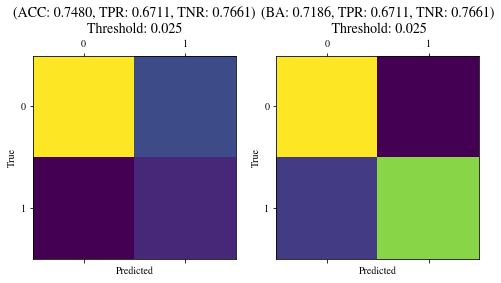

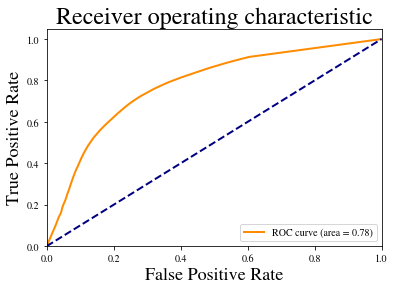

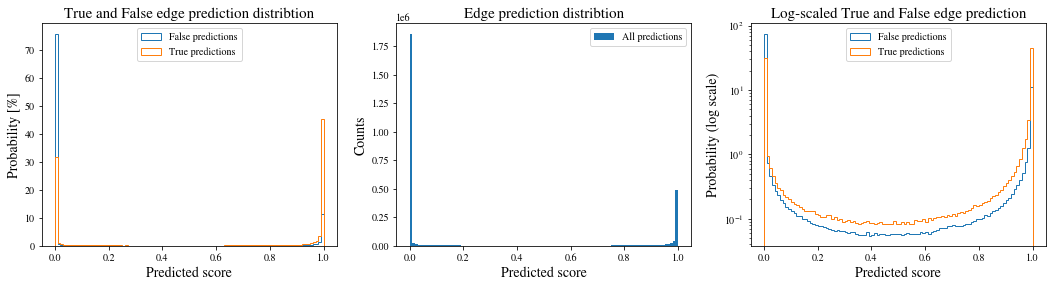

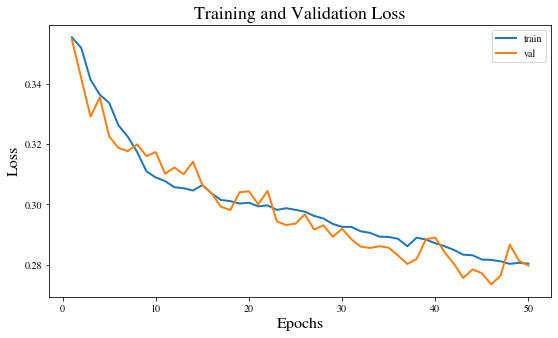

In [45]:
epochs = 50
decision_th = 0.5
outputModelPath = "./model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize"
mkdir_p(outputModelPath)
train_loss_hist = []
val_loss_hist = []

for epoch in range(epochs):
    
    loss = train(model, optimizer, train_dl, epoch+1, device, edge_features=True)
    train_loss_hist.append(loss)
    print(f'Epoch: {epoch+1}, train loss: {loss:.4f}')
    
    print(f">>> Saving model to {outputModelPath + f'/model_epoch_{epoch+1}_loss_{loss:.4f}.pt'}")
    torch.save({'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, outputModelPath + f'/model_epoch_{epoch+1}_loss_{loss:.4f}.pt')
    
    # Validation
    model.eval()
    pred, lab = [], []
    val_loss, j = 0, 0
    print("Validation step")
    for sample in tqdm(val_dl, desc="Validation"):
        sample = sample.to(device)
        if sample.edge_index.shape[1] != sample.edge_features.shape[0]:
            continue
        data = prepare_network_input_data(sample.x, sample.edge_index, sample.edge_features, device=device)
        #nn_pred, edge_emb = model(*data, device=device)
        data = tuple(tensor.float() for tensor in data)
    
    # Convert the model to float32 format if necessary
        model = model.float()
        nn_pred = model(*data, device=device)
        pred += nn_pred.tolist()
        lab += sample.edge_label.tolist()
        val_loss += loss_obj(nn_pred, sample.edge_label.float()).item()
        j += 1
    print('pred', np.array(pred))
    val_loss = float(val_loss)/j
    print(f'Epoch: {epoch+1}, val loss: {val_loss:.4f}')
    val_loss_hist.append(val_loss)
    
    TNR, TPR, thresholds = classification_thresholds_plot(np.array(pred), np.array(lab),
                                                          threshold_step=0.05, output_folder=outputModelPath,
                                                        epoch=epoch+1)
    
    classification_threshold = get_best_threshold(TNR, TPR, thresholds)
    print(f"Chosen classification threshold is: {classification_threshold}")

    plot_prediction_distribution_standard_and_log(np.array(pred), np.array(lab),
                                                  epoch=epoch+1, thr = classification_threshold,
                                                 folder=outputModelPath, val=True)

    test(np.array(lab), np.array(pred), classification_threshold=classification_threshold,
                        output_folder=outputModelPath, epoch=epoch+1)
    save_pred(np.array(pred), np.array(lab), epoch=epoch, out_folder=outputModelPath)
    save_loss(train_loss_hist, val_loss_hist, outputLossFunctionPath=outputModelPath)

    scheduler.step()

   

##### import gc


t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved

print(t, r, a, f)

print(torch.cuda.mem_get_info())
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()
print(torch.cuda.mem_get_info())


t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved

print(t, r, a, f)

In [46]:
# For getting the onnx file 
model = GNN_TrackLinkingNet(input_dim=2, hidden_dim=16, output_dim=1, dropout =0.2,  
                 edge_feature_dim=2, edge_hidden_dim=16, weighted_aggr=True)

checkpoint = torch.load('model_saved/bidirectional_models/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV_TTbarPU_bidirection_th0p3_optimize/model_epoch_50_loss_0.2803.pt', map_location=device)
#model_state_dict = checkpoint['model_state_dict']
model.load_state_dict(checkpoint["model_state_dict"])
print('device', device)
print(f"Model epoch: {checkpoint['epoch']}")
print(">>> Model Loaded.")

device = torch.device('cpu')
model.to(device)
model = model.cpu()
model.eval()
data = next(iter(train_dl)).to(device)
dummy_input = prepare_network_input_data(data.x, data.edge_index, data.edge_features)
dummy_input = tuple(tensor.float() for tensor in dummy_input)
        
model = model.float()
pred = model(*dummy_input)

#print(dummy_input[0].shape)
#print(dummy_input[0].shape, dummy_input[1].shape, dummy_input[2].shape)
print(pred)


device cuda
Model epoch: 50
>>> Model Loaded.
tensor([1.1710e-34, 0.0000e+00, 9.9594e-01,  ..., 6.2675e-04, 3.0694e-01,
        4.3707e-01], grad_fn=<SqueezeBackward1>)


In [47]:
import onnx
import onnxruntime as ort
"""
Exporting a model from pytorch to onnx and rnunning it using onnx runtime.
"""
import torch.onnx.verification
#torch.manual_seed(0)

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

onnx_path =  "model_v6version_PULV_TTbarPU_4Oct_bidirection_th0p3.onnx"



torch.onnx.export(model, dummy_input, onnx_path, verbose=False,
                  input_names=['features', 'edge_index', 'edge_features'],
                  output_names=['edge_predictions'], 
                  opset_version=17, # the ONNX version to export the model to
                  do_constant_folding=True,
                  keep_initializers_as_inputs=False,
                  export_params=True, # store the trained parameter weights inside the model file
                  dynamic_axes={'features' : {1 : 'number_of_nodes'},    # variable length axes
                                'edge_index' : {2 : 'number_of_edges'},
                                'edge_features' : {1 : 'number_of_edges'}}) 
                                
                               



# Load the ONNX model
print(">>> Loading onnx model.")
model_onnx = onnx.load(onnx_path)

/tmp/ipykernel_324/2570452066.py:176: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  src, dst = edge_index
/tmp/ipykernel_324/2570452066.py:190: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if not return_emb:


>>> Loading onnx model.


>>> Model formatting checked.
[0.0000000e+00 0.0000000e+00 9.9594301e-01 ... 6.2644482e-04 3.0695856e-01
 4.3716103e-01]
[1.1710354e-34 0.0000000e+00 9.9594384e-01 ... 6.2675396e-04 3.0693847e-01
 4.3707368e-01]


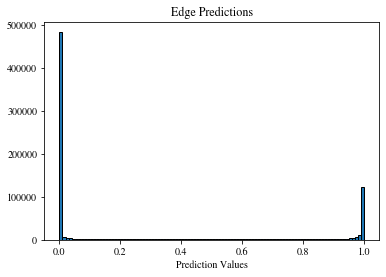

Exported model has been tested with ONNXRuntime, and the result looks good!


In [48]:
# Check that the model is well formed
onnx.checker.check_model(model_onnx)
print(">>> Model formatting checked.")

#print(onnx.helper.printable_graph(model_onnx.graph))

EP_list = ['CPUExecutionProvider']

# initialize the model
ort_session = ort.InferenceSession(onnx_path, providers=EP_list) # or use model_onnx.SerializeToString() as first argument for loaded model

ort_outs = ort_session.run(
    None,
    {ort_session.get_inputs()[0].name: to_numpy(dummy_input[0]),
     ort_session.get_inputs()[1].name: to_numpy(dummy_input[1]),
     ort_session.get_inputs()[2].name: to_numpy(dummy_input[2])
    },
)
 
print(ort_outs[0])
print(to_numpy(pred))

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(pred), ort_outs[0], rtol=1e-01, atol=1e-05)
#np.testing.assert_allclose(to_numpy(node_emb), ort_outs[1], rtol=1e-03, atol=1e-05)
plt.hist(to_numpy(pred), bins=100, edgecolor='black')
#plt.xlim([0.0, 1.0])
#plt.tight_layout()
plt.xlabel('Prediction Values')
plt.title('Edge Predictions')
#plt.savefig(f"{dataset_location}/Zee_noPU.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()
print("Exported model has been tested with ONNXRuntime, and the result looks good!")

In [137]:
#DEBUGGING 
 # Print the expected inputs for the ONNX model
print_training_dataset_statistics(trainDataset) 

print("Expected inputs for the ONNX model:")
for input in ort_session.get_inputs():
    print(f"Name: {input.name}, Shape: {input.shape}, Type: {input.type}")
if len(ort_outs) > 0:
    print(f"Output 0 shape: {ort_outs[0].shape}")
if len(ort_outs) > 1:
    print(f"Output 1 shape: {ort_outs[1].shape}")
graph_info = torch.onnx.verification.GraphInfo(model, input_args=dummy_input,params_dict=3)

print(graph_info.verify_export(flatten=False))
#graph_info.pretty_print_mismatch()

#graph_info2 = torch.onnx.verification.find_mismatch(model, input_args=dummy_input,do_constant_folding=True, opset_version=13, verbose=False )
#torch.onnx.verification.find_mismatch(model, input_args=dummy_input,
 #               do_constant_folding=True, opset_version=13, keep_initializers_as_inputs=True, verbose=False,flatten=False)


Number of events in training dataset: 80
Number of nodes: 274801
Number of edges: 23886513
Number of positive edges: 3856700
Number of negative edges: 20029813
Expected inputs for the ONNX model:
Name: features, Shape: [1, 'number_of_nodes', 21], Type: tensor(float)
Name: edge_index, Shape: [1, 2, 'number_of_edges'], Type: tensor(float)
Name: edge_features, Shape: [1, 'number_of_edges', 12], Type: tensor(float)
Output 0 shape: (266138,)


TypeError: verify_export() got an unexpected keyword argument 'flatten'

In [ ]:
torch.onnx.verification.GraphInfo(model, input_args=pred,params_dict=['features', 'edge_index', 'edge_features']) 

In [156]:
dataset_locationZee = "./vertexing_dataset_PU_index_ZeenoPU/"

print(">>> Loading datasets...")
trainDataset_Zee = torch.load(f"{dataset_locationZee}/dataTraining.pt")
valDataset_Zee = torch.load(f"{dataset_locationZee}/dataVal.pt")
testList = torch.load(f"{dataset_locationZee}/dataTest.pt")
train_dlZee = DataLoader(valDataset_Zee[:20], batch_size=1, shuffle=True)

>>> Loading datasets...


device cpu
Model epoch: 50
>>> Model Loaded.
E 362395


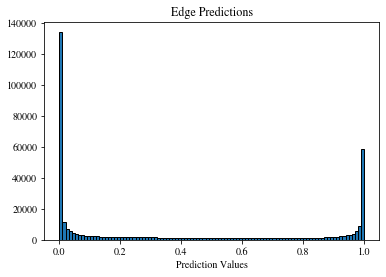

In [35]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = GNN_TrackLinkingNet(input_dim=21, hidden_dim=16, output_dim=1, niters=2, dropout=0.2,
 #                edge_feature_dim=12, edge_hidden_dim=16, weighted_aggr=True)

checkpoint = torch.load('model_saved/gnn_50_epochs_cosine_annealing_PU_index_onlyz_LV/model_epoch_50_loss_0.1356.pt', map_location=device)
#model_state_dict = checkpoint['model_state_dict']
model.load_state_dict(checkpoint["model_state_dict"])
print('device', device)
print(f"Model epoch: {checkpoint['epoch']}")
print(">>> Model Loaded.")

model.eval()


device = torch.device('cpu')  # or 'cuda' if using GPU
model.to(device)

# Get a batch of validation data
data = next(iter(train_dl)).to(device)

dummy_input = prepare_network_input_data(data.x, data.edge_index, data.edge_features)
pred = model(*dummy_input, device)

if isinstance(pred, torch.Tensor):
    pred = pred.detach().cpu().numpy()

plt.hist(pred, bins=100, edgecolor='black')
#plt.xlim([0.0, 1.0])
#plt.tight_layout()
plt.xlabel('Prediction Values')
plt.title('Edge Predictions')
plt.savefig(f"{dataset_location}/Zee_noPU.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

# MLP model

In [ ]:

# import torch
# import torch.nn as nn


# def prepare_network_input_data(X, edge_index, edge_features=None, device=None):
#     X = torch.nan_to_num(X, nan=0.0)
#     if edge_features is not None:
#         edge_features = torch.nan_to_num(edge_features, nan=0.0)
#         return torch.unsqueeze(X, dim=0), torch.unsqueeze(edge_index, dim=0).float(), torch.unsqueeze(edge_features, dim=0).float()
#     return torch.unsqueeze(X, dim=0), torch.unsqueeze(edge_index, dim=0).float()
    
# class MLP_TrackLinkingNet(nn.Module):
#     def __init__(self, input_dim=33, hidden_dim=256, output_dim=1, dropout=0.2, normalize_stop=30,
#                  reconstruction_volume=(3 - 1.5)*2*47*2, both_way_edge_emb=False, edge_feature_dim=0,
#                  edge_hidden_dim=32):
#         super(MLP_TrackLinkingNet, self).__init__()
        
#         self.input_dim = input_dim
#         self.normalize_stop = normalize_stop
#         self.reconstruction_volume = reconstruction_volume
#         self.both_way_edge_emb = both_way_edge_emb
#         self.edge_feature_dim = edge_feature_dim
        
#         # Node Feature transformation to latent space
#         self.inputnetwork = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.LeakyReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.LeakyReLU()
#         )
        
#         if self.edge_feature_dim != 0:
#             # Edge feature transformation to latent space
#             self.edge_inputnetwork = nn.Sequential(
#                 nn.Linear(edge_feature_dim, edge_hidden_dim),
#                 nn.LeakyReLU(),
#                 nn.Dropout(dropout),
#                 nn.Linear(edge_hidden_dim, edge_hidden_dim),
#                 nn.LeakyReLU()
#             )
            
#         inp_dim = 2*hidden_dim + edge_hidden_dim + edge_feature_dim if self.edge_feature_dim != 0 else 2*hidden_dim
#         # Edge features from node embeddings for classification
#         self.edgenetwork = nn.Sequential(
#             nn.Linear(inp_dim, hidden_dim),
#             nn.LeakyReLU(),
#             nn.Linear(hidden_dim, hidden_dim//2),
#             nn.LeakyReLU(),
#             nn.Linear(hidden_dim//2, output_dim),
#             nn.Dropout(p=dropout),
#             nn.Sigmoid()
#         )
        
    
#     def forward(self, X, edge_index, edge_features=None, device="cuda"):
        
#         X = torch.squeeze(X, dim=0)
#         X = X[:, :self.input_dim]
#         X_norm = torch.zeros_like(X)
        
#         stop = self.normalize_stop
#         epsilon = 10e-5 * torch.ones(X[:, :stop].shape, device=device)
        
#         std = X[:, :stop].std(dim=0, unbiased=False) + epsilon
#         X_norm[:, :stop] = (X[:, :stop] - X[:, :stop].mean(dim=0)) / std
            
#         if self.input_dim > self.normalize_stop:
#             # Normalizing total number of LCs and trackster -> turning it to density
        
#             X_norm[:, stop] = X[:, stop] / (1000 * self.reconstruction_volume)
#             X_norm[:, stop+1] = X[:, stop+1] / (100 * self.reconstruction_volume)
            
#         if self.input_dim == 33:
#             # normalize across existent entries and set the rest to -1
#             valid_time_idx = X[:, -1] > -99
#             invalid_time_idx = X[:, -1] <= -99
#             valid_time_X = X[valid_time_idx]
            
#             epsilon_time = 10e-5 * torch.ones(valid_time_X[:, -1].shape, device=device)
#             std_time = valid_time_X[:, -1].std(dim=0, unbiased=False) + epsilon_time
            
#             normalized_time = (valid_time_X[:, -1] - valid_time_X[:, -1].mean(dim=0)) / std_time
            
#             X_norm[valid_time_idx, -1] = normalized_time
#             X_norm[invalid_time_idx, -1] = -10 
            
#         # Standirdize `edge_features` if present
#         if self.edge_feature_dim != 0:
#             if edge_features is not None:
#                 edge_features = torch.squeeze(edge_features, dim=0)
#                 edge_features_norm = torch.zeros_like(edge_features)
#                 epsilon = 10e-5 * torch.ones(edge_features.shape, device=device)
#                 std = edge_features.std(dim=0, unbiased=False) + epsilon
#                 edge_features_norm = (edge_features - edge_features.mean(dim=0)) / std
#                 # TODO: time normalization should be different!!!
                
#                 edge_inp_emb = self.edge_inputnetwork(edge_features_norm)
                
#             else:
#                 print("ERROR: Edge features not provided!")
#                 return 100, 100
           
            
#         # Feature transformation to latent space
#         node_emb = self.inputnetwork(X_norm)
#         src, dst = torch.squeeze(edge_index, dim=0).long()
        
        
#         if self.edge_feature_dim != 0:
#             #print(node_emb[src].shape, node_emb[dst].shape, edge_features_norm.shape)
#             edge_emb = torch.cat([node_emb[src], node_emb[dst], edge_inp_emb, edge_features_norm], dim=-1)
#         else:
#             edge_emb = torch.cat([node_emb[src], node_emb[dst]], dim=-1)
            
#         pred = self.edgenetwork(edge_emb).squeeze(-1)
        
#         if self.both_way_edge_emb:
#             edge_emb_reversed = torch.cat([node_emb[dst], node_emb[src]], dim=-1)
#             pred_reversed = self.edgenetwork(edge_emb_reversed).squeeze(-1) 
#             #pred = (pred+pred_reversed)/2
#             pred = torch.min(pred, pred_reversed)
        
#         return pred, node_emb